# Instalación del paquetes

In [77]:
pip install dill

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [60]:
pip install ucimlrepo pandas numpy seaborn matplotlib scipy scikit-learn imbalanced-learn lightgbm optuna xgboost Jinja2 catboost umap-learn


   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 1.5 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.8 MB 1.5 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.8 MB 1.4 MB/s eta 0:00:02
   ------------------ --------------------- 1.3/2.8 MB 1.3 MB/s eta 0:00:02
   ---------------------- ----------------- 1.6/2.8 MB 1.2 MB/s eta 0:00:02
   ---------------------- ----------------- 1.6/2.8 MB 1.2 MB/s eta 0:00:02
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.1 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 815.6 kB/s eta 0:00:01
   ---------------------

In [63]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


# Importación de librerías

In [4]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
#from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, normaltest, anderson, chi2_contingency, spearmanr, kruskal, mannwhitneyu
from sklearn.feature_selection import mutual_info_classif
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, classification_report

from scipy.stats import friedmanchisquare, wilcoxon
import itertools
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectFromModel
import umap.umap_ as umap
import shap
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
import optuna
from xgboost import XGBClassifier
import math
import time

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exportar/Importar variables

## Dataset

In [ ]:
import pickle

# Abre el archivo en modo lectura binaria y carga el diccionario de variables
with open("dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

# Accede a las variables utilizando las claves del diccionario
data = dataset['dataset']

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,0,3,0,5,0,1,5,6,7,0
253676,1,1,1,18,0,0,0,0,0,0,...,0,4,0,0,1,0,11,2,4,1
253677,0,0,1,28,0,0,0,1,1,0,...,0,1,0,0,0,0,2,5,2,0
253678,1,0,1,23,0,0,0,0,1,1,...,0,3,0,0,0,1,7,5,1,0


## lr

In [42]:
import pickle

# Crear un diccionario solo con las variables que necesitas
lr_variables = {
    "metrics_lr_opt_ov": metrics_lr_opt_ov,
    "metrics_lr_opt_un": metrics_lr_opt_un,
    "metrics_lr_opt_wght": metrics_lr_opt_wght,
    "metrics_lr_opt_un_ov": metrics_lr_opt_un_ov,
    "metrics_lr_opt_un_ov_wght": metrics_lr_opt_un_ov_wght,
    "metrics_lr_opt_un_wght": metrics_lr_opt_un_wght,
    "metrics_lr_randcv_ov": metrics_lr_randcv_ov,
    "metrics_lr_randcv_un": metrics_lr_randcv_un,
    "metrics_lr_randcv_wght": metrics_lr_randcv_wght,
    "metrics_lr_randcv_un_ov": metrics_lr_randcv_un_ov,
    "metrics_lr_randcv_un_ov_wght": metrics_lr_randcv_un_ov_wght,
    "metrics_lr_randcv_un_wght": metrics_lr_randcv_un_wght,
    "metrics_lr_man_sel": metrics_lr_man_sel,
    "metrics_lr_aut_sel": metrics_lr_aut_sel,
    "metrics_lr_red_dim": metrics_lr_red_dim,
    "metrics_lr_all": metrics_lr_all,
    "metrics_lr_final": metrics_lr_final
}

with open("lr_variables.pkl", "wb") as f:
    pickle.dump(lr_variables, f)


In [ ]:
import pickle

# Abre el archivo en modo lectura binaria y carga el diccionario de variables
with open("lr_variables.pkl", "rb") as f:
    lr_variables = pickle.load(f)

# Accede a las variables utilizando las claves del diccionario
metrics_lr_opt_ov = lr_variables['metrics_lr_opt_ov']
metrics_lr_opt_un = lr_variables['metrics_lr_opt_un']
metrics_lr_opt_wght = lr_variables['metrics_lr_opt_wght']
metrics_lr_opt_un_ov = lr_variables['metrics_lr_opt_un_ov']
metrics_lr_opt_un_ov_wght = lr_variables['metrics_lr_opt_un_ov_wght']
metrics_lr_opt_un_wght = lr_variables['metrics_lr_opt_un_wght']
metrics_lr_randcv_ov = lr_variables['metrics_lr_randcv_ov']
metrics_lr_randcv_un = lr_variables['metrics_lr_randcv_un']
metrics_lr_randcv_wght = lr_variables['metrics_lr_randcv_wght']
metrics_lr_randcv_un_ov = lr_variables['metrics_lr_randcv_un_ov']
metrics_lr_randcv_un_ov_wght = lr_variables['metrics_lr_randcv_un_ov_wght']
metrics_lr_randcv_un_wght = lr_variables['metrics_lr_randcv_un_wght']
metrics_lr_man_sel = lr_variables['metrics_lr_man_sel']
metrics_lr_aut_sel = lr_variables['metrics_lr_aut_sel']
metrics_lr_red_dim = lr_variables['metrics_lr_red_dim']
metrics_lr_all = lr_variables['metrics_lr_all']
metrics_lr_final = lr_variables['metrics_lr_final']


## rf

In [47]:
import pickle

rf_variables = {
    "metrics_rf_man_sel": metrics_rf_man_sel,
    "metrics_rf_aut_sel": metrics_rf_aut_sel,
    "metrics_rf_red_dim": metrics_rf_red_dim,
    "metrics_rf_all": metrics_rf_all,
    "metrics_rf_opt_un": metrics_rf_opt_un,
    "metrics_rf_opt_wght": metrics_rf_opt_wght,
    "metrics_rf_opt_un_wght": metrics_rf_opt_un_wght,
    "metrics_rf_randcv_un": metrics_rf_randcv_un,
    "metrics_rf_randcv_wght": metrics_rf_randcv_wght,
    "metrics_rf_randcv_un_wght": metrics_rf_randcv_un_wght,
    "metrics_rf_final": metrics_rf_final
}

with open("rf_variables.pkl", "wb") as f:
    pickle.dump(rf_variables, f)


In [ ]:
import pickle

# Abre el archivo en modo lectura binaria y carga el diccionario de variables
with open("rf_variables.pkl", "rb") as f:
    rf_variables = pickle.load(f)

# Accede a las variables utilizando las claves del diccionario
metrics_rf_opt_un = rf_variables['metrics_rf_opt_un']
metrics_rf_opt_wght = rf_variables['metrics_rf_opt_wght']
metrics_rf_opt_un_wght = rf_variables['metrics_rf_opt_un_wght']
metrics_rf_randcv_un = rf_variables['metrics_rf_randcv_un']
metrics_rf_randcv_wght = rf_variables['metrics_rf_randcv_wght']
metrics_rf_randcv_un_wght = rf_variables['metrics_rf_randcv_un_wght']
metrics_rf_man_sel = rf_variables['metrics_rf_man_sel']
metrics_rf_aut_sel = rf_variables['metrics_rf_aut_sel']
metrics_rf_red_dim = rf_variables['metrics_rf_red_dim']
metrics_rf_all = rf_variables['metrics_rf_all']
metrics_rf_final = rf_variables['metrics_rf_final']

## brf

In [48]:
import pickle

brf_variables = {
    "metrics_brf_man_sel": metrics_brf_man_sel,
    "metrics_brf_aut_sel": metrics_brf_aut_sel,
    "metrics_brf_red_dim": metrics_brf_red_dim,
    "metrics_brf_all": metrics_brf_all,
    "metrics_brf_opt_un": metrics_brf_opt_un,
    "metrics_brf_opt_none": metrics_brf_opt_none,
    "metrics_brf_randcv_un": metrics_brf_randcv_un,
    "metrics_brf_randcv_none": metrics_brf_randcv_none,
    "metrics_brf_final": metrics_brf_final
}

with open("brf_variables.pkl", "wb") as f:
    pickle.dump(brf_variables, f)

In [ ]:
import pickle

# Abre el archivo en modo lectura binaria y carga el diccionario de variables
with open("brf_variables.pkl", "rb") as f:
    brf_variables = pickle.load(f)

# Accede a las variables utilizando las claves del diccionario
metrics_brf_opt_un = brf_variables['metrics_brf_opt_un']
metrics_brf_opt_none = brf_variables['metrics_brf_opt_none']
metrics_brf_randcv_un = brf_variables['metrics_brf_randcv_un']
metrics_brf_randcv_none = brf_variables['metrics_brf_randcv_none']
metrics_brf_man_sel = brf_variables['metrics_brf_man_sel']
metrics_brf_aut_sel = brf_variables['metrics_brf_aut_sel']
metrics_brf_red_dim = brf_variables['metrics_brf_red_dim']
metrics_brf_all = brf_variables['metrics_brf_all']
metrics_brf_final = brf_variables['metrics_brf_final']

KeyError: 'metrics_brf_final'

## lgbm

In [50]:
import pickle

lgb_variables = {
    "metrics_lgb_man_sel": metrics_lgb_man_sel,
    "metrics_lgb_aut_sel": metrics_lgb_aut_sel,
    "metrics_lgb_red_dim": metrics_lgb_red_dim,
    "metrics_lgb_all": metrics_lgb_all,
    "metrics_lgb_opt_un": metrics_lgb_opt_un,
    "metrics_lgb_opt_wght": metrics_lgb_opt_wght,
    "metrics_lgb_opt_un_wght": metrics_lgb_opt_un_wght,
    "metrics_lgb_randcv_un": metrics_lgb_randcv_un,
    "metrics_lgb_randcv_wght": metrics_lgb_randcv_wght,
    "metrics_lgb_randcv_un_wght": metrics_lgb_randcv_un_wght,
    "metrics_lgb_final": metrics_lgb_final
}

with open("lgb_variables.pkl", "wb") as f:
    pickle.dump(lgb_variables, f)


In [ ]:
import pickle

# Abre el archivo en modo lectura binaria y carga el diccionario de variables
with open("lgb_variables.pkl", "rb") as f:
    lgb_variables = pickle.load(f)

# Accede a las variables utilizando las claves del diccionario
metrics_lgb_opt_un = lgb_variables['metrics_lgb_opt_un']
metrics_lgb_opt_wght = lgb_variables['metrics_lgb_opt_wght']
metrics_lgb_opt_un_wght = lgb_variables['metrics_lgb_opt_un_wght']
metrics_lgb_randcv_un = lgb_variables['metrics_lgb_randcv_un']
metrics_lgb_randcv_wght = lgb_variables['metrics_lgb_randcv_wght']
metrics_lgb_randcv_un_wght = lgb_variables['metrics_lgb_randcv_un_wght']
metrics_lgb_man_sel = lgb_variables['metrics_lgb_man_sel']
metrics_lgb_aut_sel = lgb_variables['metrics_lgb_aut_sel']
metrics_lgb_red_dim = lgb_variables['metrics_lgb_red_dim']
metrics_lgb_all = lgb_variables['metrics_lgb_all']
metrics_lgb_final = lgb_variables['metrics_lgb_final']

## xgb

In [ ]:
import pickle

xgb_variables = {
    "metrics_xgb_man_sel": metrics_xgb_man_sel,
    "metrics_xgb_aut_sel": metrics_xgb_aut_sel,
    "metrics_xgb_red_dim": metrics_xgb_red_dim,
    "metrics_xgb_all": metrics_xgb_all,
    "metrics_xgb_opt_un": metrics_xgb_opt_un,
    "metrics_xgb_opt_wght": metrics_xgb_opt_wght,
    "metrics_xgb_opt_un_wght": metrics_xgb_opt_un_wght,
    "metrics_xgb_randcv_un": metrics_xgb_randcv_un,
    "metrics_xgb_randcv_wght": metrics_xgb_randcv_wght,
    "metrics_xgb_randcv_un_wght": metrics_xgb_randcv_un_wght,
    "metrics_xgb_final": metrics_xgb_final
}

with open("xgb_variables.pkl", "wb") as f:
    pickle.dump(xgb_variables, f)


In [ ]:
import pickle

# Abre el archivo en modo lectura binaria y carga el diccionario de variables
with open("xgb_variables.pkl", "rb") as f:
    xgb_variables = pickle.load(f)

# Accede a las variables utilizando las claves del diccionario
metrics_xgb_opt_un = xgb_variables['metrics_xgb_opt_un']
metrics_xgb_opt_wght = xgb_variables['metrics_xgb_opt_wght']
metrics_xgb_opt_un_wght = xgb_variables['metrics_xgb_opt_un_wght']
metrics_xgb_randcv_un = xgb_variables['metrics_xgb_randcv_un']
metrics_xgb_randcv_wght = xgb_variables['metrics_xgb_randcv_wght']
metrics_xgb_randcv_un_wght = xgb_variables['metrics_xgb_randcv_un_wght']
metrics_xgb_man_sel = xgb_variables['metrics_xgb_man_sel']
metrics_xgb_aut_sel = xgb_variables['metrics_xgb_aut_sel']
metrics_xgb_red_dim = xgb_variables['metrics_xgb_red_dim']
metrics_xgb_all = xgb_variables['metrics_xgb_all']
metrics_xgb_final = xgb_variables['metrics_xgb_final']

# Dataset

In [5]:
# fetch dataset
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes)
X = cdc_diabetes_health_indicators.data.features
Y = cdc_diabetes_health_indicators.data.targets
data = pd.concat([X, Y], axis=1)

data.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


In [6]:
# metadata
#print(cdc_diabetes_health_indicators.metadata)

# informacion de variables
variables_df = pd.DataFrame(cdc_diabetes_health_indicators.variables)
pd.set_option("display.max_colwidth", None)
display(variables_df[['name', 'description']].style.set_properties(**{'text-align': 'left'}))

# variables
numerical_columns = ['BMI', 'MentHlth', 'PhysHlth']
categorical_columns = X.drop(columns=numerical_columns).columns.tolist()
categorical_nonbinary_columns = ['GenHlth','Age', 'Education', 'Income']
categorical_binary_columns = [col for col in categorical_columns if col not in categorical_nonbinary_columns]

print("numerical_columns:", numerical_columns)
print("categorical_columns:", categorical_columns)
print("categorical_nonbinary_columns:", categorical_binary_columns)
print("categorical_binary_columns:", categorical_nonbinary_columns)

,name,description
0,ID,Patient ID
1,Diabetes_binary,0 = no diabetes 1 = prediabetes or diabetes
2,HighBP,0 = no high BP 1 = high BP
3,HighChol,0 = no high cholesterol 1 = high cholesterol
4,CholCheck,0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years
5,BMI,Body Mass Index
6,Smoker,Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes
7,Stroke,(Ever told) you had a stroke. 0 = no 1 = yes
8,HeartDiseaseorAttack,coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes
9,PhysActivity,physical activity in past 30 days - not including job 0 = no 1 = yes


numerical_columns: ['BMI', 'MentHlth', 'PhysHlth']
categorical_columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']
categorical_nonbinary_columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
categorical_binary_columns: ['GenHlth', 'Age', 'Education', 'Income']


# 1. Exploración de los datos

## 1.1. ProfileReport

In [ ]:
report = ProfileReport(data)
report

NameError: name 'ProfileReport' is not defined

Observaciones:
* ninguna de las variables tienen valores faltantes
* en principio son todo numeros (se comprobará más adelante)
* se comprueba que los valores introducido efectivamente son los que se esperaban (no hay valores incorrectos)
* a simple vista no se observan outlayers muy significativos (se comprobará más adelante)
* existen imbalances en los datos en: CholCheck (77.0%), Stroke (75.5%), HeartDiseaseorAttack (55.0%), HvyAlcoholConsump (68.8%), AnyHealthcare (71.8%) y NoDocbcCost (58.3%).
* el Dataset tiene 11369 (4.5%) filas iguales (duplicadas?) => NO van a eliminarse, ya que Machine Learning Repository afirma lo siguiente: "Each row represents a person participating in this study."

## 1.2. Distribución de las características

### Tipo de distribución
Se analiza si las variables numéricas siguen o no una distribución normal.

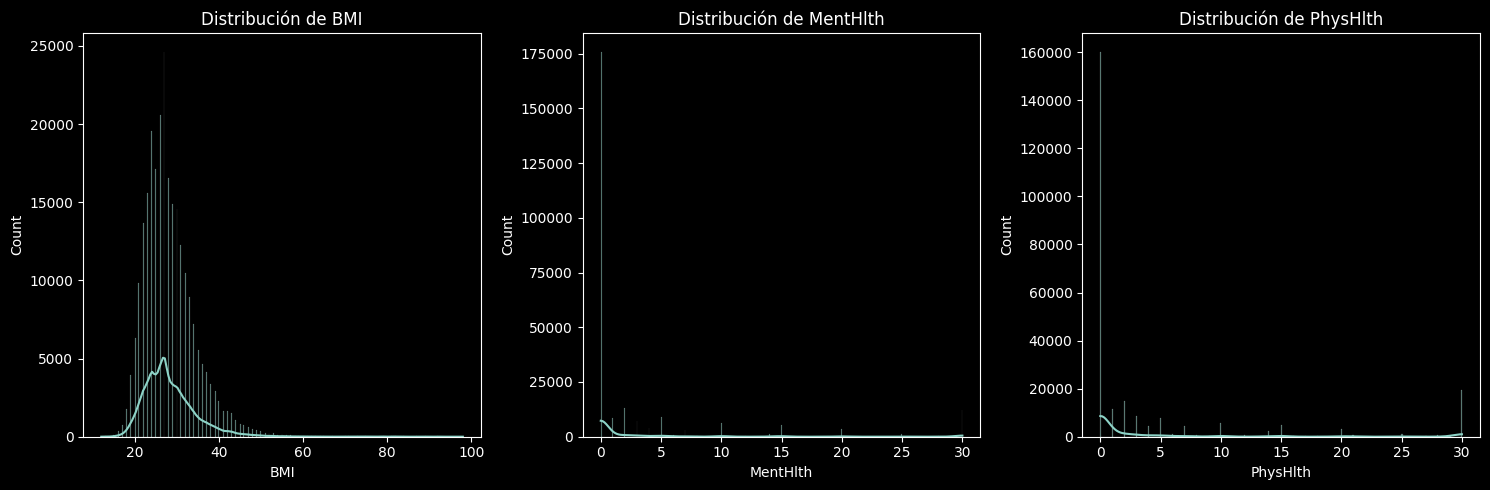


--- Análisis de normalidad para BMI ---
Shapiro-Wilk Test: Estadístico=0.8717, p=0.0000 (Rechaza H0)
D’Agostino’s K^2 Test: Estadístico=126255.7185, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0)
  Nivel de significancia 1.0% - Valor crítico: 1.0920 (Rechaza H0)

--- Análisis de normalidad para MentHlth ---
Shapiro-Wilk Test: Estadístico=0.4869, p=0.0000 (Rechaza H0)
D’Agostino’s K^2 Test: Estadístico=137190.8598, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 253680.
  res = hypotest_fun_out(*samples, **kwds)


D’Agostino’s K^2 Test: Estadístico=104008.5163, p=0.0000 (Rechaza H0)
Anderson-Darling Test:
  Nivel de significancia 15.0% - Valor crítico: 0.5760 (Rechaza H0)
  Nivel de significancia 10.0% - Valor crítico: 0.6560 (Rechaza H0)
  Nivel de significancia 5.0% - Valor crítico: 0.7870 (Rechaza H0)
  Nivel de significancia 2.5% - Valor crítico: 0.9180 (Rechaza H0)
  Nivel de significancia 1.0% - Valor crítico: 1.0920 (Rechaza H0)


In [ ]:
# Graficar histogramas y KDE plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, var in enumerate(numerical_columns):
    sns.histplot(X[var], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
plt.tight_layout()
plt.show()

# Pruebas de normalidad
def check_normality(data, var):
    print(f"\n--- Análisis de normalidad para {var} ---")
    stat, p = shapiro(data)
    print(f"Shapiro-Wilk Test: Estadístico={stat:.4f}, p={p:.4f} {'(Rechaza H0)' if p < 0.05 else '(No se rechaza H0)'}")

    stat, p = normaltest(data)
    print(f"D’Agostino’s K^2 Test: Estadístico={stat:.4f}, p={p:.4f} {'(Rechaza H0)' if p < 0.05 else '(No se rechaza H0)'}")

    result = anderson(data)
    print("Anderson-Darling Test:")
    for i in range(len(result.critical_values)):
        sig_level = result.significance_level[i]
        crit_val = result.critical_values[i]
        decision = "(Rechaza H0)" if result.statistic > crit_val else "(No se rechaza H0)"
        print(f"  Nivel de significancia {sig_level}% - Valor crítico: {crit_val:.4f} {decision}")

# Aplicar pruebas a cada variable
for var in numerical_columns:
    check_normality(X[var].dropna(), var)

Se concluye que **ninguna de las características numéricas siguen una distribución normal**.

### Desbalanceo de clases

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_31452\1777402780.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=Y.Diabetes_binary, palette="Set2")


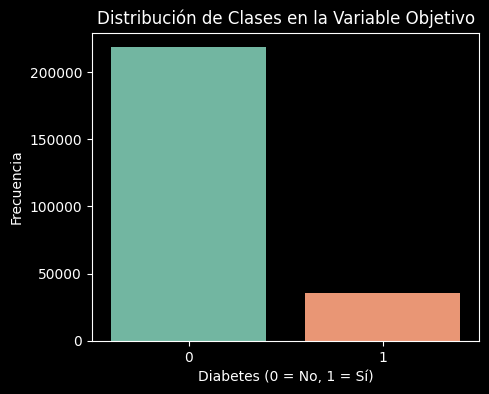

Diabetes_binary
0    0.860667
1    0.139333
Name: proportion, dtype: float64


In [ ]:
# Ver distribución de la variable objetivo
plt.figure(figsize=(5,4))
sns.countplot(x=Y.Diabetes_binary, palette="Set2")
plt.title("Distribución de Clases en la Variable Objetivo")
plt.xlabel("Diabetes (0 = No, 1 = Sí)")
plt.ylabel("Frecuencia")
plt.show()

# Ver proporción de cada clase
print(Y.Diabetes_binary.value_counts(normalize=True))

### Identificación de outliers

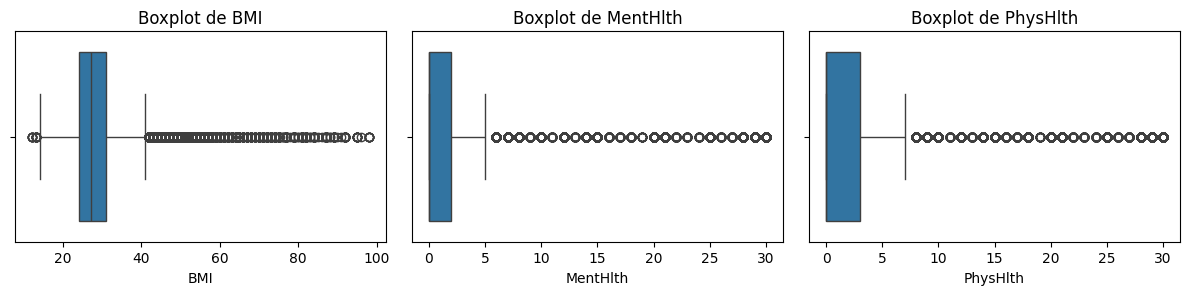

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=X[col])
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()

## 1.3. Tipo de datos

In [ ]:
data.dtypes

,0
HighBP,int64
HighChol,int64
CholCheck,int64
BMI,int64
Smoker,int64
Stroke,int64
HeartDiseaseorAttack,int64
PhysActivity,int64
Fruits,int64
Veggies,int64


## 1.4. Análisis

### Análisis bivariado
Se realiza un tipo de estudio según el tipo de variable que sean:
* Numérica - numérica: **Spearman**.
* Numérica - categórica binaria: **Mann-Whitney U** (se muestra el p valor).
* Numérica - categórica (+3 categorías): **Kruskal-Wallis**.
* Categórica - categórica: **Cramer's V**.

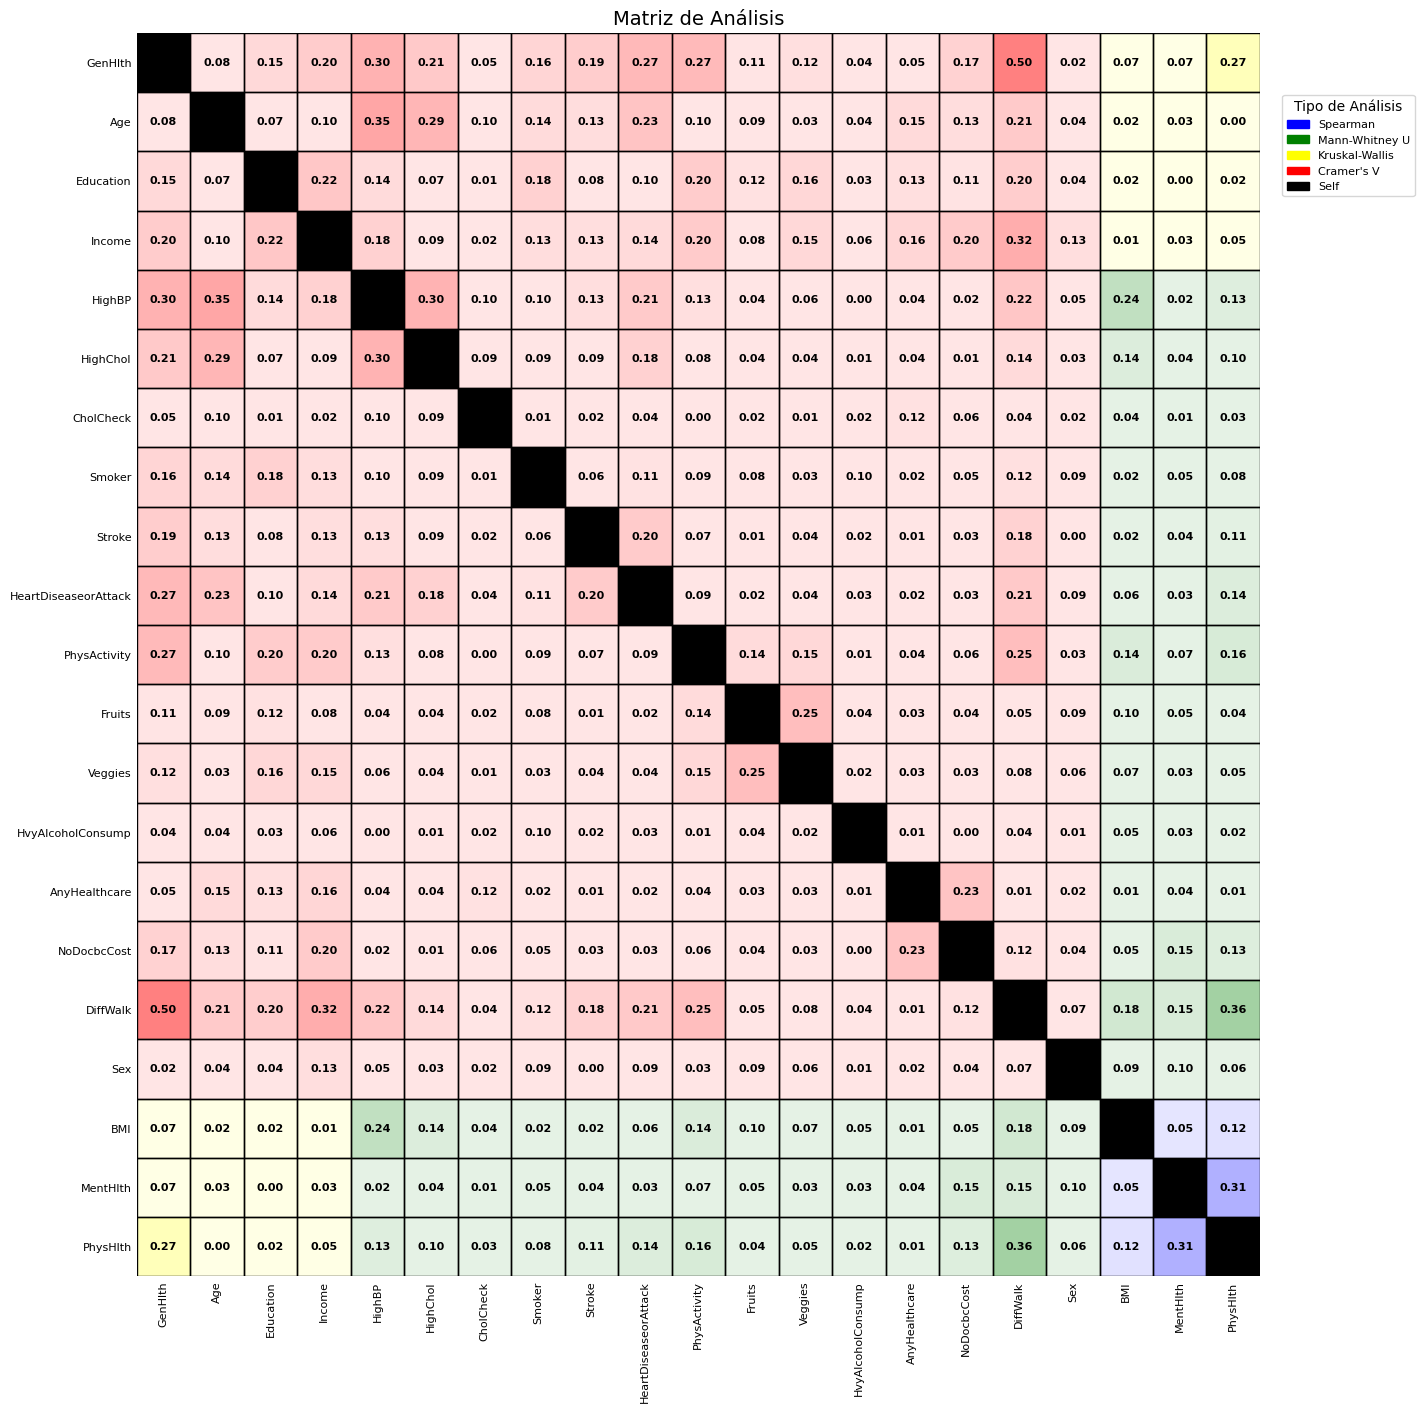

In [ ]:
# Diccionarios para identificación rápida de variables
categorical_vars = set(categorical_nonbinary_columns + categorical_binary_columns)
binary_vars = set(categorical_binary_columns)

def calculate_metric(x, y, x_is_categorical, y_is_categorical, x_is_binary, y_is_binary):
    if not x_is_categorical and not y_is_categorical:
        # Ambas variables son numéricas: uso de correlación de Spearman
        metric, p_value = spearmanr(x, y)
        analysis_type = 'Spearman'
    elif not x_is_categorical and y_is_categorical:
        # x numérica y y categórica
        if y_is_binary:
            # Caso binario: Mann-Whitney U con cálculo del efecto (r = |z|/sqrt(n1+n2))
            group1 = x[y == 0]
            group2 = x[y == 1]
            n1, n2 = len(group1), len(group2)
            try:
                U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                U_mean = n1 * n2 / 2.0
                sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)
                z = (U - U_mean) / sigma_U
                metric = abs(z) / np.sqrt(n1 + n2)
            except ValueError:
                metric, p_value = 0, 1.0
            analysis_type = 'Mann-Whitney U'
        else:
            # y categórica con más de 2 niveles: uso de Kruskal-Wallis y cálculo del efecto (eta²)
            groups = [x[y == cat] for cat in np.unique(y)]
            k = len(groups)
            n = len(x)
            if k > 1 and all(len(g) > 1 for g in groups):
                stat, p_value = kruskal(*groups)
                # Efecto estimado: eta² = (H - k + 1) / (n - k)
                metric = max(0, (stat - (k - 1)) / (n - k))
            else:
                metric, p_value = 0, 1.0
            analysis_type = 'Kruskal-Wallis'
    elif x_is_categorical and not y_is_categorical:
        # x categórica y y numérica (caso análogo)
        if x_is_binary:
            group1 = y[x == 0]
            group2 = y[x == 1]
            n1, n2 = len(group1), len(group2)
            try:
                U, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
                U_mean = n1 * n2 / 2.0
                sigma_U = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)
                z = (U - U_mean) / sigma_U
                metric = abs(z) / np.sqrt(n1 + n2)
            except ValueError:
                metric, p_value = 0, 1.0
            analysis_type = 'Mann-Whitney U'
        else:
            groups = [y[x == cat] for cat in np.unique(x)]
            k = len(groups)
            n = len(y)
            if k > 1 and all(len(g) > 1 for g in groups):
                stat, p_value = kruskal(*groups)
                metric = max(0, (stat - (k - 1)) / (n - k))
            else:
                metric, p_value = 0, 1.0
            analysis_type = 'Kruskal-Wallis'
    else:
        # Ambas variables categóricas: uso de la prueba chi-cuadrado y cálculo de Cramer's V
        contingency_table = pd.crosstab(x, y)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        n_total = contingency_table.values.sum()
        phi2 = chi2 / n_total
        r, k = contingency_table.shape
        try:
            metric = np.sqrt(phi2 / min((k - 1), (r - 1)))
        except ZeroDivisionError:
            metric = 0
        analysis_type = "Cramer's V"
    return metric, p_value, analysis_type

def create_metric_matrix(X, categorical_nonbinary_columns, categorical_binary_columns, numerical_columns):
    all_columns = categorical_nonbinary_columns + categorical_binary_columns + numerical_columns
    n = len(all_columns)
    metric_matrix = np.zeros((n, n))
    analysis_matrix = [[None] * n for _ in range(n)]

    for i in range(n):
        for j in range(n):
            if i == j:
                metric_matrix[i, j] = 1.0
                analysis_matrix[i][j] = 'Self'
            else:
                x = X[all_columns[i]]
                y = X[all_columns[j]]
                x_is_categorical = all_columns[i] in categorical_vars
                y_is_categorical = all_columns[j] in categorical_vars
                x_is_binary = all_columns[i] in binary_vars
                y_is_binary = all_columns[j] in binary_vars
                metric, p_value, analysis_type = calculate_metric(
                    x, y,
                    x_is_categorical, y_is_categorical,
                    x_is_binary, y_is_binary
                )
                metric_matrix[i, j] = metric
                analysis_matrix[i][j] = analysis_type

    metric_df = pd.DataFrame(metric_matrix, index=all_columns, columns=all_columns)
    analysis_df = pd.DataFrame(analysis_matrix, index=all_columns, columns=all_columns)
    return metric_df, analysis_df

# Generar la matriz de análisis
metric_df, analysis_df = create_metric_matrix(
    X,
    categorical_nonbinary_columns,
    categorical_binary_columns,
    numerical_columns
)

# Definir colores para cada tipo de análisis
analysis_colors = {
    "Spearman": "blue",
    "Mann-Whitney U": "green",
    "Kruskal-Wallis": "yellow",
    "Cramer's V": "red",
    "Self": "black"
}

# Graficar la matriz de análisis
fig, ax = plt.subplots(figsize=(18, 14))
for i in range(metric_df.shape[0]):
    for j in range(metric_df.shape[1]):
        value = metric_df.iloc[i, j]
        analysis_type = analysis_df.iloc[i, j]
        color = analysis_colors.get(analysis_type, "white")
        alpha = max(0.1, min(abs(value), 1))  # transparencia en rango [0.1, 1]
        rgba_color = to_rgba(color, alpha)
        rect = plt.Rectangle((j, i), 1, 1, color=rgba_color, ec='black')
        ax.add_patch(rect)
        ax.text(j + 0.5, i + 0.5, '<0.001' if value < 0.001 else f'{value:.2f}',
                ha='center', va='center', fontsize=8, fontweight='bold')

ax.set_xlim(0, metric_df.shape[1])
ax.set_ylim(0, metric_df.shape[0])
ax.invert_yaxis()
ax.set_xticks(np.arange(metric_df.shape[1]) + 0.5)
ax.set_yticks(np.arange(metric_df.shape[0]) + 0.5)
ax.set_xticklabels(metric_df.columns, rotation=90, fontsize=8)
ax.set_yticklabels(metric_df.index, fontsize=8)
ax.tick_params(axis='both', which='both', length=0)
for spine in ax.spines.values():
    spine.set_visible(False)

# Leyenda
legend_patches = [mpatches.Patch(color=color, label=label)
                  for label, color in analysis_colors.items()]
ax.legend(handles=legend_patches, loc='upper left',
          bbox_to_anchor=(1.02, 0.95), borderaxespad=0.0,
          title="Tipo de Análisis", fontsize=8)
plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.title("Matriz de Análisis", fontsize=14)
plt.show()

Para Correlación de Spearman 🔵:
* r < 0.10: Correlación despreciable o nula
* 0.10 ≤ r < 0.30: Correlación pequeña o débil
* 0.30 ≤ r < 0.50: Correlación moderada
* 0.50 ≤ r < 0.70: Correlación alta o fuerte
* r ≥ 0.70: Correlación muy fuerte

Para el Tamaño del Efecto derivado de la prueba de Mann-Whitney U 🟢(calculado como * r = |z|/√(n₁+n₂)):
* r ≈ 0.10: Efecto pequeño
* r ≈ 0.30: Efecto moderado
* r ≈ 0.50: Efecto grande

Para la medida de efecto derivada de la prueba de Kruskal-Wallis 🟡(usando eta²):
* 0.01 ≤ η² < 0.06: Efecto pequeño
* 0.06 ≤ η² < 0.14: Efecto moderado
* η² ≥ 0.14: Efecto grande

Para Cramer's V 🔴(utilizado en variables categóricas):
* V < 0.10: Asociación despreciable
* 0.10 ≤ V < 0.30: Asociación débil
* 0.30 ≤ V < 0.50: Asociación moderada
* V ≥ 0.50: Asociación fuerte

Fuente:
Cohen, J. (1988). Statistical Power Analysis for the Behavioral Sciences (2ª ed.). Lawrence Erlbaum Associates.

### Information Gain
obtenido de: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

Funciona bien con datos categóricos, ordinales y binarios y captura relaciones no lineales.

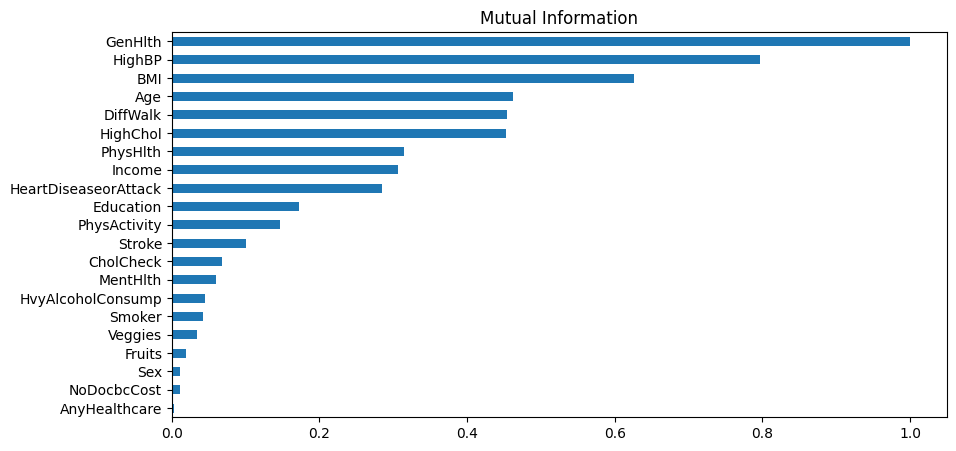

In [ ]:
# Calcular la información mutua
importances = mutual_info_classif(X, Y.Diabetes_binary, discrete_features=True, random_state=42)

# Crear un DataFrame con las importancias de las características
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Normalizar las importancias para comparación
feat_importances /= feat_importances.max()

# Visualizar las importancias de las características
plt.figure(figsize=(10, 5))
feat_importances.sort_values().plot(kind='barh')
plt.title('Mutual Information')
plt.show()

puede ser que el desbalance de las clases afecte a los resultados??

a continuacion:

✅ Se balancea primero el target con SMOTE para evitar que la información mutua esté sesgada hacia la clase mayoritaria.

✅ En lugar de balancear cada característica individualmente, se realiza un submuestreo general para mantener la estructura de correlación entre variables.

✅ Se compara la información mutua antes y después del balanceo para evaluar posibles efectos artificiales introducidos por SMOTE.

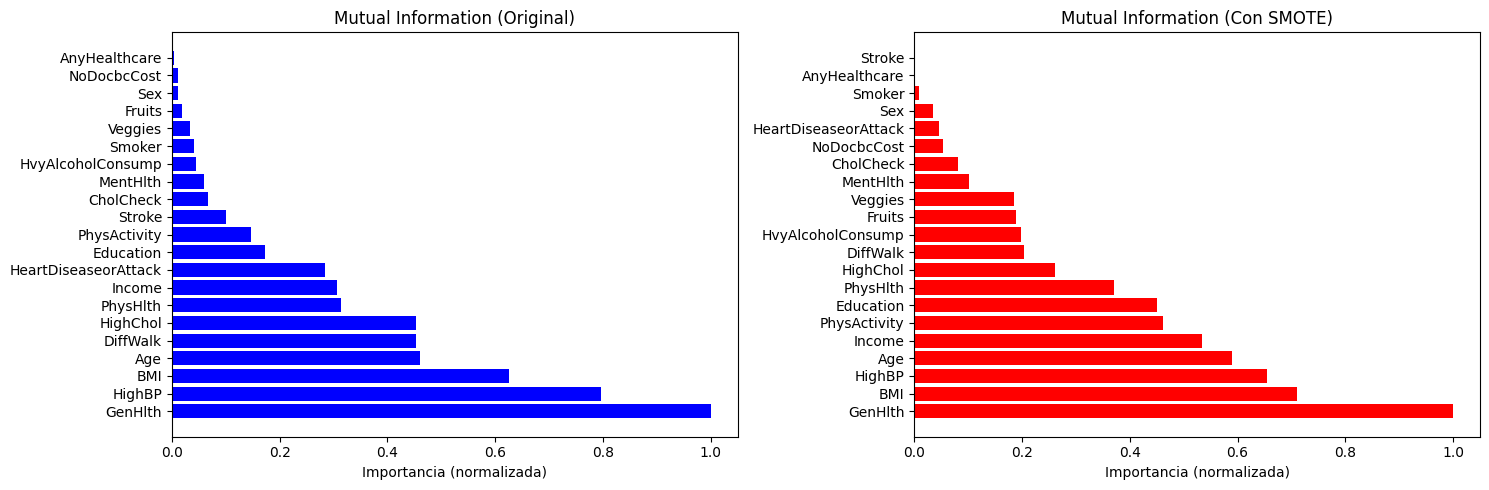

                      Original         SMOTE
Age                   0.461564  5.900373e-01
AnyHealthcare         0.003162  8.047045e-04
BMI                   0.626574  7.093766e-01
CholCheck             0.067869  8.013525e-02
DiffWalk              0.453632  2.035805e-01
Education             0.172791  4.501395e-01
Fruits                0.018651  1.884417e-01
GenHlth               1.000000  1.000000e+00
HeartDiseaseorAttack  0.284593  4.527577e-02
HighBP                0.796362  6.540194e-01
HighChol              0.453215  2.610833e-01
HvyAlcoholConsump     0.045374  1.987966e-01
Income                0.306589  5.338270e-01
MentHlth              0.059504  1.009023e-01
NoDocbcCost           0.010589  5.318546e-02
PhysActivity          0.146907  4.614863e-01
PhysHlth              0.314847  3.710049e-01
Sex                   0.011188  3.471081e-02
Smoker                0.041767  8.438318e-03
Stroke                0.100518  3.771327e-07
Veggies               0.034455  1.848042e-01


In [ ]:
# 1️⃣ Aplicar SMOTE para balancear el target antes del cálculo de MI
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, Y.Diabetes_binary)

# 2️⃣ Definir función para calcular información mutua sin modificar cada variable individualmente
def calculate_mutual_info(X, y, random_state=42):
    """
    Calcula la información mutua entre cada variable en X y el target y sin modificar las variables individualmente.
    """
    return mutual_info_classif(X, y, discrete_features=True, random_state=random_state)

# 3️⃣ Calcular información mutua en el dataset original (sin balancear)
mi_original = calculate_mutual_info(X, Y.Diabetes_binary)

# 4️⃣ Calcular información mutua en el dataset balanceado con SMOTE
mi_smote = calculate_mutual_info(X_smote, y_smote)

# 5️⃣ Crear DataFrames con los resultados
mi_series_original = pd.Series(mi_original, index=X.columns).sort_values(ascending=False)
mi_series_smote = pd.Series(mi_smote, index=X_smote.columns).sort_values(ascending=False)

# Normalizar ambas series para comparación
mi_series_original /= mi_series_original.max()
mi_series_smote /= mi_series_smote.max()

# 6️⃣ Visualización comparativa de Mutual Information antes y después de SMOTE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Mutual Information en el dataset original
axes[0].barh(mi_series_original.index, mi_series_original, color="blue")
axes[0].set_title("Mutual Information (Original)")
axes[0].set_xlabel("Importancia (normalizada)")

# Gráfico de Mutual Information en el dataset balanceado con SMOTE
axes[1].barh(mi_series_smote.index, mi_series_smote, color="red")
axes[1].set_title("Mutual Information (Con SMOTE)")
axes[1].set_xlabel("Importancia (normalizada)")

plt.tight_layout()
plt.show()

# Comparar valores numéricamente
mi_comparison = pd.DataFrame({"Original": mi_series_original, "SMOTE": mi_series_smote})
print(mi_comparison)

habría que comentar la capacidad predictiva del modelo con variables que representan objetividad como GenHealth....

### Correlación de pearson
No es la mejor opción dado que la mayoría de variables son categóricas.

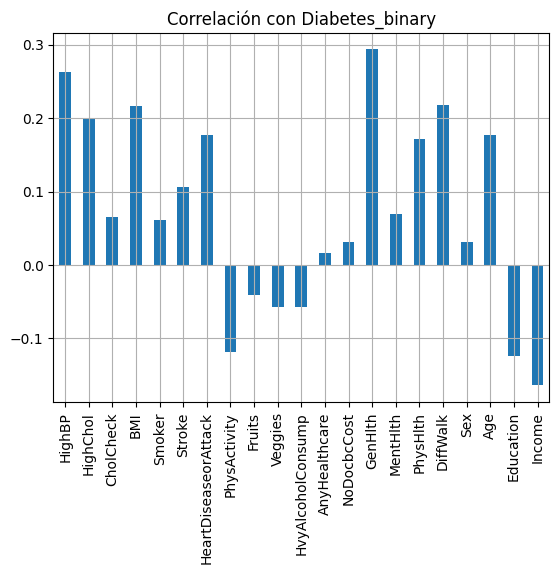

In [ ]:
X.corrwith(Y.Diabetes_binary).plot(kind='bar', grid=True, title="Correlación con Diabetes_binary");

# 2. Preprocesamiento


## Eliminación de variables

* Estas variables tienen información mutua extremadamente baja en ambos escenarios, lo que indica que no aportan valor predictivo al modelo.
 * **AnyHealthcare**
 * **Sex**
 * **Smoker**
 * **Stroke**
 * **NoDocbcCost**
* Estas variables están correlacionadas con otras.
 * **DiffWalk** (fuertemente correlacionado con GenHlth)
 * **PhysHlth** (fuertemente correlacionado con GenHlth)

In [7]:
# variables definitivas
# Definir las variables a eliminar
deleted_vars = [
    "AnyHealthcare",
    "Sex",
    "NoDocbcCost",
    "Smoker",
    "Stroke",
    "PhysHlth",
    "DiffWalk",
]

# Crear las nuevas X e Y
X_filtered = X.drop(columns=deleted_vars)
Y_filtered = Y.copy()  # No modificamos la variable objetivo

# Actualizar las listas de variables después de la eliminación
numerical_columns_filtered = [col for col in numerical_columns if col not in deleted_vars]
categorical_columns_filtered = [col for col in categorical_columns if col not in deleted_vars]
categorical_nonbinary_columns_filtered = [col for col in categorical_nonbinary_columns if col not in deleted_vars]
categorical_binary_columns_filtered = [col for col in categorical_binary_columns if col not in deleted_vars]

# Imprimir las nuevas listas de variables
print("Variables numéricas:", numerical_columns_filtered)
print("Variables categóricas:", categorical_columns_filtered)
print("Variables categóricas no binarias:", categorical_nonbinary_columns_filtered)
print("Variables categóricas binarias:", categorical_binary_columns_filtered)


Variables numéricas: ['BMI', 'MentHlth']
Variables categóricas: ['HighBP', 'HighChol', 'CholCheck', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'Age', 'Education', 'Income']
Variables categóricas no binarias: ['GenHlth', 'Age', 'Education', 'Income']
Variables categóricas binarias: ['HighBP', 'HighChol', 'CholCheck', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump']


## Tratamiento de Outliers y categorización (BMI)
Segun ([fuente](https://www.nhs.uk/conditions/obesity/)):
* Underweight: Below 18.5
* Normal weight: 18.5–24.9
* Pre-obesity: 25.0–29.9
* Obesity class I: 30.0–34.9
* Obesity class II: 35.0–39.9
* Obesity class III: Above 40


Como físicamente creemos que es posible tener un BMI mucho mayor que 40 (p.ej. teniendo una baja estatura y un peso muy elevado), concluimos que vamos a categorizar la variable y no eliminar ninguna fila del dataset.

In [8]:
# Definir los intervalos y etiquetas de clasificación de BMI
bmi_bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf]  # np.inf representa valores mayores a 40
bmi_labels = ["Underweight", "Normal weight", "Pre-obesity", "Obesity class I", "Obesity class II", "Obesity class III"]

# Crear una nueva columna categórica para BMI
X_filtered["BMI"] = pd.cut(X_filtered["BMI"], bins=bmi_bins, labels=bmi_labels, right=True).cat.codes.astype("int64")

# Actualizar las listas de variables categóricas y numéricas
categorical_columns_filtered.append("BMI")
categorical_nonbinary_columns_filtered.append("BMI")  # Ahora es categórica con más de 2 niveles

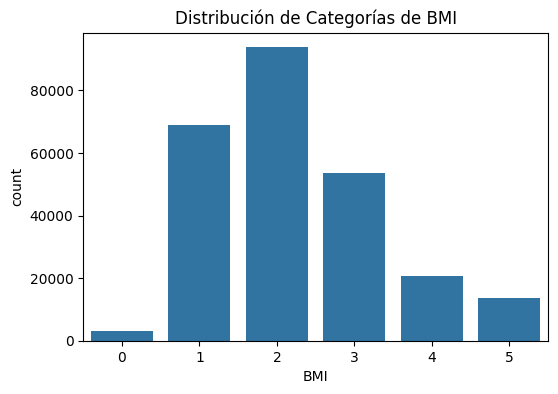

In [9]:
plt.figure(figsize=(6,4))
sns.countplot(x=X_filtered['BMI'])
plt.title("Distribución de Categorías de BMI")
plt.show()

## Train-test split

In [10]:
# División en 80% train - 20% test con estratificación del target
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, Y_filtered, test_size=0.2, random_state=42, stratify=Y_filtered
)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Verificar tamaños de los conjuntos
print("Tamaño de X_train_nofilter:", X_train_filtered.shape)
print("Tamaño de X_test_nofilter:", X_test_filtered.shape)
print("Distribución del target en entrenamiento:\n", y_train.value_counts(normalize=True))
print("Distribución del target en prueba:\n", y_test.value_counts(normalize=True))

print("Tamaño de X_train:", X_train.shape)
print("Tamaño de X_test:", X_test.shape)
print("Distribución del target en entrenamiento:\n", y_train.value_counts(normalize=True))
print("Distribución del target en prueba:\n", y_test.value_counts(normalize=True))


Tamaño de X_train_nofilter: (202944, 14)
Tamaño de X_test_nofilter: (50736, 14)
Distribución del target en entrenamiento:
 Diabetes_binary
0                  0.860666
1                  0.139334
Name: proportion, dtype: float64
Distribución del target en prueba:
 Diabetes_binary
0                  0.860671
1                  0.139329
Name: proportion, dtype: float64
Tamaño de X_train: (202944, 21)
Tamaño de X_test: (50736, 21)
Distribución del target en entrenamiento:
 Diabetes_binary
0                  0.860666
1                  0.139334
Name: proportion, dtype: float64
Distribución del target en prueba:
 Diabetes_binary
0                  0.860671
1                  0.139329
Name: proportion, dtype: float64


# 3. Implementación de modelos predictivos
* búsqueda de hiperparámetros: RandomizedSearchCV (RandCV) u Optuna (Opt)
* balanceo de clases: class_weight (wght), oversampling (ov) o undersampling (un)
* atributos: todos (all), selección manual (man_sel), selección automática (aut_sel) o reducción de dimensionalidad (red_dim)

En lugar de evaluar exhaustivamente las 24 combinaciones que surgen al cruzar estas tres dimensiones (método de búsqueda de hiperparámetros, técnica de balanceo de clases y transformación de atributos), se divide el proceso en dos fases, reduciendo así el número total de pruebas a 10. Esto se explica de la siguiente manera:

**Fase 1: Tuning del modelo**

En esta fase se evalúan exclusivamente las combinaciones de métodos que afectan directamente el desempeño del modelo, es decir, se cruzan los dos métodos de búsqueda de hiperparámetros (RandomizedSearchCV y Optuna) con las tres técnicas de balanceo de clases (balanced_weight, oversampling con SMOTE y undersampling). Esto genera 6 *combinaciones*. La finalidad es identificar cuál de estas estrategias produce el mejor desempeño (medido en AUC) sin considerar aún las distintas formas de tratar o transformar los atributos.

**Fase 2: Tuning de datos**

Una vez que se ha determinado la combinación óptima en cuanto a búsqueda y balanceo de clases, se mantiene esa configuración y se prueba junto con las cuatro técnicas de transformación de atributos (usar todas, selección manual, selección automática o reducción de dimensionalidad). De esta forma, se generan 4 *configuraciones* finales sobre los que se evaluará el desempeño final del *modelo* seleccionado.

**ACLARACIÓN**: 
* Opt + ov será una *combinación*
* Opt + ov + aut_sel será una *configuración*
* Logistic Classifier es un *modelo*

## Funciones auxiliares

### Núcleos

In [11]:
import multiprocessing
print("Núcleos disponibles:", multiprocessing.cpu_count())

Núcleos disponibles: 16


In [12]:
n_jobs = 7  # Número de núcleos a utilizar

### Estrategia de validación

In [13]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

### Métricas

Acerca de las dos medidas de AUC:
* **roc_auc_score en el conjunto de test (auc)** evalúa el modelo en un conjunto independiente, generalmente reservado para la evaluación final. Proporciona una única estimación del rendimiento (AUC) en datos nuevos.
* **Media de cv_scores (cv_mean)** se obtiene mediante la validación cruzada en el conjunto de entrenamiento. Permite obtener una medida de robustez y estabilidad del rendimiento, ya que se calcula en distintas particiones.

Ambos valores son importantes: el AUC sobre el conjunto de test indica cómo se espera que se comporte el modelo en producción, mientras que la media de AUC en CV y su desviación ofrecen información sobre la consistencia del modelo y su sensibilidad a la partición de los datos.

In [14]:
def evaluate_and_return_metrics(best_estimator, X_test, y_test, execution_time, best_params, cv_scores, threshold=0.5):
    """
    Evalúa el modelo y muestra las métricas de desempeño, devolviendo un diccionario con las métricas.
    
    Parámetros:
      best_estimator: modelo ajustado obtenido de RandomizedSearchCV.
      X_test: datos de prueba.
      y_test: etiquetas verdaderas de prueba.
      execution_time: tiempo de ejecución en minutos.
      best_params: diccionario de mejores hiperparámetros.
      cv_scores: array de scores obtenido de cross_val_score.
      threshold: umbral de decisión para convertir probabilidades en etiquetas (por defecto 0.5).
    
    Returns:
      metrics_dict: Diccionario con las métricas AUC, Accuracy, Recall, Precision, matriz de confusión,
                    las probabilidades predichas, el tiempo de ejecución, la media y la desviación estándar
                    de los scores obtenidos con cross_val_score y el array de scores.
    """
    
    # Obtener las probabilidades para la clase positiva
    y_pred_proba = best_estimator.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    print("Execution time: {:.2f} minutes".format(execution_time))
    print("Best Parameters:", best_params)
    print("Threshold:", threshold)
    print("AUC: {:.4f}".format(auc))
    print("Accuracy: {:.4f}".format(accuracy))
    print("Recall: {:.4f}".format(recall))
    print("Precision: {:.4f}".format(precision))
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Cross-Validation AUC: Mean = {:.4f}, Std = {:.4f}".format(cv_mean, cv_std))
    
    metrics_dict = {
        'auc': auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'conf_matrix': conf_matrix,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'execution_time': execution_time,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'cv_scores': cv_scores
    }
    
    return metrics_dict

### Ploteo de resultados

In [15]:
def plot_results(model_results):
    """
    Plotea:
      1. Una tabla resumen con las métricas.
      2. Las curvas ROC de todos los modelos.
      3. Las matrices de confusión en una grilla que se adapta al número de modelos.

    Se asume que:
      - Cada diccionario en model_results contiene:
            "model": nombre del modelo.
            "auc": AUC del modelo.
            "accuracy": Accuracy.
            "recall": Recall.
            "precision": Precision.
            "execution_time": Tiempo de ejecución.
            "y_pred_proba": Array de probabilidades predichas.
            "conf_matrix": Matriz de confusión.
            "cv_mean": Media de los scores obtenidos con cross_val_score.
            "cv_std": Desviación estándar de los scores obtenidos con cross_val_score.
            "cv_scores": Array de scores obtenidos con cross_val_score.
    """

    # ----------------------------------------------------------------------------
    # 1. Crear y mostrar la tabla resumen
    # ----------------------------------------------------------------------------
    summary_data = {
        "Model": [res["model"] for res in model_results],
        "AUC": [res["auc"] for res in model_results],
        "Accuracy": [res["accuracy"] for res in model_results],
        "Recall": [res["recall"] for res in model_results],
        "Precision": [res["precision"] for res in model_results],
        "Score Mean": [res["cv_mean"] for res in model_results],
        "Score Std": [res["cv_std"] for res in model_results],
        "Execution Time (minutes)": [res["execution_time"] for res in model_results]
    }
    summary_df = pd.DataFrame(summary_data)
    print("Summary Table:")
    display(summary_df)

    # ----------------------------------------------------------------------------
    # 2. Plotear las matrices de confusión en una grilla responsiva,
    #    mostrando valores absolutos, porcentaje respecto a la fila y porcentaje respecto a la columna.
    # ----------------------------------------------------------------------------
    n_models = len(model_results)
    n_cols = min(n_models, 3)
    n_rows = math.ceil(n_models / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))

    # Asegurarse de que axs sea una lista (en caso de un solo subplot)
    if n_models == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for i, res in enumerate(model_results):
        cm = res["conf_matrix"]
        # Crear un array de anotaciones que incluya valor absoluto, % respecto a la fila y % respecto a la columna
        annot_matrix = []
        for row in range(cm.shape[0]):
            annot_row = []
            row_sum = cm[row, :].sum()
            for col in range(cm.shape[1]):
                col_sum = cm[:, col].sum()
                row_pct = (cm[row, col] / row_sum * 100) if row_sum > 0 else 0
                col_pct = (cm[row, col] / col_sum * 100) if col_sum > 0 else 0
                annot_row.append(f"{cm[row, col]:.0f}\n{row_pct:.1f}% (row)\n{col_pct:.1f}% (col)")
            annot_matrix.append(annot_row)
        
        sns.heatmap(cm, annot=annot_matrix, fmt="", cmap='Blues', ax=axs[i],
                    xticklabels=['Predicted Negative', 'Predicted Positive'],
                    yticklabels=['Actual Negative', 'Actual Positive'])
        axs[i].set_title(res["model"])
        axs[i].set_ylabel('Actual')
        axs[i].set_xlabel('Predicted')

    # Ocultar subplots sobrantes, si existen.
    for j in range(i+1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()

### Estadísticos

In [16]:
def perform_stat_tests(cv_scores):
    """
    Recibe un diccionario con arrays de scores de validación cruzada y devuelve:
      - df_friedman: DataFrame con el estadístico y p-value del test de Friedman.
      - df_wilcoxon: DataFrame con las comparaciones par a par (Wilcoxon) y p-values ajustados.
      - df_kruskal: DataFrame con el estadístico y p-value del test de Kruskal-Wallis.
      - df_mannwhitney: DataFrame con las comparaciones par a par (Mann-Whitney U) y p-values ajustados.
    
    Parameters:
      cv_scores (dict): Diccionario donde las claves son los nombres de los modelos y
                        los valores son arrays de scores obtenidos en CV.
                        
    Returns:
      df_friedman (DataFrame), df_wilcoxon (DataFrame), df_kruskal (DataFrame), df_mannwhitney (DataFrame)
    """
    # ------------------------------
    # Test de Friedman (para muestras relacionadas)
    # ------------------------------
    friedman_stat, friedman_p_value = friedmanchisquare(*[scores for scores in cv_scores.values()])
    df_friedman = pd.DataFrame({
        'Estadístico Friedman': [friedman_stat],
        'p-value': [friedman_p_value]
    })
    
    # ------------------------------
    # Test de Wilcoxon par a par (para muestras emparejadas) con corrección de Bonferroni
    # ------------------------------
    wilcoxon_results = []
    n_models = len(cv_scores)
    n_comparaciones = n_models * (n_models - 1) / 2
    for (nombre1, scores1), (nombre2, scores2) in itertools.combinations(cv_scores.items(), 2):
        stat, p_value = wilcoxon(scores1, scores2, alternative='greater', zero_method='wilcox')
        p_value_adj = min(p_value * n_comparaciones, 1.0)
        wilcoxon_results.append({
            'Primer Modelo': nombre1,
            'Segundo Modelo': nombre2,
            'Wilcox V': stat,
            'p-value original': p_value,
            'p-value ajustado': p_value_adj
        })
    df_wilcoxon = pd.DataFrame(wilcoxon_results)
    
    # ------------------------------
    # Test de Kruskal-Wallis (para comparar más de dos grupos independientes)
    # ------------------------------
    kruskal_stat, kruskal_p_value = kruskal(*[scores for scores in cv_scores.values()])
    df_kruskal = pd.DataFrame({
        'Estadístico Kruskal-Wallis': [kruskal_stat],
        'p-value': [kruskal_p_value]
    })
    
    # ------------------------------
    # Test de Mann-Whitney U par a par (para muestras independientes) con corrección de Bonferroni
    # Nota: Aunque Mann-Whitney U está diseñado para muestras independientes, se incluye como prueba
    # complementaria a Wilcoxon para corroborar las diferencias entre pares.
    # ------------------------------
    mannwhitney_results = []
    for (nombre1, scores1), (nombre2, scores2) in itertools.combinations(cv_scores.items(), 2):
        stat, p_value = mannwhitneyu(scores1, scores2, alternative='greater')
        p_value_adj = min(p_value * n_comparaciones, 1.0)
        mannwhitney_results.append({
            'Primer Modelo': nombre1,
            'Segundo Modelo': nombre2,
            'U': stat,
            'p-value original': p_value,
            'p-value ajustado': p_value_adj
        })
    df_mannwhitney = pd.DataFrame(mannwhitney_results)
    
    # Mostrar resultados
    print("Resultados del Test de Friedman:")
    print(df_friedman.to_string(index=False))
    print("\nResultados del Test de Wilcoxon:")
    print(df_wilcoxon.to_string(index=False))
    print("\nResultados del Test de Kruskal-Wallis:")
    print(df_kruskal.to_string(index=False))
    print("\nResultados del Test de Mann-Whitney U:")
    print(df_mannwhitney.to_string(index=False))

### Maximize F1 score

In [17]:
def maximize_f1_score(model, X_train, y_train):
    model.fit(X_train, y_train)

    # 1. Obtener las probabilidades de predicción para la clase positiva (índice 1)
    y_prob = model.predict_proba(X_test)

    # 2. Evaluar diferentes umbrales para optimizar el F1-score
    thresholds = np.arange(0.0, 1.0, 0.01)
    f1_scores = []

    for thresh in thresholds:
        # Convertir probabilidades a predicciones binarias usando el umbral actual
        y_pred = (y_prob[:, 1] >= thresh).astype(int)
        score = f1_score(y_test, y_pred)
        f1_scores.append(score)

    # Seleccionar el umbral óptimo que maximiza el F1-score
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print("El umbral óptimo es:", optimal_threshold)

    # 3. Graficar el F1-score en función del umbral
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, f1_scores, marker='o')
    plt.xlabel('Umbral de decisión')
    plt.ylabel('F1 Score')
    plt.title('Optimización del Umbral - F1 Score')
    plt.grid(True)
    plt.show()

    return optimal_threshold

### SHAP

In [18]:
def plot_shap (model, X_train, X_test):
    """
    Plotea los valores SHAP para un modelo dado.
    
    Parameters:
      model: modelo entrenado.
      X_train: datos de entrenamiento..
      X_test: datos de prueba.
    """
    # Inicializar el explainer para modelos lineales utilizando LinearExplainer
    explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_test)

    # -----------------------
    # Visualizaciones básicas con SHAP

    # a) Force plot para explicar una predicción individual (usa la versión estática)
    shap.initjs()  # Inicializa las visualizaciones interactivas, aunque en VS Code se recomienda la opción estática
    force_plot = shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :], matplotlib=True)
    plt.show()

    # b) Summary plot para ver la importancia global de las características
    shap.summary_plot(shap_values, X_test)
    plt.show()

    # -----------------------
    # Visualizaciones avanzadas

    # a) Waterfall plot para explicar en detalle una predicción individual
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0, :],
        base_values=explainer.expected_value,
        data=X_test.iloc[0, :],
        feature_names=X_test.columns.tolist()
    ))
    plt.show()

    # b) Decision plot para visualizar cómo se suma la contribución de cada característica
    shap.decision_plot(explainer.expected_value, shap_values, X_test, ignore_warnings=True)
    plt.show()

    # -----------------------
    # Evaluación de la estabilidad de las predicciones
    # Calcular la varianza de los SHAP values para cada característica y observar su dispersión
    shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
    shap_variance = shap_df.var().sort_values(ascending=False)
    print("Varianza de los valores SHAP por característica:")
    print(shap_variance)

### TreeSHAP

In [19]:
def plot_shap_tree(model, X_train, X_test):
    """
    Plotea los valores SHAP utilizando TreeExplainer para modelos basados en árboles.
    
    Parameters:
      model: modelo de árbol ya entrenado (ej. RandomForestClassifier, XGBoost, LightGBM).
      X_train: datos de entrenamiento (para calcular el background).
      X_test: datos de prueba sobre los cuales se evaluarán y visualizarán los SHAP values.
    """
    # Inicializar el TreeExplainer
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)

    # Para modelos de clasificación binaria, TreeExplainer devuelve una lista de arrays.
    # Usaremos las contribuciones para la clase positiva (índice 1)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]
        # También actualizamos el expected value (base value) a la de la clase positiva.
        base_value = explainer.expected_value[1]
    else:
        base_value = explainer.expected_value

    # -----------------------
    # Visualizaciones básicas con SHAP

    # a) Force plot para explicar una predicción individual (versión estática para entornos sin JS)
    shap.initjs()  # Inicializa las visualizaciones interactivas (si usas un entorno que lo soporte)
    force_plot = shap.force_plot(base_value, shap_values[0, :], X_test.iloc[0, :], matplotlib=True)
    plt.show()

    # b) Summary plot para ver la importancia global de las características
    shap.summary_plot(shap_values, X_test)
    plt.show()

    # -----------------------
    # Visualizaciones avanzadas

    # a) Waterfall plot para explicar en detalle una predicción individual
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[0, :],
        base_values=base_value,
        data=X_test.iloc[0, :],
        feature_names=X_test.columns.tolist()
    ))
    plt.show()

    # b) Decision plot para visualizar la suma acumulativa de las contribuciones
    shap.decision_plot(base_value, shap_values, X_test, ignore_warnings=True)
    plt.show()

    # -----------------------
    # Evaluación de la estabilidad de las predicciones
    # Calcular la varianza de los SHAP values para cada característica
    shap_df = pd.DataFrame(shap_values, columns=X_test.columns)
    shap_variance = shap_df.var().sort_values(ascending=False)
    print("Varianza de los valores SHAP por característica:")
    print(shap_variance)

## Dummy Classifier

In [20]:
model = DummyClassifier(strategy="most_frequent", random_state=42)
start_time = time.time()
model.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_dummy = evaluate_and_return_metrics(model, X_test_filtered, y_test_filtered, execution_time, {"strategy": "most_frequent"}, cv_scores)

del model, start_time, end_time, execution_time, cv_scores

Execution time: 0.00 minutes
Best Parameters: {'strategy': 'most_frequent'}
Threshold: 0.5
AUC: 0.5000
Accuracy: 0.8607
Recall: 0.0000
Precision: 0.0000
Confusion Matrix:
[[43667     0]
 [ 7069     0]]
Cross-Validation AUC: Mean = 0.5000, Std = 0.0000


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Logistic Regression
Modelo base

### Fase 1: tuning del modelo

#### Combinación 1: RandomizedSearchCV + Undersampling

In [ ]:
param_distributions = {
    'clf_lr__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf_lr__penalty': ['l1', 'l2']
}

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_un = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 0.94 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.8187
Accuracy: 0.7308
Recall: 0.7621
Precision: 0.3103
Confusion Matrix:
[[31693 11974]
 [ 1682  5387]]
Cross-Validation AUC: Mean = 0.8228, Std = 0.0029


#### Combinación 2: RandomizedSearchCV + Oversampling

In [50]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_ov = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 2.25 minutes
Best Parameters: {'clf_lr__penalty': 'l1', 'clf_lr__C': 0.001}
AUC: 0.8132
Accuracy: 0.7189
Recall: 0.7728
Precision: 0.3015
Confusion Matrix:
[[31011 12656]
 [ 1606  5463]]
Cross-Validation AUC: Mean = 0.8177, Std = 0.0029


#### Combinación 3: RandomizedSearchCV + class_weight

In [46]:
pipeline = ImbPipeline([
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000, class_weight='balanced'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_wght = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_,cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 1.22 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.8187
Accuracy: 0.7315
Recall: 0.7638
Precision: 0.3111
Confusion Matrix:
[[31712 11955]
 [ 1670  5399]]
Cross-Validation AUC: Mean = 0.8229, Std = 0.0029


#### Combinación 4: Optuna + Undersampling

In [47]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    max_iter=1000,
    random_state=42)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_un = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 09:00:19,599] A new study created in memory with name: no-name-f00d1242-7241-4782-b090-4c0e20d0508d
[I 2025-04-10 09:00:24,523] Trial 0 finished with value: 0.8228217061699269 and parameters: {'C': 10.647189989696367, 'penalty': 'l1'}. Best is trial 0 with value: 0.8228217061699269.
[I 2025-04-10 09:00:29,402] Trial 1 finished with value: 0.8228217709534684 and parameters: {'C': 15.253665971591957, 'penalty': 'l1'}. Best is trial 1 with value: 0.8228217709534684.
[I 2025-04-10 09:00:31,051] Trial 2 finished with value: 0.817296883790832 and parameters: {'C': 0.0015099785053579425, 'penalty': 'l1'}. Best is trial 1 with value: 0.8228217709534684.
[I 2025-04-10 09:00:36,051] Trial 3 finished with value: 0.8228216940453279 and parameters: {'C': 5.835131090875189, 'penalty': 'l1'}. Best is trial 1 with value: 0.8228217709534684.
[I 2025-04-10 09:00:41,034] Trial 4 finished with value: 0.822821720326305 and parameters: {'C': 12.258851555597815, 'penalty': 'l1'}. Best is trial 

Execution time: 0.85 minutes
Best Parameters: {'C': 0.10829700409423945, 'penalty': 'l2'}
AUC: 0.8187
Accuracy: 0.7309
Recall: 0.7621
Precision: 0.3103
Confusion Matrix:
[[31694 11973]
 [ 1682  5387]]
Cross-Validation AUC: Mean = 0.8228, Std = 0.0029


#### Combinación 5: Optuna + Oversampling

In [48]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    max_iter=1000,
    random_state=42)
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_ov = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 09:01:16,879] A new study created in memory with name: no-name-3c3f40d3-98cc-4137-93a6-4807b2ccd707
[I 2025-04-10 09:01:32,582] Trial 0 finished with value: 0.8137744604097342 and parameters: {'C': 5.145341509524655, 'penalty': 'l2'}. Best is trial 0 with value: 0.8137744604097342.
[I 2025-04-10 09:01:44,537] Trial 1 finished with value: 0.8170477026876888 and parameters: {'C': 0.001731867454465322, 'penalty': 'l1'}. Best is trial 1 with value: 0.8170477026876888.
[I 2025-04-10 09:01:56,166] Trial 2 finished with value: 0.8137747337387446 and parameters: {'C': 4.683793023165876, 'penalty': 'l2'}. Best is trial 1 with value: 0.8170477026876888.
[I 2025-04-10 09:02:08,070] Trial 3 finished with value: 0.8146347104180285 and parameters: {'C': 0.010779396782922104, 'penalty': 'l2'}. Best is trial 1 with value: 0.8170477026876888.
[I 2025-04-10 09:02:19,272] Trial 4 finished with value: 0.8137727475098429 and parameters: {'C': 35.258420692840936, 'penalty': 'l2'}. Best is tria

Execution time: 2.59 minutes
Best Parameters: {'C': 0.0012021005061161115, 'penalty': 'l1'}
AUC: 0.8130
Accuracy: 0.7192
Recall: 0.7722
Precision: 0.3017
Confusion Matrix:
[[31031 12636]
 [ 1610  5459]]
Cross-Validation AUC: Mean = 0.8176, Std = 0.0029


#### Combinación 6: Optuna + class_weight

In [49]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = Pipeline([
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', class_weight='balanced', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42)
pipeline = Pipeline([
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_wght = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 09:04:10,896] A new study created in memory with name: no-name-b3116fc4-d8d5-4061-ba22-7046074307cf
[I 2025-04-10 09:04:17,220] Trial 0 finished with value: 0.8228677315910925 and parameters: {'C': 0.057208780919961455, 'penalty': 'l2'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:23,986] Trial 1 finished with value: 0.8228615817352228 and parameters: {'C': 0.1474076503244596, 'penalty': 'l1'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:31,053] Trial 2 finished with value: 0.8228621049832123 and parameters: {'C': 8.828737865038923, 'penalty': 'l1'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:38,437] Trial 3 finished with value: 0.8228622406241785 and parameters: {'C': 145.903103334051, 'penalty': 'l2'}. Best is trial 0 with value: 0.8228677315910925.
[I 2025-04-10 09:04:46,386] Trial 4 finished with value: 0.8228621637808091 and parameters: {'C': 0.27523156010536143, 'penalty': 'l1'}. Best is trial 

Execution time: 1.44 minutes
Best Parameters: {'C': 0.057208780919961455, 'penalty': 'l2'}
AUC: 0.8187
Accuracy: 0.7315
Recall: 0.7638
Precision: 0.3111
Confusion Matrix:
[[31714 11953]
 [ 1670  5399]]
Cross-Validation AUC: Mean = 0.8229, Std = 0.0029


#### Combinación 7: RandomizedSearchCV + Undersampling + Oversampling

In [40]:
pipeline = ImbPipeline([
    ('balance', SMOTEENN(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_un_ov = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 45.29 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.01}
AUC: 0.8050
Accuracy: 0.7338
Recall: 0.7281
Precision: 0.3077
Confusion Matrix:
[[32085 11582]
 [ 1922  5147]]
Cross-Validation AUC: Mean = 0.8084, Std = 0.0028


#### Combinación 8: RandomizedSearchCV + Undersampling + Oversampling + class_weight

In [41]:
pipeline = ImbPipeline([
    ('balance', SMOTEENN(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', class_weight='balanced', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_un_ov_wght = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 44.84 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.01}
AUC: 0.8048
Accuracy: 0.7191
Recall: 0.7489
Precision: 0.2979
Confusion Matrix:
[[31192 12475]
 [ 1775  5294]]
Cross-Validation AUC: Mean = 0.8082, Std = 0.0028


#### Combination 9: RandomizedSearchCV + Undersampling + class_weight

In [22]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', class_weight='balanced', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=12, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_randcv_un_wght = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 0.63 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
Threshold: 0.5
AUC: 0.8187
Accuracy: 0.7308
Recall: 0.7621
Precision: 0.3103
Confusion Matrix:
[[31693 11974]
 [ 1682  5387]]
Cross-Validation AUC: Mean = 0.8228, Std = 0.0029


#### Combination 10: Optuna + Undersampling + Oversampling

In [30]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = ImbPipeline([
        ('balance', SMOTEENN(random_state=42)),
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    max_iter=1000,
    random_state=42)
pipeline = ImbPipeline([
    ('balance', SMOTEENN(random_state=42)),
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_un_ov = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 18:04:42,940] A new study created in memory with name: no-name-ddf51337-f016-4960-95ea-24730971ea76
[I 2025-04-10 18:09:45,920] Trial 0 finished with value: 0.8082122815604853 and parameters: {'C': 2.9657986731026784, 'penalty': 'l1'}. Best is trial 0 with value: 0.8082122815604853.
[I 2025-04-10 18:14:01,620] Trial 1 finished with value: 0.8082278798132456 and parameters: {'C': 0.35640554822414505, 'penalty': 'l2'}. Best is trial 1 with value: 0.8082278798132456.
[I 2025-04-10 18:18:17,384] Trial 2 finished with value: 0.808211728744963 and parameters: {'C': 117.58302326938085, 'penalty': 'l2'}. Best is trial 1 with value: 0.8082278798132456.
[I 2025-04-10 18:22:36,735] Trial 3 finished with value: 0.808211717613001 and parameters: {'C': 187.02197976535908, 'penalty': 'l2'}. Best is trial 1 with value: 0.8082278798132456.
[I 2025-04-10 18:27:00,903] Trial 4 finished with value: 0.8083065694495591 and parameters: {'C': 0.009335746906935343, 'penalty': 'l1'}. Best is trial

Execution time: 52.28 minutes
Best Parameters: {'C': 0.009335746906935343, 'penalty': 'l1'}
Threshold: 0.5
AUC: 0.8048
Accuracy: 0.7336
Recall: 0.7283
Precision: 0.3075
Confusion Matrix:
[[32074 11593]
 [ 1921  5148]]
Cross-Validation AUC: Mean = 0.8083, Std = 0.0029


#### Combination 11: Optuna + Undersampling + Oversampling + class_weight

In [31]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = ImbPipeline([
        ('balance', SMOTEENN(random_state=42)),
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', class_weight='balanced', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42)
pipeline = ImbPipeline([
    ('balance', SMOTEENN(random_state=42)),
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_un_ov_wght = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 19:03:45,530] A new study created in memory with name: no-name-b5b91550-1398-426e-8a50-f24146317f09
[I 2025-04-10 19:08:16,625] Trial 0 finished with value: 0.8081418371881994 and parameters: {'C': 0.03467963709924885, 'penalty': 'l2'}. Best is trial 0 with value: 0.8081418371881994.
[I 2025-04-10 19:12:38,340] Trial 1 finished with value: 0.80807432313602 and parameters: {'C': 0.09814332195510071, 'penalty': 'l2'}. Best is trial 0 with value: 0.8081418371881994.
[I 2025-04-10 19:17:08,058] Trial 2 finished with value: 0.8081055079420896 and parameters: {'C': 0.012592061618216733, 'penalty': 'l1'}. Best is trial 0 with value: 0.8081418371881994.
[I 2025-04-10 19:21:31,592] Trial 3 finished with value: 0.808022498839431 and parameters: {'C': 7.962998283702566, 'penalty': 'l1'}. Best is trial 0 with value: 0.8081418371881994.
[I 2025-04-10 19:25:52,639] Trial 4 finished with value: 0.8080635564040326 and parameters: {'C': 0.03566781072206584, 'penalty': 'l1'}. Best is trial

Execution time: 52.64 minutes
Best Parameters: {'C': 0.005212380193655077, 'penalty': 'l2'}
Threshold: 0.5
AUC: 0.8048
Accuracy: 0.7189
Recall: 0.7506
Precision: 0.2980
Confusion Matrix:
[[31170 12497]
 [ 1763  5306]]
Cross-Validation AUC: Mean = 0.8082, Std = 0.0028


#### Combination 12: Optuna + Undersampling + class_weight

In [32]:
def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_lr', LogisticRegression(C=C, penalty=penalty, solver='saga', class_weight='balanced', max_iter=1000, random_state=42))
    ])
    score = cross_val_score(pipeline, X_train_filtered, y_train_filtered, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=12)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver='saga',
    class_weight='balanced',
    max_iter=1000,
    random_state=42)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', best_model)
])
pipeline.fit(X_train_filtered, y_train_filtered)

cv_scores = cross_val_score(pipeline, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_opt_un_wght = evaluate_and_return_metrics(pipeline, X_test_filtered, y_test_filtered, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-10 20:02:39,550] A new study created in memory with name: no-name-6551db34-1157-4bd4-b464-06bf2d008362
[I 2025-04-10 20:02:42,999] Trial 0 finished with value: 0.82282812453125 and parameters: {'C': 0.11956249154983753, 'penalty': 'l2'}. Best is trial 0 with value: 0.82282812453125.
[I 2025-04-10 20:02:46,949] Trial 1 finished with value: 0.8228214996913803 and parameters: {'C': 2.4126942370029916, 'penalty': 'l1'}. Best is trial 0 with value: 0.82282812453125.
[I 2025-04-10 20:02:50,863] Trial 2 finished with value: 0.822821729446129 and parameters: {'C': 14.64988483353668, 'penalty': 'l1'}. Best is trial 0 with value: 0.82282812453125.
[I 2025-04-10 20:02:54,168] Trial 3 finished with value: 0.8222815343411689 and parameters: {'C': 0.011963387142250264, 'penalty': 'l1'}. Best is trial 0 with value: 0.82282812453125.
[I 2025-04-10 20:02:57,664] Trial 4 finished with value: 0.82282171626925 and parameters: {'C': 21.383965766900804, 'penalty': 'l2'}. Best is trial 0 with valu

Execution time: 0.73 minutes
Best Parameters: {'C': 0.11956249154983753, 'penalty': 'l2'}
Threshold: 0.5
AUC: 0.8187
Accuracy: 0.7309
Recall: 0.7621
Precision: 0.3103
Confusion Matrix:
[[31695 11972]
 [ 1682  5387]]
Cross-Validation AUC: Mean = 0.8228, Std = 0.0029


#### Resultados y conclusiones
**Conclusión:**  
Se utilizará RandomizedSearchCV + Undersampling para Logistic Regression.

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Combination 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000198
1,Combination 1: RandomizedSearchCV + Undersampling,0.818685,0.730842,0.762060,0.310293,0.822828,0.002907,0.935462
2,Combination 2: RandomizedSearchCV + Oversampling,0.813198,0.718898,0.772811,0.301507,0.817695,0.002853,2.249405
3,Combination 3: RandomizedSearchCV + class_weight,0.818724,0.731453,0.763757,0.311110,0.822866,0.002873,1.222312
4,Combination 4: Optuna + Undersampling,0.818685,0.730862,0.762060,0.310311,0.822828,0.002907,0.851792
5,Combination 5: Optuna + Oversampling,0.813018,0.719213,0.772245,0.301686,0.817575,0.002914,2.587904
6,Combination 6: Optuna + class_weight,0.818727,0.731492,0.763757,0.311146,0.822868,0.002871,1.440393
7,Combination 7: RandomizedSearchCV + Undersampling + Oversampling,0.804982,0.733838,0.728109,0.307669,0.808426,0.002844,45.289457
8,Combination 8: RandomizedSearchCV + Undersampling + Oversampling + class_weight,0.804793,0.719134,0.748904,0.297935,0.808227,0.002831,44.844567
9,Combination 9: RandomizedSearchCV + Undersampling + class_weight,0.818685,0.730842,0.762060,0.310293,0.822828,0.002907,0.626824


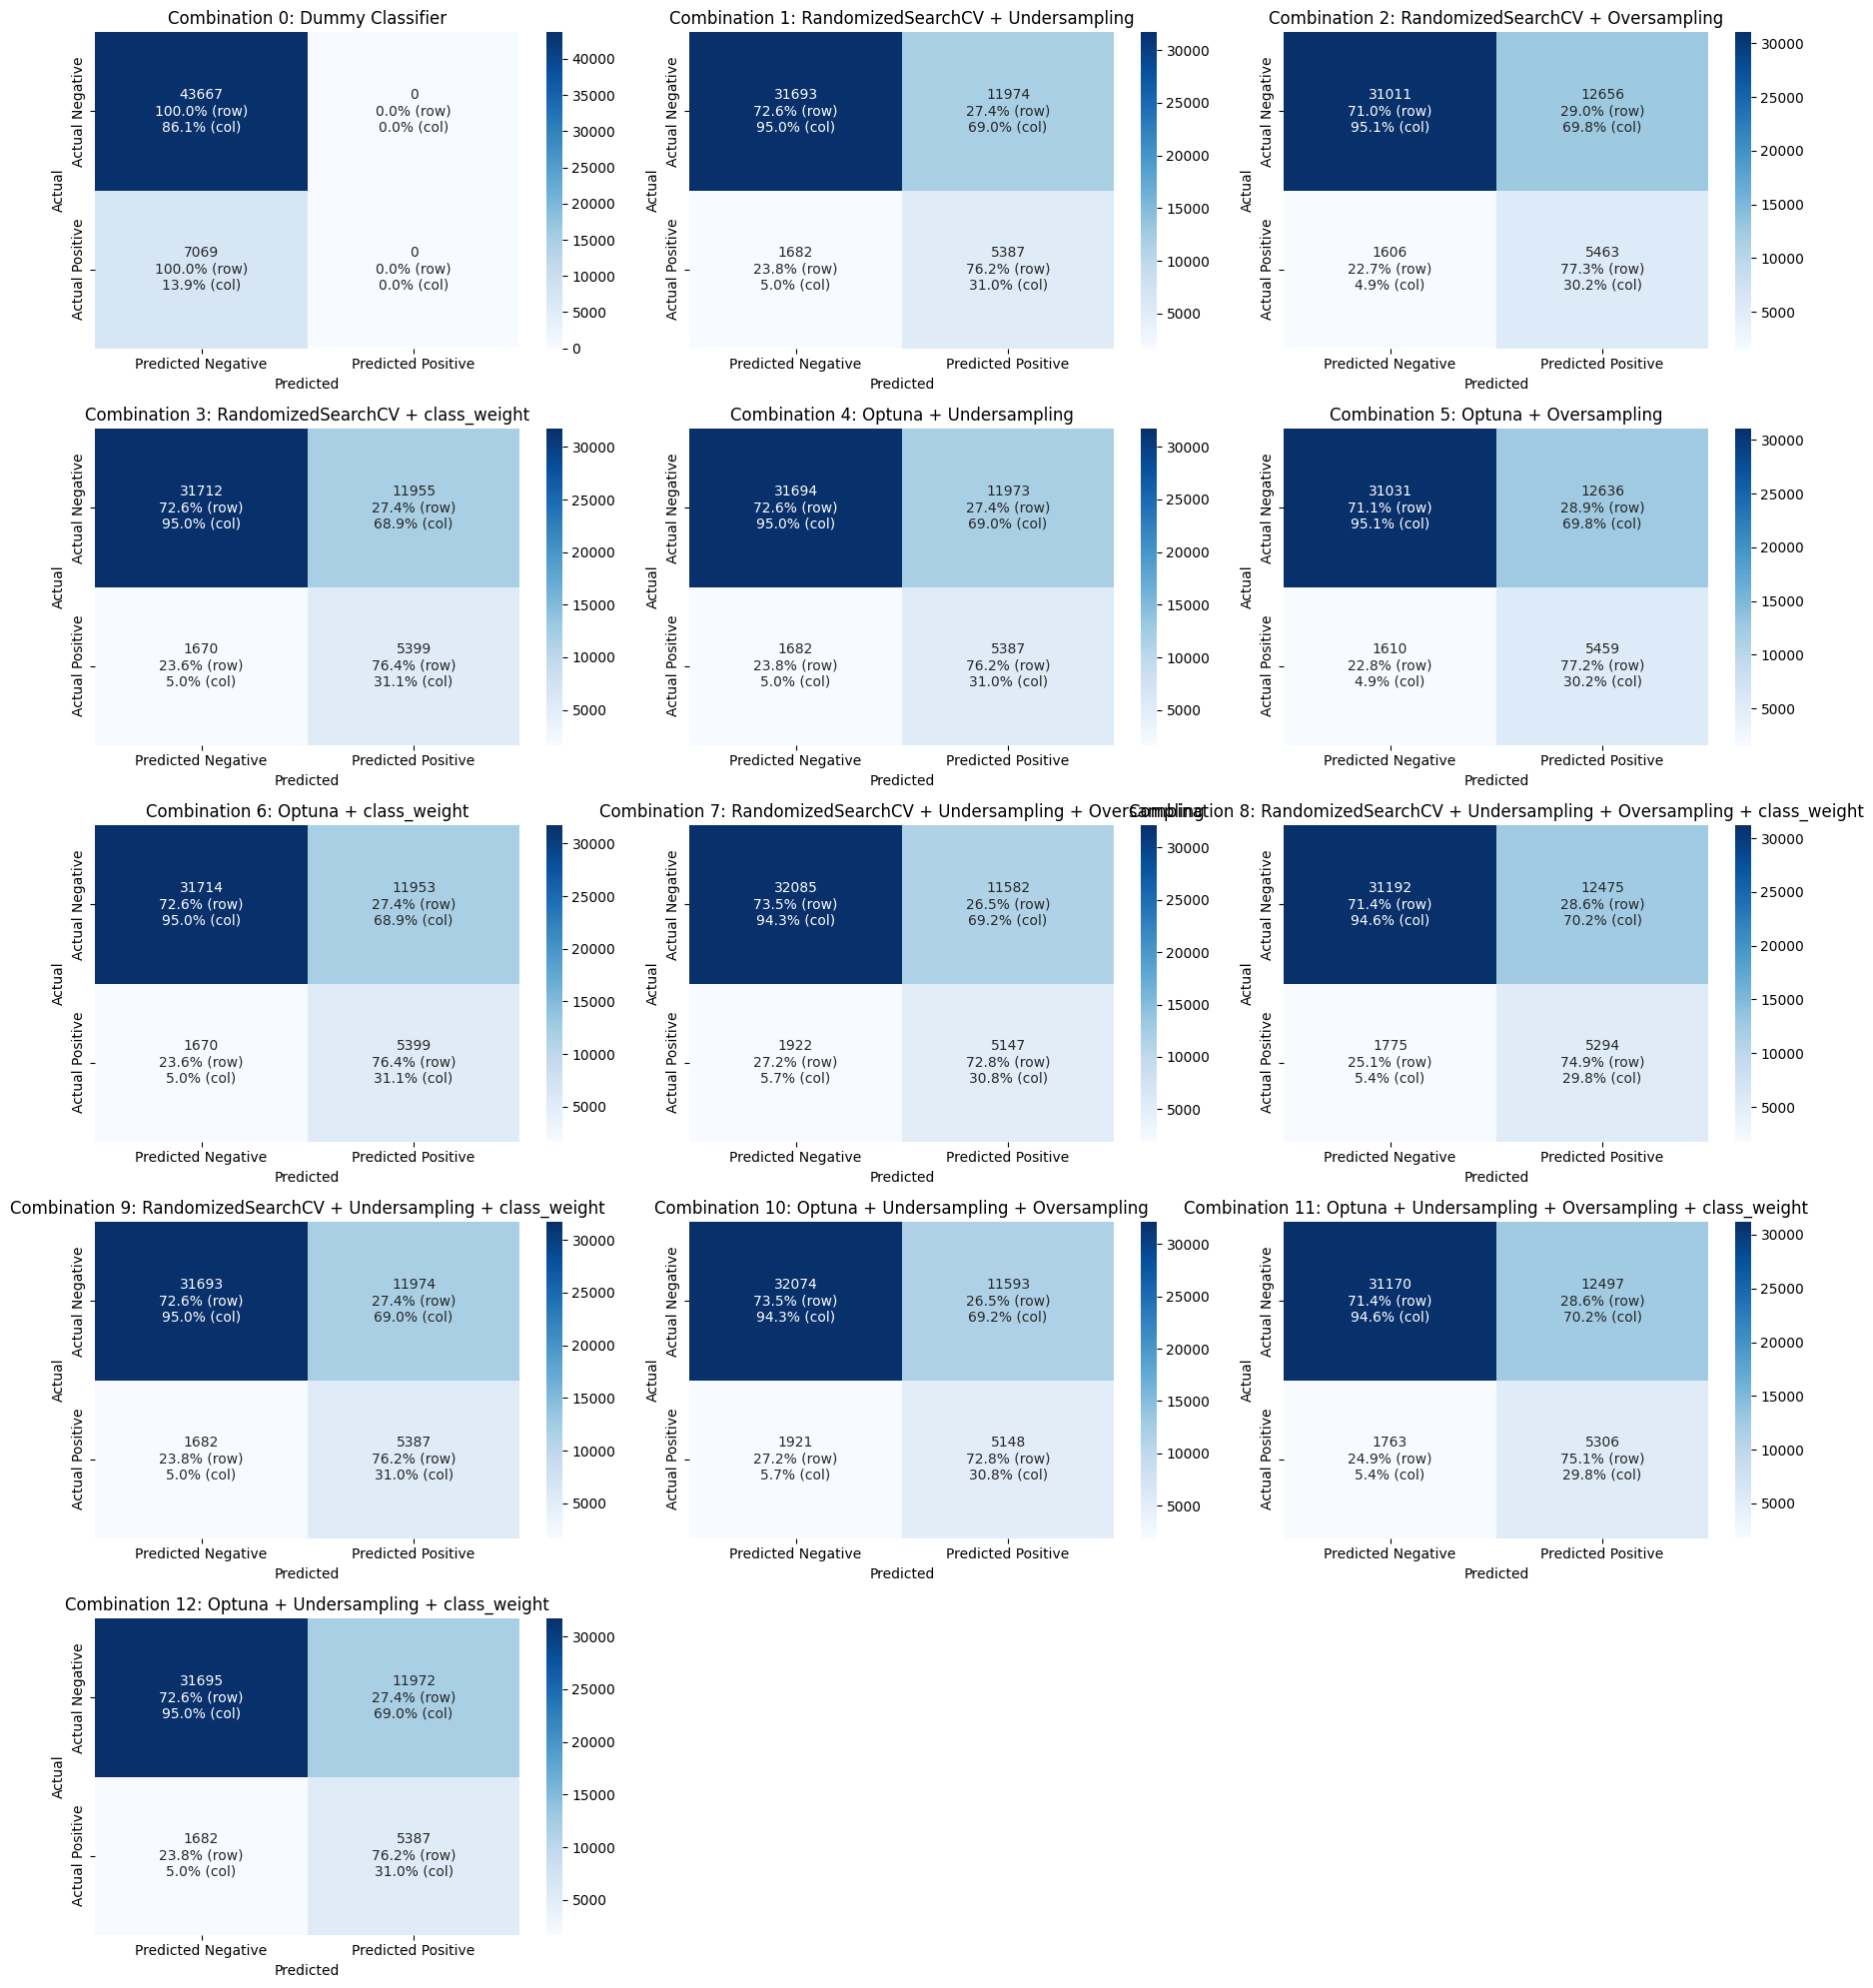

In [20]:
# Creamos el diccionario model_results utilizando los diccionarios de métricas de cada modelo:
model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_lr_randcv_un
    },
    {
        "model": "Combination 2: RandomizedSearchCV + Oversampling",
        **metrics_lr_randcv_ov
    },
    {
        "model": "Combination 3: RandomizedSearchCV + class_weight",
        **metrics_lr_randcv_wght
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_lr_opt_un
    },
    {
        "model": "Combination 5: Optuna + Oversampling",
        **metrics_lr_opt_ov
    },
    {
        "model": "Combination 6: Optuna + class_weight",
        **metrics_lr_opt_wght
    },
    {
        "model": "Combination 7: RandomizedSearchCV + Undersampling + Oversampling",
        **metrics_lr_randcv_un_ov
    },
    {
        "model": "Combination 8: RandomizedSearchCV + Undersampling + Oversampling + class_weight",
        **metrics_lr_randcv_un_ov_wght
    },
    {
        "model": "Combination 9: RandomizedSearchCV + Undersampling + class_weight",
        **metrics_lr_randcv_un_wght
    },
    {
        "model": "Combination 10: Optuna + Undersampling + Oversampling",
        **metrics_lr_opt_un_ov
    },
    {
        "model": "Combination 11: Optuna + Undersampling + Oversampling + class_weight",
        **metrics_lr_opt_un_ov_wght
    },
    {
        "model": "Combination 12: Optuna + Undersampling + class_weight",
        **metrics_lr_opt_un_wght
    }
]

plot_results(model_results)

del model_results

In [19]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_lr_randcv_un['cv_scores'],
    'Combination 2: RandCV + Ov': metrics_lr_randcv_ov['cv_scores'],
    'Combination 3: RandCV + wght': metrics_lr_randcv_wght['cv_scores'],
    'Combination 4: Opt + Un': metrics_lr_opt_un['cv_scores'],
    'Combination 5: Opt + Ov': metrics_lr_opt_ov['cv_scores'],
    'Combination 6: Opt + wght': metrics_lr_opt_wght['cv_scores'],
    'Combination 7: RandCV + Un + Ov': metrics_lr_randcv_un_ov['cv_scores'],
    'Combination 8: RandCV + Un + Ov + wght': metrics_lr_randcv_un_ov_wght['cv_scores'],
    'Combination 9: RandCV + Un + wght': metrics_lr_randcv_un_wght['cv_scores'],
    'Combination 10: Opt + Un + Ov': metrics_lr_opt_un_ov['cv_scores'],
    'Combination 11: Opt + Un + Ov + wght': metrics_lr_opt_un_ov_wght['cv_scores'],
    'Combination 12: Opt + Un + wght': metrics_lr_opt_un_wght['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


Resultados del Test de Friedman:
 Estadístico Friedman      p-value
           109.395041 7.881639e-18

Resultados del Test de Wilcoxon:
                         Primer Modelo                         Segundo Modelo  Wilcox V  p-value original  p-value ajustado
       Combination 0: Dummy Classifier             Combination 1: RandCV + Un       0.0          1.000000          1.000000
       Combination 0: Dummy Classifier             Combination 2: RandCV + Ov       0.0          1.000000          1.000000
       Combination 0: Dummy Classifier           Combination 3: RandCV + wght       0.0          1.000000          1.000000
       Combination 0: Dummy Classifier                Combination 4: Opt + Un       0.0          1.000000          1.000000
       Combination 0: Dummy Classifier                Combination 5: Opt + Ov       0.0          1.000000          1.000000
       Combination 0: Dummy Classifier              Combination 6: Opt + wght       0.0          1.000000          1.00

Basándonos en estos hallazgos y considerando que el objetivo es maximizar el AUC, se concluye que la mejor estrategia para este problema es la que emplea RandomizedSearchCV en conjunto con undersampling (sin SMOTE y sin ajuste de class_weight adicional). En particular, la “Combination 1: RandCV + Un” se perfila como la combinación más adecuada, ya que:

* Genera un AUC más alto en comparación con las técnicas que incorporan SMOTE.

* Evita la generación de muestras sintéticas que pueden introducir ruido.

* Además, la comparación con variantes que incluyen class_weight sugiere que el simple undersampling es suficientemente efectivo en este caso.

EXPLICACION: Cuando se realizan múltiples comparaciones, como en el caso de comparar de forma par a par los 6 modelos (lo que implica 15 pruebas independientes), aumenta la probabilidad de obtener resultados significativos por azar (errores de Tipo I). Esto se debe a que, con cada prueba adicional, la probabilidad acumulada de cometer un falso positivo crece. Por ello, ajustar el p-value mediante métodos como la corrección de Bonferroni es fundamental.

La corrección de Bonferroni consiste en dividir el nivel de significancia original (por ejemplo, 0.05) por el número total de comparaciones. De este modo, se establece un umbral de significancia más estricto para cada prueba individual, lo que ayuda a controlar el error familiar y reduce la posibilidad de que las diferencias observadas sean simplemente fruto del azar. En resumen, este ajuste garantiza que las conclusiones obtenidas sobre la superioridad o inferioridad de un modelo frente a otro sean estadísticamente robustas y confiables, aportando mayor rigor a la validación de los resultados en el estudio.

### Fase 2: tuning de los datos

#### Configuración 1: variables seleccionadas manualmente

In [18]:
metrics_lr_man_sel = metrics_lr_randcv_un

#### Configuración 2: variables seleccionadas automáticamente

La aplicación del selector automático antes que el undersampling puede estar sesgando la selección si el desequilibrio de clases afecta la importancia de las variables. Por ello y por la lentitud de ejecución del código se ha optado por aplicarlo después del undersampling

In [32]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

# Espacio de hiperparámetros
param_distributions_sfm = {
    'selector__estimator__n_estimators': [50, 100, 150],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_lr__C': [0.001, 0.01, 0.1, 1, 10],
    'clf_lr__penalty': ['l1', 'l2']
}

start_time = time.time()
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions_sfm,
    scoring='roc_auc',
    cv=cv,
    n_iter=50,
    n_jobs=n_jobs,
    random_state=42,
)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 12.91 minutes
Best Parameters: {'selector__threshold': 0.01, 'selector__estimator__n_estimators': 50, 'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
Threshold: 0.5
AUC: 0.8167
Accuracy: 0.7296
Recall: 0.7605
Precision: 0.3089
Confusion Matrix:
[[31641 12026]
 [ 1693  5376]]
Cross-Validation AUC: Mean = 0.8206, Std = 0.0028
Variables seleccionadas: ['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


#### Configuración 3: reducción de dimensionalidad

misma logica que el SelectFromModel

In [33]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

param_distributions_umap = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_lr__C': [0.001, 0.01, 0.1, 1, 10],
    'clf_lr__penalty': ['l1', 'l2']
}

start_time = time.time()
search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions_umap,
    scoring='roc_auc',
    cv=cv,
    n_iter=50,
    n_jobs=n_jobs,
    random_state=42,
)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\

Execution time: 99.26 minutes
Best Parameters: {'umap__n_neighbors': 30, 'umap__n_components': 10, 'umap__min_dist': 0.0, 'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
Threshold: 0.5
AUC: 0.7791
Accuracy: 0.6726
Recall: 0.7980
Precision: 0.2709
Confusion Matrix:
[[28482 15185]
 [ 1428  5641]]
Cross-Validation AUC: Mean = 0.7829, Std = 0.0031


#### Configuración 4: todas las variables

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', max_iter=1000))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lr_all = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 5.76 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
AUC: 0.8195
Accuracy: 0.7317
Recall: 0.7630
Precision: 0.3113
Confusion Matrix:
[[31731 11936]
 [ 1675  5394]]
Cross-Validation AUC: Mean = 0.8190, Std = 0.0085


#### Resumen y conclusiones

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Configuration 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000114
1,Configuration 1: Variables seleccionadas manualmente,0.818685,0.730842,0.762060,0.310293,0.822828,0.002907,0.935462
2,Configuration 2: Variables seleccionadas automáticamente,0.816701,0.729600,0.760504,0.308930,0.820611,0.002762,12.909698
3,Configuration 3: reducción de dimensionalidad,0.779140,0.672560,0.797991,0.270863,0.782851,0.003110,99.259198
4,Configuration 4: todas las variables,0.819485,0.731729,0.763050,0.311252,0.818959,0.008531,5.763507


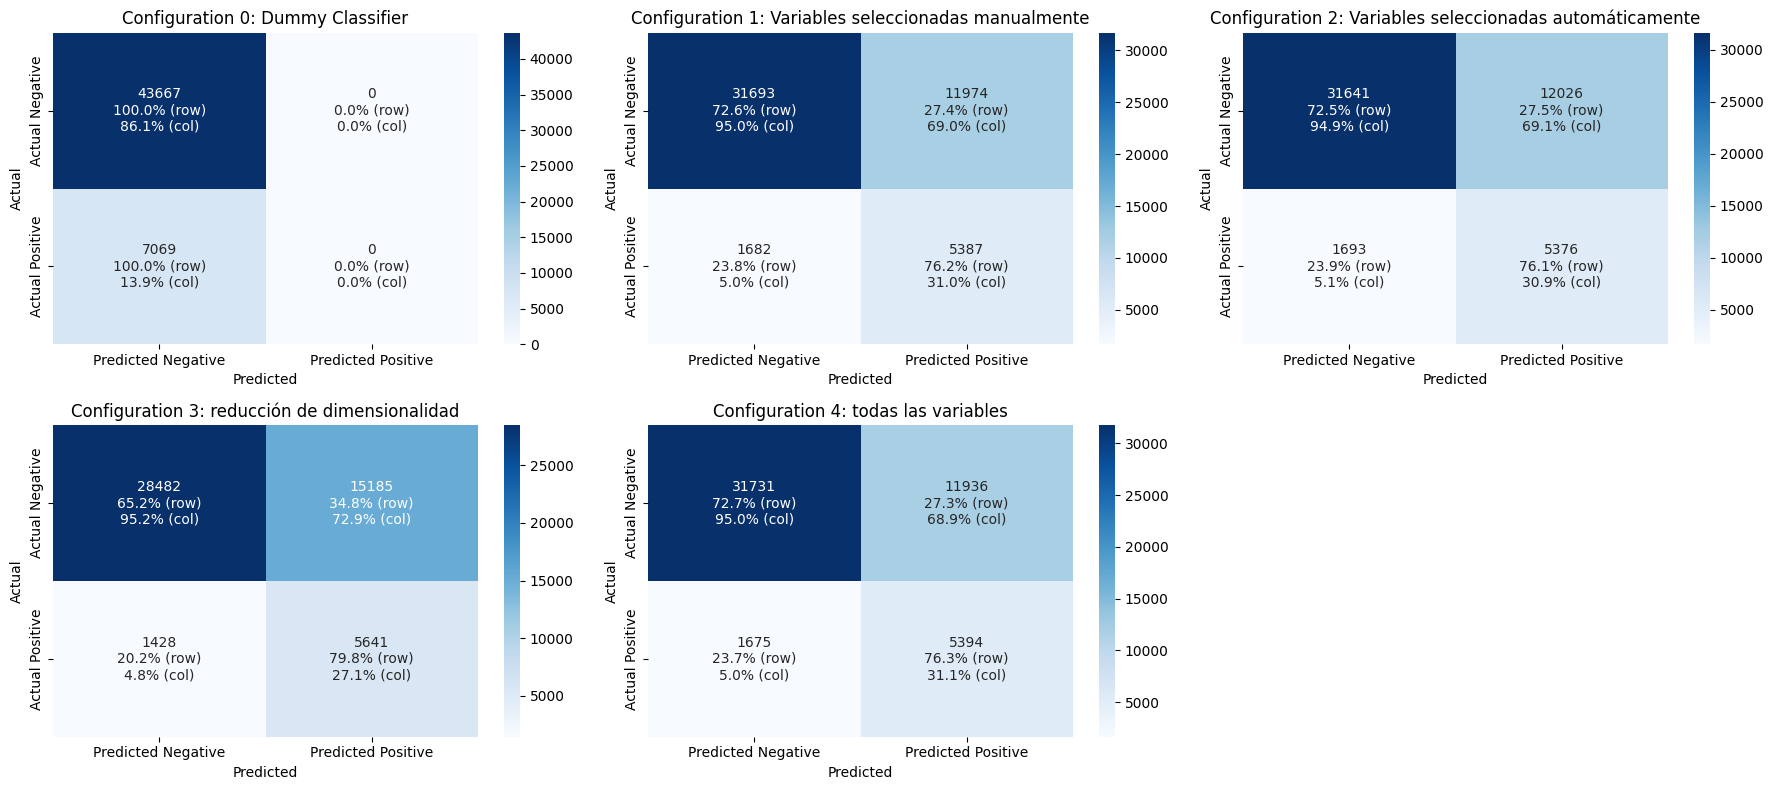

In [41]:
# Creamos el diccionario model_results utilizando los diccionarios de métricas de cada modelo:
model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_lr_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_lr_aut_sel
    },
    {
        "model": "Configuration 3: reducción de dimensionalidad",
        **metrics_lr_red_dim
    },
    {
        "model": "Configuration 4: todas las variables",
        **metrics_lr_all
    }
]

plot_results(model_results)

In [ ]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_lr_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_lr_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_lr_red_dim['cv_scores'],
    'Configuration 4: all': metrics_lr_all['cv_scores']
}

perform_stat_tests(cv_scores)

Resultados del Test de Friedman:
 Estadístico Friedman      p-value
                37.36 1.518463e-07

Resultados del Test de Wilcoxon:
                    Primer Modelo           Segundo Modelo  Wilcox V  p-value original  p-value ajustado
Configuration 0: Dummy Classifier Configuration 1: man_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 2: aut_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 3: red_dim       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 1: man_sel Configuration 2: aut_sel      55.0          0.000977          0.009766
         Configuration 1: man_sel Configuration 3: red_dim      55.0          0.000977          0.009766
         Configuration 1: man_sel     Configuration 4: all      45.0          0.041992          0.419922
         Configuration 

### Final model
El modelo final de Logistic Classifier es un Pipeline que integra **RandomUnderSampler** y emplea **todas las variables** del dataset. Sus resultados son:
* **AUC**: 0.819
* **Accuracy**: 0.782 
* **Recall**: 0.661 
* **Precision**: 0.350

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


El umbral óptimo es: 0.59


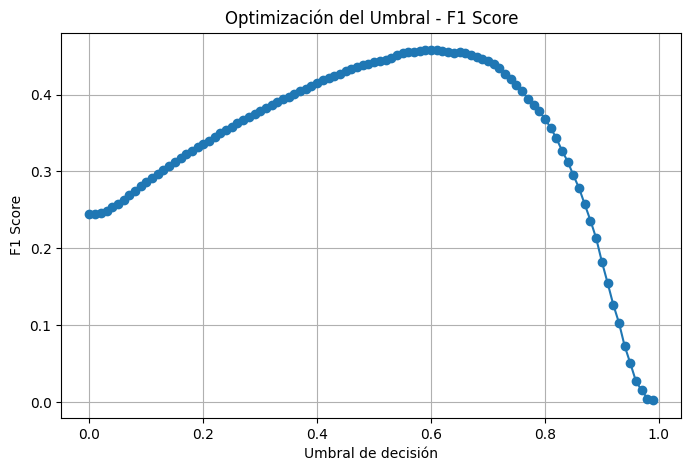

In [32]:
final_pipeline_lr = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lr', LogisticRegression(random_state=42, solver='saga', penalty='l2', C=0.1, max_iter=1000))
 ])

optimal_threshold = maximize_f1_score(final_pipeline_lr, X_train, y_train)

In [ ]:
start_time = time.time()
final_pipeline_lr.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(final_pipeline_lr, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

# Se pasa el valor del umbral óptimo a la función de evaluación para que realice la predicción
# utilizando el umbral ajustado en lugar del valor por defecto (0.5).
metrics_lr_final = evaluate_and_return_metrics(final_pipeline_lr, X_test, y_test, execution_time, {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}, cv_scores, threshold=optimal_threshold)

del start_time, end_time, execution_time, cv_scores, optimal_threshold

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Execution time: 0.16 minutes
Best Parameters: {'clf_lr__penalty': 'l2', 'clf_lr__C': 0.1}
Threshold: 0.59
AUC: 0.8195
Accuracy: 0.7816
Recall: 0.6612
Precision: 0.3499
Confusion Matrix:
[[34982  8685]
 [ 2395  4674]]
Cross-Validation AUC: Mean = 0.8233, Std = 0.0028


Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Final Model: Logistic Regression,0.819485,0.781615,0.661197,0.349876,0.823256,0.002846,0.1559


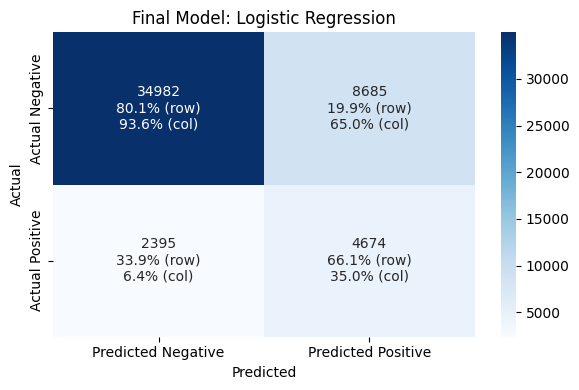

In [34]:
model_results = [
    {
        "model": "Final Model: Logistic Regression",
        **metrics_lr_final
    }
]
plot_results(model_results)

del model_results

In [28]:
final_model_lr = final_pipeline_lr.named_steps['clf_lr']

plot_shap(final_model_lr, X_train, X_test)

del final_model_lr, final_pipeline_lr

NameError: name 'final_pipeline_lr' is not defined

## RandomForestClassifier
Modelo base fuerte, maneja datos categóricos sin problemas y es robusto.

Se van a eliminar las tecnicas con oversampling dado que se ha demostrado que ofrecen un rendimiento muy por debajo del undersampling o de otras tecnicas

PARAMETROS  EVALUADOS en RandomForestClassifier:
* **n_estimators** (cantidad de árboles): 100 es un buen punto de partida, pero Random Forest suele mejorar hasta ~300-500 árboles antes de volverse ineficiente.
Valores mayores a 500 no suelen mejorar el rendimiento significativamente en datasets medianos/grandes. (Breiman, L. (2001). Random Forests en Machine Learning Journal.)
* **max_depth** (profundidad máxima del árbol): None permite que el árbol crezca completamente (puede sobreajustar).
Valores pequeños (10-20) controlan el overfitting y mejoran la capacidad de generalización.
Más de 30 generalmente es innecesario, ya que la mayoría de los datasets no requieren árboles tan profundos. (Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning.)
* **min_samples_split** (Mínimo de muestras para dividir un nodo): Valores bajos (2-5) permiten que el árbol crezca más profundo y capture más patrones.
Valores más altos (10+) reducen la profundidad del árbol y evitan el sobreajuste. (Scikit-learn documentation: Empirical Studies on Decision Trees.)
* **min_samples_leaf** (Mínimo de muestras en las hojas finales): 1 es el valor predeterminado y permite capturar patrones raros.
2 o 4 evitan ramas muy específicas y reducen el sobreajuste. (Breiman, L. (2001). Random Forests.)
* **max_features** (Número de características consideradas en cada split): sqrt (raíz cuadrada del número total de features) es la configuración estándar en Random Forest.
log2 (logaritmo en base 2 del número total de features) reduce aún más la correlación entre árboles, lo cual puede mejorar estabilidad. (Ho, Tin Kam (1998). Random Decision Forests.)
* **bootstrap** (Uso de muestreo con reemplazo). True (predeterminado) → Cada árbol se entrena con un subconjunto aleatorio del dataset.
False (Sin reemplazo) → Cada árbol usa TODO el dataset. (Breiman, L. (2001). Bagging Predictors.)

Se va a probar a intercambiar el orden de las fases.

### Fase 1: tuning de los datos

#### Configuración 1: variables seleccionadas manualmente

In [1]:
# Definición del espacio de hiperparámetros para Random Forest
param_distributions_rf = {
    'clf_rf__n_estimators': [100, 300, 500],
    'clf_rf__max_depth': [None, 10, 20, 30, 40],
    'clf_rf__min_samples_split': [2, 5],
    'clf_rf__min_samples_leaf': [1, 2],
    'clf_rf__bootstrap': [True, False]
}

In [20]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_man_sel = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 21.32 minutes
Best Parameters: {'clf_rf__n_estimators': 300, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_depth': 10, 'clf_rf__bootstrap': True}
Threshold: 0.5
AUC: 0.8202
Accuracy: 0.7130
Recall: 0.7881
Precision: 0.2990
Confusion Matrix:
[[30606 13061]
 [ 1498  5571]]
Cross-Validation AUC: Mean = 0.8247, Std = 0.0030


#### Configuración 2: variables seleccionadas automáticamente

In [34]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

param_distributions_sfm_rf = {
    'selector__estimator__n_estimators': [50, 100, 150],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_rf__n_estimators': [100, 300, 500],
    'clf_rf__max_depth': [None, 10, 20, 30, 40],
    'clf_rf__min_samples_split': [2, 5],
    'clf_rf__min_samples_leaf': [1, 2],
    'clf_rf__bootstrap': [True, False]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_sfm_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm_rf, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 27.72 minutes
Best Parameters: {'selector__threshold': 0.01, 'selector__estimator__n_estimators': 100, 'clf_rf__n_estimators': 300, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_depth': 10, 'clf_rf__bootstrap': True}
Threshold: 0.5
AUC: 0.8210
Accuracy: 0.7157
Recall: 0.7877
Precision: 0.3011
Confusion Matrix:
[[30745 12922]
 [ 1501  5568]]
Cross-Validation AUC: Mean = 0.8256, Std = 0.0033
Variables seleccionadas: ['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


#### Configuración 3: reducción de la dimensionalidad

In [35]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

param_distributions_umap_rf = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_rf__n_estimators': [100, 300, 500],
    'clf_rf__max_depth': [None, 10, 20, 30, 40],
    'clf_rf__min_samples_split': [2, 5],
    'clf_rf__min_samples_leaf': [1, 2],
    'clf_rf__bootstrap': [True, False]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_umap_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap_rf, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\

Execution time: 155.01 minutes
Best Parameters: {'umap__n_neighbors': 30, 'umap__n_components': 7, 'umap__min_dist': 0.0, 'clf_rf__n_estimators': 500, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_depth': None, 'clf_rf__bootstrap': False}
Threshold: 0.5
AUC: 0.7703
Accuracy: 0.7042
Recall: 0.7496
Precision: 0.2858
Confusion Matrix:
[[30428 13239]
 [ 1770  5299]]
Cross-Validation AUC: Mean = 0.7723, Std = 0.0038


#### Configuración 4: todas las variables

In [23]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_all = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 27.92 minutes
Best Parameters: {'clf_rf__n_estimators': 300, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_depth': 10, 'clf_rf__bootstrap': True}
Threshold: 0.5
AUC: 0.8223
Accuracy: 0.7184
Recall: 0.7892
Precision: 0.3036
Confusion Matrix:
[[30868 12799]
 [ 1490  5579]]
Cross-Validation AUC: Mean = 0.8272, Std = 0.0032


#### Resumen y conclusiones

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Configuration 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000114
1,Configuration 1: Variables seleccionadas manualmente,0.820204,0.713044,0.788089,0.299002,0.824693,0.003030,21.323814
2,Configuration 2: Variables seleccionadas automáticamente,0.820974,0.715725,0.787664,0.301136,0.825574,0.003287,27.715554
3,Configuration 3: reducción de dimensionalidad,0.770304,0.704175,0.749611,0.285845,0.772303,0.003841,155.005281
4,Configuration 4: todas las variables,0.822331,0.718366,0.789221,0.303569,0.827163,0.003176,27.915744


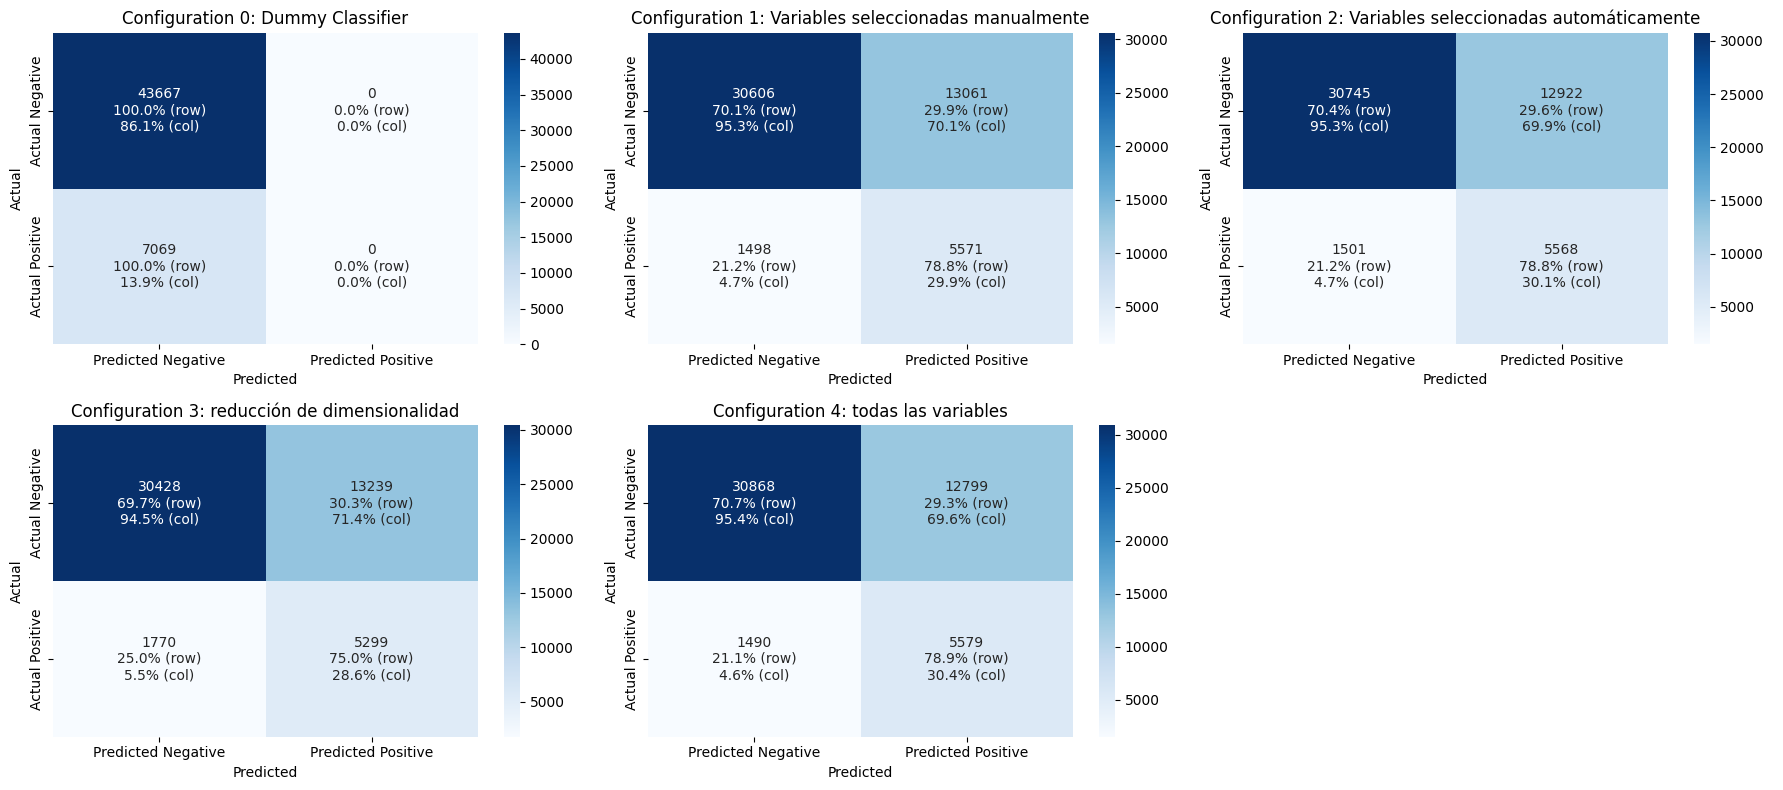

In [44]:
model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_rf_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_rf_aut_sel
    },
    {
        "model": "Configuration 3: reducción de dimensionalidad",
        **metrics_rf_red_dim
    },
    {
        "model": "Configuration 4: todas las variables",
        **metrics_rf_all
    }
]

plot_results(model_results)

In [37]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_rf_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_rf_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_rf_red_dim['cv_scores'],
    'Configuration 4: all': metrics_rf_all['cv_scores']
}

perform_stat_tests(cv_scores)

Resultados del Test de Friedman:
 Estadístico Friedman      p-value
                38.72 7.958599e-08

Resultados del Test de Wilcoxon:
                    Primer Modelo           Segundo Modelo  Wilcox V  p-value original  p-value ajustado
Configuration 0: Dummy Classifier Configuration 1: man_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 2: aut_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 3: red_dim       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 1: man_sel Configuration 2: aut_sel       7.0          0.986328          1.000000
         Configuration 1: man_sel Configuration 3: red_dim      55.0          0.000977          0.009766
         Configuration 1: man_sel     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 

### Fase 2: tuning del modelo

#### Combinación 1: RandomizedSearchCV + Undersampling

In [30]:
metrics_rf_randcv_un = metrics_rf_all

#### Combinación 3: RandomizedSearchCV + class_weight

In [31]:
# Combinación 3: RandomizedSearchCV + class_weight
pipeline = ImbPipeline([
    ('clf_rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_rf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_randcv_wght = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 132.45 minutes
Best Parameters: {'clf_rf__n_estimators': 300, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_depth': 10, 'clf_rf__bootstrap': True}
Threshold: 0.5
AUC: 0.8227
Accuracy: 0.7318
Recall: 0.7681
Precision: 0.3121
Confusion Matrix:
[[31701 11966]
 [ 1639  5430]]
Cross-Validation AUC: Mean = 0.8274, Std = 0.0035


#### Combinación 4: Optuna + Undersampling

In [34]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_rf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            random_state=42
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_opt_un = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores


[I 2025-04-11 17:31:59,011] A new study created in memory with name: no-name-8ea3539f-ca35-4f3d-bc94-6016e65c8c00
[I 2025-04-11 17:32:25,165] Trial 0 finished with value: 0.8109141323348382 and parameters: {'n_estimators': 100, 'max_depth': 40, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 0 with value: 0.8109141323348382.
[I 2025-04-11 17:32:41,144] Trial 1 finished with value: 0.8152171619991186 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 1 with value: 0.8152171619991186.
[I 2025-04-11 17:33:06,629] Trial 2 finished with value: 0.8268809783271254 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.8268809783271254.
[I 2025-04-11 17:33:42,393] Trial 3 finished with value: 0.8231248328098157 and parameters: {'n_estimators': 300, 'max_depth': None, 'min_samples

Execution time: 29.95 minutes
Best Parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}
Threshold: 0.5
AUC: 0.8224
Accuracy: 0.7185
Recall: 0.7889
Precision: 0.3037
Confusion Matrix:
[[30878 12789]
 [ 1492  5577]]
Cross-Validation AUC: Mean = 0.8273, Std = 0.0032


#### Combinación 6: Optuna + class_weight

In [35]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    pipeline = Pipeline([
        ('clf_rf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            class_weight='balanced',
            random_state=42
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    class_weight='balanced',
    random_state=42
)
pipeline = Pipeline([
    ('clf_rf', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_opt_wght = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores


[I 2025-04-11 18:02:38,355] A new study created in memory with name: no-name-ca2d0f42-a094-4dfd-a1be-8919db925305
[I 2025-04-11 18:04:50,324] Trial 0 finished with value: 0.8174746402963464 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.8174746402963464.
[I 2025-04-11 18:05:22,858] Trial 1 finished with value: 0.8271607573573236 and parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.8271607573573236.
[I 2025-04-11 18:06:09,506] Trial 2 finished with value: 0.8148050654339709 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 1 with value: 0.8271607573573236.
[I 2025-04-11 18:14:12,572] Trial 3 finished with value: 0.7937753434504635 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_sp

Execution time: 137.64 minutes
Best Parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}
Threshold: 0.5
AUC: 0.8228
Accuracy: 0.7313
Recall: 0.7676
Precision: 0.3115
Confusion Matrix:
[[31675 11992]
 [ 1643  5426]]
Cross-Validation AUC: Mean = 0.8275, Std = 0.0034


#### Combinación 9: RandomizedSearchCV + Undersampling + class_weight

In [36]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

start_time = time.time()
search = RandomizedSearchCV(
    pipeline, 
    param_distributions_rf, 
    scoring='roc_auc', 
    cv=cv, 
    n_iter=50, 
    n_jobs=n_jobs, 
    random_state=42
)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_randcv_un_wght = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 24.37 minutes
Best Parameters: {'clf_rf__n_estimators': 300, 'clf_rf__min_samples_split': 5, 'clf_rf__min_samples_leaf': 2, 'clf_rf__max_depth': 10, 'clf_rf__bootstrap': True}
Threshold: 0.5
AUC: 0.8223
Accuracy: 0.7184
Recall: 0.7892
Precision: 0.3036
Confusion Matrix:
[[30868 12799]
 [ 1490  5579]]
Cross-Validation AUC: Mean = 0.8272, Std = 0.0032


#### Combinación 12: Optuna + Undersampling + class_weight

In [37]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_rf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            bootstrap=bootstrap,
            class_weight='balanced',
            random_state=42
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    bootstrap=best_params['bootstrap'],
    class_weight='balanced',
    random_state=42
)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_rf', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_rf_opt_un_wght = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores


[I 2025-04-11 20:48:28,324] A new study created in memory with name: no-name-1be2a132-b696-43d1-ab4d-a4366c457f62
[I 2025-04-11 20:49:20,958] Trial 0 finished with value: 0.8199821219971482 and parameters: {'n_estimators': 500, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}. Best is trial 0 with value: 0.8199821219971482.
[I 2025-04-11 20:49:36,409] Trial 1 finished with value: 0.8174884091897006 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.8199821219971482.
[I 2025-04-11 20:49:51,525] Trial 2 finished with value: 0.8174884091897006 and parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}. Best is trial 0 with value: 0.8199821219971482.
[I 2025-04-11 20:50:26,006] Trial 3 finished with value: 0.811814173440888 and parameters: {'n_estimators': 300, 'max_depth': 30, 'min_samples

Execution time: 26.77 minutes
Best Parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'bootstrap': True}
Threshold: 0.5
AUC: 0.8224
Accuracy: 0.7185
Recall: 0.7889
Precision: 0.3037
Confusion Matrix:
[[30878 12789]
 [ 1492  5577]]
Cross-Validation AUC: Mean = 0.8273, Std = 0.0032


#### Resumen y conclusiones


Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Combination 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000106
1,Combination 1: RandomizedSearchCV + Undersampling,0.822331,0.718366,0.789221,0.303569,0.827163,0.003176,27.915744
2,Combination 3: RandomizedSearchCV + class_weight,0.822700,0.731847,0.768143,0.312141,0.827393,0.003493,132.450630
3,Combination 4: Optuna + Undersampling,0.822414,0.718523,0.788938,0.303659,0.827286,0.003181,29.949243
4,Combination 6: Optuna + class_weight,0.822821,0.731256,0.767577,0.311517,0.827523,0.003363,137.644601
5,Combination 9: RandomizedSearchCV + Undersampling + class_weight,0.822331,0.718366,0.789221,0.303569,0.827163,0.003176,24.365733
6,Combination 12: Optuna + Undersampling + class_weight,0.822414,0.718523,0.788938,0.303659,0.827286,0.003181,26.768309


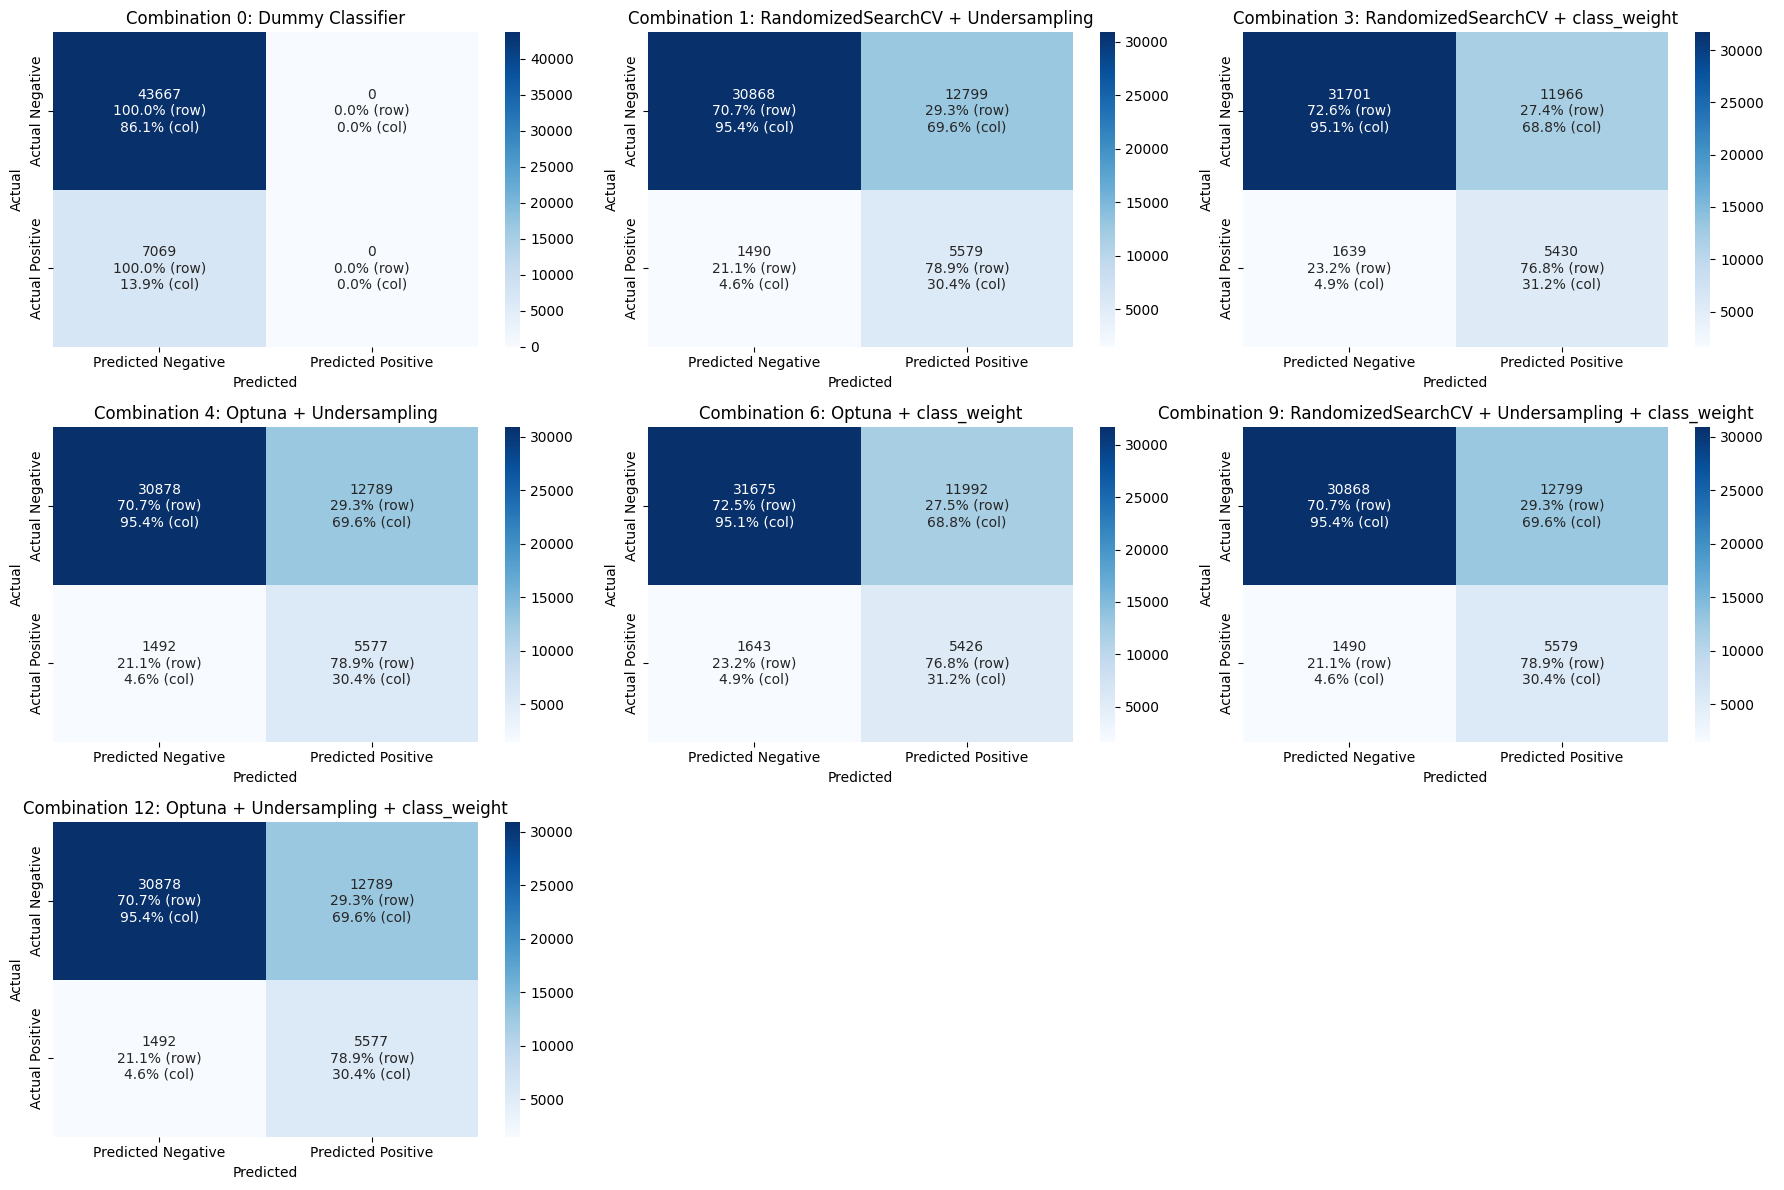

In [106]:
model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_rf_randcv_un
    },
    {
        "model": "Combination 3: RandomizedSearchCV + class_weight",
        **metrics_rf_randcv_wght
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_rf_opt_un
    },
    {
        "model": "Combination 6: Optuna + class_weight",
        **metrics_rf_opt_wght
    },
    {
        "model": "Combination 9: RandomizedSearchCV + Undersampling + class_weight",
        **metrics_rf_randcv_un_wght
    },
    {
        "model": "Combination 12: Optuna + Undersampling + class_weight",
        **metrics_rf_opt_un_wght
    }
]

plot_results(model_results)

del model_results

In [107]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_rf_randcv_un['cv_scores'],
    'Combination 3: RandCV + wght': metrics_rf_randcv_wght['cv_scores'],
    'Combination 4: Opt + Un': metrics_rf_opt_un['cv_scores'],
    'Combination 6: Opt + wght': metrics_rf_opt_wght['cv_scores'],
    'Combination 9: RandCV + Un + wght': metrics_rf_randcv_un_wght['cv_scores'],
    'Combination 12: Opt + Un + wght': metrics_rf_opt_un_wght['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


Resultados del Test de Friedman:
 Estadístico Friedman  p-value
            36.888889 0.000002

Resultados del Test de Wilcoxon:
                    Primer Modelo                    Segundo Modelo  Wilcox V  p-value original  p-value ajustado
  Combination 0: Dummy Classifier        Combination 1: RandCV + Un       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier      Combination 3: RandCV + wght       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier           Combination 4: Opt + Un       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier         Combination 6: Opt + wght       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier Combination 9: RandCV + Un + wght       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier   Combination 12: Opt + Un + wght       0.0          1.000000          1.000000
       Combination 1: RandCV + Un      Combination 3: RandCV + wght      

### Final model
El modelo final de Random Forest Classifier es un Pipeline que integra **class_weight** y emplea **todas las variables** del dataset. Sus resultados son:
* **AUC**: 0.823
* **Accuracy**: 0.806
* **Recall**: 0.605
* **Precision**: 0.377

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


El umbral óptimo es: 0.62


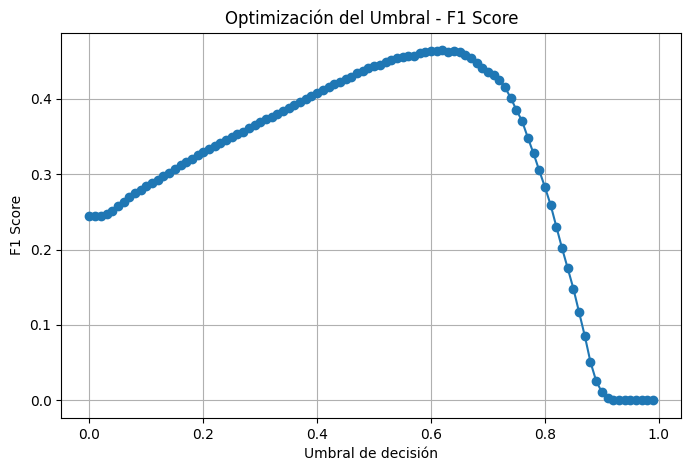

In [40]:
final_pipeline_rf = ImbPipeline([
    ('clf_rf', RandomForestClassifier(
        random_state=42, 
        n_estimators=500,
        max_depth=10,
        min_samples_split=5, 
        min_samples_leaf=1, 
        bootstrap=True,
        class_weight='balanced'
    ))
])

optimal_threshold = maximize_f1_score(final_pipeline_rf, X_train, y_train)

In [41]:
start_time = time.time()
final_pipeline_rf.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(final_pipeline_rf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

# Se pasa el valor del umbral óptimo a la función de evaluación para que realice la predicción
# utilizando el umbral ajustado en lugar del valor por defecto (0.5).
metrics_rf_final = evaluate_and_return_metrics(final_pipeline_rf, X_test, y_test, execution_time, {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': 'balanced'}, cv_scores, threshold=optimal_threshold)

del start_time, end_time, execution_time, cv_scores, optimal_threshold

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 0.81 minutes
Best Parameters: {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True, 'class_weight': 'balanced'}
Threshold: 0.62
AUC: 0.8228
Accuracy: 0.8056
Recall: 0.6052
Precision: 0.3769
Confusion Matrix:
[[36595  7072]
 [ 2791  4278]]
Cross-Validation AUC: Mean = 0.8275, Std = 0.0034


Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Final Model: Random Forest,0.822821,0.805602,0.605178,0.376916,0.827523,0.003363,0.812605


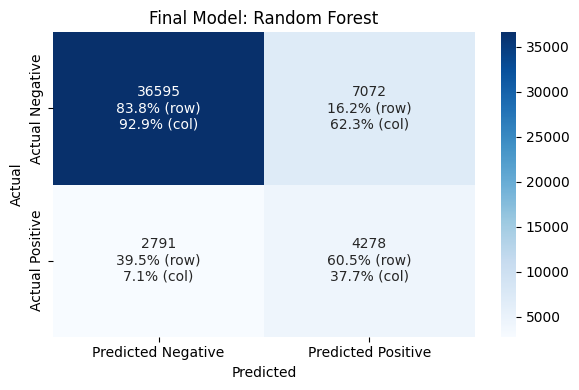

In [45]:
model_results = [
    {
        "model": "Final Model: Random Forest",
        **metrics_rf_final
    }
]
plot_results(model_results)

del model_results

In [ ]:
final_model_rf = final_pipeline_rf.named_steps['clf_rf']

plot_shap_tree(final_model_rf, X_train, X_test)

del final_model_rf, final_pipeline_rf

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


InvalidModelError: An unknown model type was passed: <class 'sklearn.ensemble._forest.RandomForestClassifier'>



---
Nota

---

Aunque no se ha implementado validación cruzada anidada (nested cross-validation) debido a su alto coste computacional, se ha utilizado una combinación de validación cruzada estratificada de 10 particiones y conjunto de test externo para garantizar una evaluación robusta del modelo, tal como se exige en la práctica. Esta estrategia ofrece una estimación fiable del rendimiento sin requerir los recursos computacionales adicionales que implicaría la anidación.

## BalancedRandomForestClassifier

Este clasificador genera múltiples árboles entrenando cada uno con un subconjunto (bootstrap) balanceado de datos. Esto significa que, en cada iteración, se realiza un submuestreo de la clase mayoritaria para que coincida con la cantidad de la clase minoritaria. De esta forma, cada árbol se entrena sobre un conjunto de datos balanceado, lo que puede ayudar a mejorar la detección de la clase minoritaria.

### Fase 1: tuning de datos

#### Configuración 1: variables seleccionadas manualmente

In [23]:
# Definición del espacio de hiperparámetros para Balanced Random Forest
param_distributions_brf = {
    'clf_brf__n_estimators': [100, 200, 300],
    'clf_brf__max_depth': [None, 10, 20, 30],
    'clf_brf__max_features': ['sqrt', 'log2', 0.5],
    'clf_brf__min_samples_split': [2, 5, 10],
    'clf_brf__min_samples_leaf': [1, 2, 4],
    'clf_brf__replacement': [False, True],
    'clf_brf__criterion': ['gini', 'entropy']
}

In [27]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_brf', BalancedRandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_brf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_brf_man_sel = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 21.22 minutes
Best Parameters: {'clf_brf__replacement': True, 'clf_brf__n_estimators': 300, 'clf_brf__min_samples_split': 10, 'clf_brf__min_samples_leaf': 2, 'clf_brf__max_features': 'sqrt', 'clf_brf__max_depth': 10, 'clf_brf__criterion': 'entropy'}
Threshold: 0.5
AUC: 0.8201
Accuracy: 0.7142
Recall: 0.7861
Precision: 0.2996
Confusion Matrix:
[[30679 12988]
 [ 1512  5557]]
Cross-Validation AUC: Mean = 0.8247, Std = 0.0031


#### Configuración 2: variables seleccionadas automáticamente

In [28]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(BalancedRandomForestClassifier(n_estimators=100, random_state=42))),
    ('clf_brf', BalancedRandomForestClassifier(random_state=42))
])

param_distributions_sfm_brf = {
    'selector__estimator__n_estimators': [50, 100, 150],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_brf__n_estimators': [100, 200, 300],
    'clf_brf__max_depth': [None, 10, 20, 30],
    'clf_brf__max_features': ['sqrt', 'log2', 0.5],
    'clf_brf__min_samples_split': [2, 5, 10],
    'clf_brf__min_samples_leaf': [1, 2, 4],
    'clf_brf__replacement': [False, True],
    'clf_brf__criterion': ['gini', 'entropy']
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_sfm_brf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_brf_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm_brf, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 34.99 minutes
Best Parameters: {'selector__threshold': 0.01, 'selector__estimator__n_estimators': 50, 'clf_brf__replacement': True, 'clf_brf__n_estimators': 300, 'clf_brf__min_samples_split': 2, 'clf_brf__min_samples_leaf': 2, 'clf_brf__max_features': 'sqrt', 'clf_brf__max_depth': 10, 'clf_brf__criterion': 'entropy'}
Threshold: 0.5
AUC: 0.8207
Accuracy: 0.7160
Recall: 0.7857
Precision: 0.3011
Confusion Matrix:
[[30773 12894]
 [ 1515  5554]]
Cross-Validation AUC: Mean = 0.8256, Std = 0.0032
Variables seleccionadas: ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


#### Configuración 3: reducción de dimensionalidad

In [29]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_brf', BalancedRandomForestClassifier(random_state=42))
])

param_distributions_umap_brf = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_brf__n_estimators': [100, 200, 300],
    'clf_brf__max_depth': [None, 10, 20, 30],
    'clf_brf__max_features': ['sqrt', 'log2', 0.5],
    'clf_brf__min_samples_split': [2, 5, 10],
    'clf_brf__min_samples_leaf': [1, 2, 4],
    'clf_brf__replacement': [False, True],
    'clf_brf__criterion': ['gini', 'entropy']
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_umap_brf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_brf_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap_brf, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\

Execution time: 159.30 minutes
Best Parameters: {'umap__n_neighbors': 30, 'umap__n_components': 7, 'umap__min_dist': 0.0, 'clf_brf__replacement': True, 'clf_brf__n_estimators': 300, 'clf_brf__min_samples_split': 5, 'clf_brf__min_samples_leaf': 2, 'clf_brf__max_features': 'sqrt', 'clf_brf__max_depth': 10, 'clf_brf__criterion': 'entropy'}
Threshold: 0.5
AUC: 0.7679
Accuracy: 0.7087
Recall: 0.7434
Precision: 0.2884
Confusion Matrix:
[[30701 12966]
 [ 1814  5255]]
Cross-Validation AUC: Mean = 0.7676, Std = 0.0043


#### Configuración 4: todas las variables

In [30]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_brf', BalancedRandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_brf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_brf_all = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 30.56 minutes
Best Parameters: {'clf_brf__replacement': True, 'clf_brf__n_estimators': 300, 'clf_brf__min_samples_split': 10, 'clf_brf__min_samples_leaf': 2, 'clf_brf__max_features': 'sqrt', 'clf_brf__max_depth': 10, 'clf_brf__criterion': 'entropy'}
Threshold: 0.5
AUC: 0.8224
Accuracy: 0.7179
Recall: 0.7864
Precision: 0.3027
Confusion Matrix:
[[30862 12805]
 [ 1510  5559]]
Cross-Validation AUC: Mean = 0.8275, Std = 0.0032


#### Resumen y conclusiones

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Configuration 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000193
1,Configuration 1: Variables seleccionadas manualmente,0.820071,0.714207,0.786108,0.299650,0.824721,0.003052,21.217098
2,Configuration 2: Variables seleccionadas automáticamente,0.820747,0.716000,0.785684,0.301062,0.825570,0.003156,34.990807
3,Configuration 3: Reducción de dimensionalidad,0.767854,0.708688,0.743387,0.288403,0.767631,0.004261,159.301694
4,Configuration 4: Todas las variables,0.822379,0.717853,0.786391,0.302712,0.827481,0.003190,30.558032


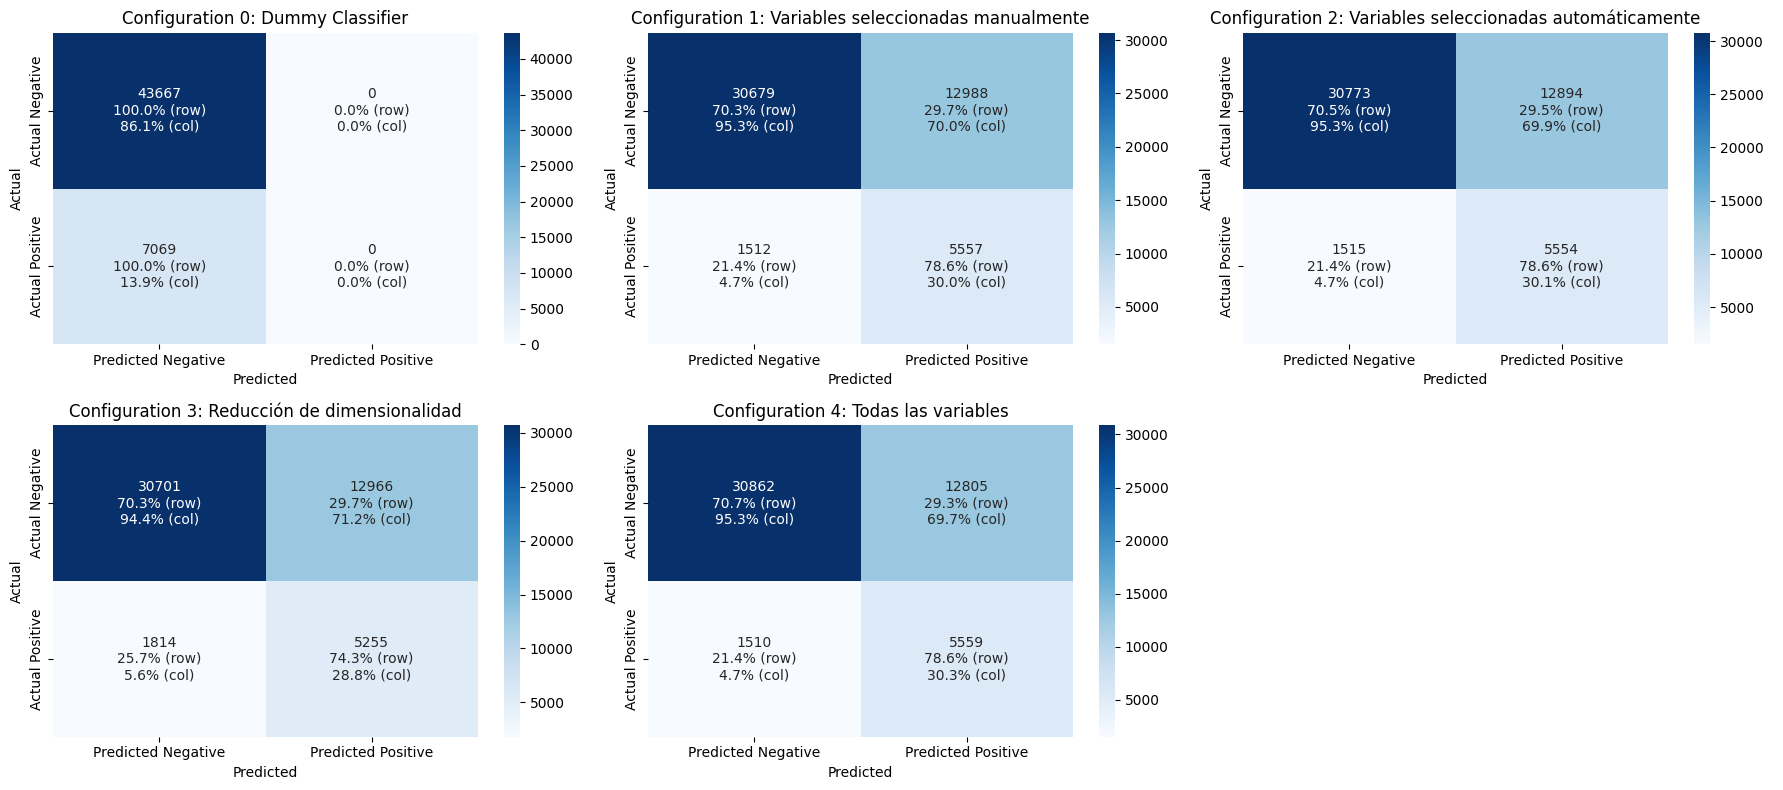

In [31]:
# Resumen y conclusiones de Fase 1

model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_brf_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_brf_aut_sel
    },
    {
        "model": "Configuration 3: Reducción de dimensionalidad",
        **metrics_brf_red_dim
    },
    {
        "model": "Configuration 4: Todas las variables",
        **metrics_brf_all
    }
]

plot_results(model_results)

del model_results

In [33]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_brf_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_brf_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_brf_red_dim['cv_scores'],
    'Configuration 4: all': metrics_brf_all['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

Resultados del Test de Friedman:
 Estadístico Friedman      p-value
                38.72 7.958599e-08

Resultados del Test de Wilcoxon:
                    Primer Modelo           Segundo Modelo  Wilcox V  p-value original  p-value ajustado
Configuration 0: Dummy Classifier Configuration 1: man_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 2: aut_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 3: red_dim       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 1: man_sel Configuration 2: aut_sel       3.0          0.997070          1.000000
         Configuration 1: man_sel Configuration 3: red_dim      55.0          0.000977          0.009766
         Configuration 1: man_sel     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 

### Fase 2: tuning del modelo

En vez de implementar una tecnica de balanceo por asignacion de pesos como class_weight o scale_pos_weight (no disponibles en este clasificador), se va a probar a no implementar undersampling, dado que el clasificador ya lo aplica en cada muestra bootstrap e igual se pierde información

#### Combinación 1: RandomizedSearchCV + Undersampling

In [24]:
metrics_brf_randcv_un = metrics_brf_all

#### Combinación 2: RandomizedSearchCV + none

In [25]:
pipeline = ImbPipeline([
    ('clf_brf', BalancedRandomForestClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_brf, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_brf_randcv_none = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 47.68 minutes
Best Parameters: {'clf_brf__replacement': True, 'clf_brf__n_estimators': 200, 'clf_brf__min_samples_split': 2, 'clf_brf__min_samples_leaf': 4, 'clf_brf__max_features': 0.5, 'clf_brf__max_depth': 10, 'clf_brf__criterion': 'gini'}
Threshold: 0.5
AUC: 0.8238
Accuracy: 0.7235
Recall: 0.7776
Precision: 0.3062
Confusion Matrix:
[[31212 12455]
 [ 1572  5497]]
Cross-Validation AUC: Mean = 0.8282, Std = 0.0033


#### Combinación 3: Optuna + Undersampling

In [26]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
    replacement = trial.suggest_categorical('replacement', [False, True])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('clf_brf', BalancedRandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            replacement=replacement,
            criterion=criterion,
            random_state=42
        ))
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = BalancedRandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    replacement=best_params['replacement'],
    criterion=best_params['criterion'],
    random_state=42
)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_brf', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_brf_opt_un = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-14 19:32:49,358] A new study created in memory with name: no-name-614e2bb3-9c4b-4aef-a39c-e7442cb3be38
[I 2025-04-14 19:33:28,037] Trial 0 finished with value: 0.8273230513519388 and parameters: {'n_estimators': 300, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 1, 'replacement': True, 'criterion': 'gini'}. Best is trial 0 with value: 0.8273230513519388.
[I 2025-04-14 19:33:48,537] Trial 1 finished with value: 0.8213204633933241 and parameters: {'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'replacement': False, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8273230513519388.
[I 2025-04-14 19:34:31,654] Trial 2 finished with value: 0.8121076420234218 and parameters: {'n_estimators': 200, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 1, 'replacement': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.8273230513519388.


Execution time: 34.27 minutes
Best Parameters: {'n_estimators': 300, 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 2, 'replacement': True, 'criterion': 'gini'}
Threshold: 0.5
AUC: 0.8227
Accuracy: 0.7176
Recall: 0.7896
Precision: 0.3030
Confusion Matrix:
[[30828 12839]
 [ 1487  5582]]
Cross-Validation AUC: Mean = 0.8273, Std = 0.0032


#### Combinación 6: Optuna + none

In [27]:
def objective(trial):
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300])
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])
    min_samples_split = trial.suggest_categorical('min_samples_split', [2, 5, 10])
    min_samples_leaf = trial.suggest_categorical('min_samples_leaf', [1, 2, 4])
    replacement = trial.suggest_categorical('replacement', [False, True])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    pipeline = Pipeline([
        ('clf_brf', BalancedRandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            replacement=replacement,
            criterion=criterion,
            random_state=42
        ))
    ])
    
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = BalancedRandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    replacement=best_params['replacement'],
    criterion=best_params['criterion'],
    random_state=42
)
pipeline = Pipeline([
    ('clf_brf', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_brf_opt_none = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-14 20:07:50,943] A new study created in memory with name: no-name-19cba4e3-10d3-4943-a9b4-665615d50ec9
[I 2025-04-14 20:09:11,273] Trial 0 finished with value: 0.8260370458846336 and parameters: {'n_estimators': 300, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'replacement': False, 'criterion': 'gini'}. Best is trial 0 with value: 0.8260370458846336.
[I 2025-04-14 20:09:38,044] Trial 1 finished with value: 0.8264982635470091 and parameters: {'n_estimators': 100, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 2, 'replacement': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8264982635470091.
[I 2025-04-14 20:11:42,097] Trial 2 finished with value: 0.816256722741264 and parameters: {'n_estimators': 300, 'max_depth': None, 'max_features': 0.5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'replacement': False, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8264982635470091.

Execution time: 56.47 minutes
Best Parameters: {'n_estimators': 200, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 4, 'replacement': True, 'criterion': 'entropy'}
Threshold: 0.5
AUC: 0.8240
Accuracy: 0.7414
Recall: 0.7553
Precision: 0.3191
Confusion Matrix:
[[32275 11392]
 [ 1730  5339]]
Cross-Validation AUC: Mean = 0.8282, Std = 0.0033


#### Resumen y conclusiones

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Combination 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000117
1,Combination 1: RandomizedSearchCV + Undersampling,0.822379,0.717853,0.786391,0.302712,0.827481,0.003190,30.558032
2,Combination 3: RandomizedSearchCV + none,0.823804,0.723530,0.777621,0.306205,0.828247,0.003305,47.677996
3,Combination 4: Optuna + Undersampling,0.822719,0.717636,0.789645,0.303024,0.827350,0.003179,34.266458
4,Combination 6: Optuna + none,0.823972,0.741367,0.755269,0.319108,0.828169,0.003291,56.471750


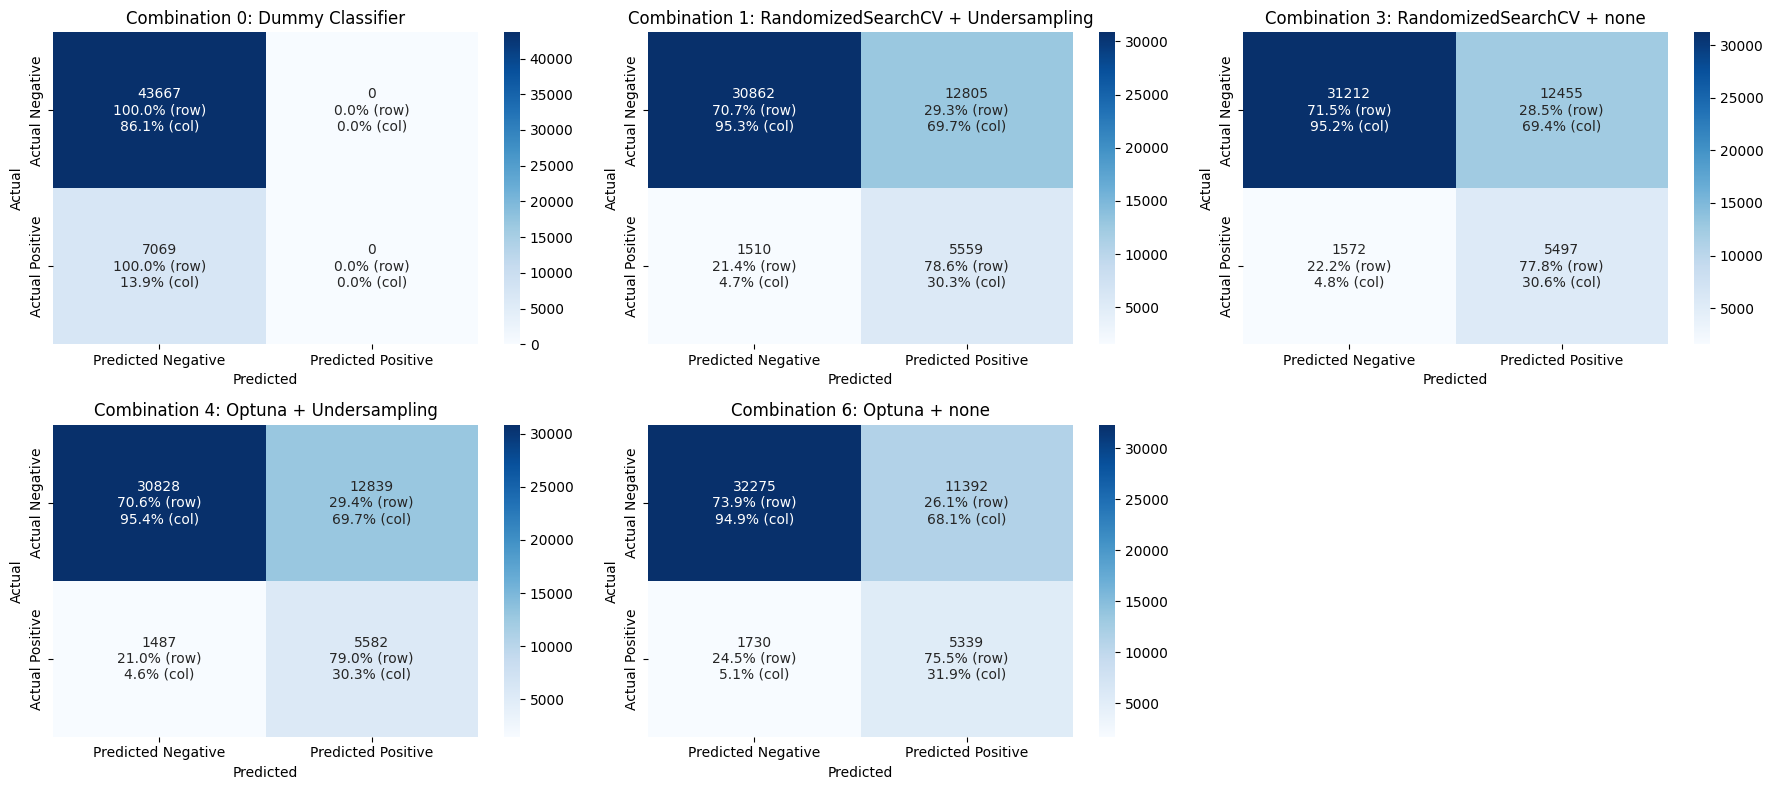

In [28]:
# Resumen y conclusiones de Fase 2

model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_brf_randcv_un
    },
    {
        "model": "Combination 3: RandomizedSearchCV + none",
        **metrics_brf_randcv_none
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_brf_opt_un
    },
    {
        "model": "Combination 6: Optuna + none",
        **metrics_brf_opt_none
    }
]

plot_results(model_results)

del model_results

In [29]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_brf_randcv_un['cv_scores'],
    'Combination 3: RandCV + wght': metrics_brf_randcv_none['cv_scores'],
    'Combination 4: Opt + Un': metrics_brf_opt_un['cv_scores'],
    'Combination 6: Opt + wght': metrics_brf_opt_none['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

Resultados del Test de Friedman:
 Estadístico Friedman  p-value
                28.56  0.00001

Resultados del Test de Wilcoxon:
                  Primer Modelo               Segundo Modelo  Wilcox V  p-value original  p-value ajustado
Combination 0: Dummy Classifier   Combination 1: RandCV + Un       0.0          1.000000          1.000000
Combination 0: Dummy Classifier Combination 3: RandCV + wght       0.0          1.000000          1.000000
Combination 0: Dummy Classifier      Combination 4: Opt + Un       0.0          1.000000          1.000000
Combination 0: Dummy Classifier    Combination 6: Opt + wght       0.0          1.000000          1.000000
     Combination 1: RandCV + Un Combination 3: RandCV + wght       3.0          0.997070          1.000000
     Combination 1: RandCV + Un      Combination 4: Opt + Un      48.0          0.018555          0.185547
     Combination 1: RandCV + Un    Combination 6: Opt + wght       4.0          0.995117          1.000000
   Combination 

### Final model

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


El umbral óptimo es: 0.81


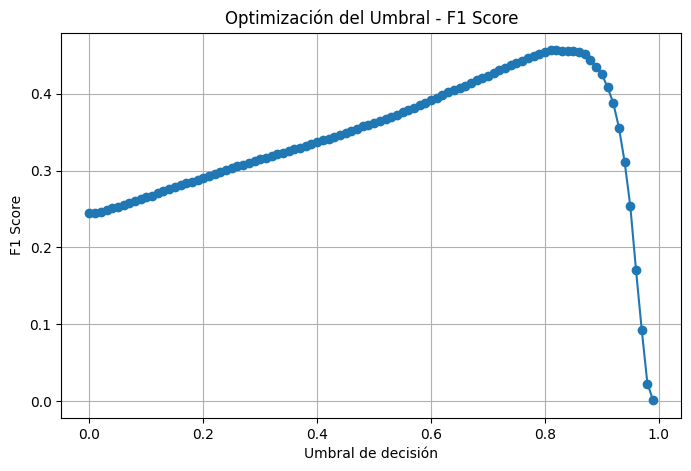

In [32]:
final_pipeline_brf = ImbPipeline([
    ('clf_brf', BalancedRandomForestClassifier(
        random_state=42,
        n_estimators=200,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=4,
        max_features='sqrt',
        replacement=True,
        criterion='entropy',
        class_weight='balanced'
    ))
])

optimal_threshold = maximize_f1_score(final_pipeline_brf, X_train, y_train)

In [35]:
start_time = time.time()
final_pipeline_brf.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(final_pipeline_brf, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

# Se utiliza el valor del umbral óptimo en la función de evaluación
metrics_brf_final = evaluate_and_return_metrics(final_pipeline_brf, X_test, y_test,
                                                execution_time, 
                                                {
                                                  'n_estimators': 200,
                                                  'max_depth': 20,
                                                  'min_samples_split': 5,
                                                  'min_samples_leaf': 4,
                                                  'max_features': 'sqrt',
                                                  'replacement': True,
                                                  'criterion': 'entropy',
                                                  'class_weight': 'balanced'
                                                },
                                                cv_scores,
                                                threshold=optimal_threshold)

del start_time, end_time, execution_time, cv_scores, optimal_threshold

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Execution time: 0.31 minutes
Best Parameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'replacement': True, 'criterion': 'entropy', 'class_weight': 'balanced'}
Threshold: 0.81
AUC: 0.8210
Accuracy: 0.7762
Recall: 0.6752
Precision: 0.3451
Confusion Matrix:
[[34608  9059]
 [ 2296  4773]]
Cross-Validation AUC: Mean = 0.8250, Std = 0.0035


Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Final Model: Balanced Random Forest,0.820975,0.776194,0.675202,0.345069,0.825031,0.003549,0.307116


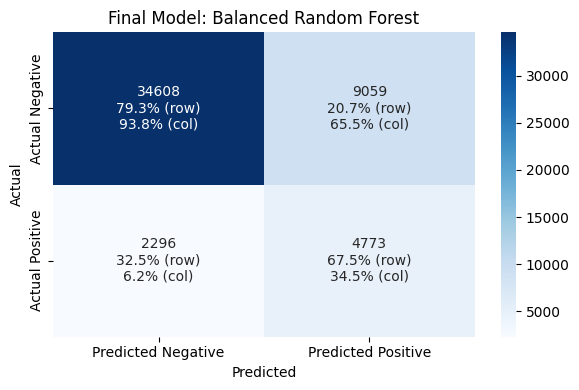

In [39]:
model_results = [
    {
        "model": "Final Model: Balanced Random Forest",
        **metrics_brf_final
    }
]
plot_results(model_results)

del model_results

In [ ]:
final_model_brf = final_pipeline_brf.named_steps['clf_brf']

plot_shap_tree(final_model_brf, X_train, X_test)

del final_model_brf, final_pipeline_brf

## LightGBM
Más rápido y eficiente que GradientBoostingClassifier, ideal para datasets grandes.

### Fase 1: tuning de los datos

#### Configuración 1: variables seleccionadas manualmente

In [18]:
# Definición del espacio de hiperparámetros para LightGBM
param_distributions_lgb = {
    'clf_lgb__n_estimators': [100, 300, 500],
    'clf_lgb__max_depth': [-1, 10, 20, 30, 40],
    'clf_lgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'clf_lgb__num_leaves': [20, 31, 40, 50],
    'clf_lgb__min_child_samples': [5, 10, 20],
    'clf_lgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__reg_alpha': [0.0, 0.5, 1.0],
    'clf_lgb__reg_lambda': [0.0, 0.5, 1.0]
}

In [19]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lgb', LGBMClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_man_sel = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Execution time: 4.21 minutes
Best Parameters: {'clf_lgb__subsample': 0.9, 'clf_lgb__reg_lambda': 0.0, 'clf_lgb__reg_alpha': 0.0, 'clf_lgb__num_leaves': 20, 'clf_lgb__n_estimators': 500, 'clf_lgb__min_child_samples': 20, 'clf_lgb__max_depth': 40, 'clf_lgb__learning_rate': 0.01, 'clf_lgb__colsample_bytree': 0.6}
Threshold: 0.5
AUC: 0.8231
Accuracy: 0.7165
Recall: 0.7906
Precision: 0.3022
Confusion Matrix:
[[30764 12903]
 [ 1480  5589]]
Cross-Validation AUC: Mean = 0.8270, Std = 0.0032


#### Configuración 2: variables seleccionadas automáticamente

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(LGBMClassifier(n_estimators=100, random_state=42))),
    ('clf_lgb', LGBMClassifier(random_state=42))
])

param_distributions_sfm_lgb = {
    'selector__estimator__n_estimators': [50, 100, 150],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_lgb__n_estimators': [100, 300, 500],
    'clf_lgb__max_depth': [-1, 10, 20, 30, 40],
    'clf_lgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'clf_lgb__num_leaves': [20, 31, 40, 50],
    'clf_lgb__min_child_samples': [5, 10, 20],
    'clf_lgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__reg_alpha': [0.0, 0.5, 1.0],
    'clf_lgb__reg_lambda': [0.0, 0.5, 1.0]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_sfm_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm_lgb, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Execution time: 5.18 minutes
Best Parameters: {'selector__threshold': 0.05, 'selector__estimator__n_estimators': 150, 'clf_lgb__subsample': 0.8, 'clf_lgb__reg_lambda': 0.0, 'clf_lgb__reg_alpha': 0.5, 'clf_lgb__num_leaves': 50, 'clf_lgb__n_estimators': 500, 'clf_lgb__min_child_samples': 5, 'clf_lgb__max_depth': -1, 'clf_lgb__learning_rate': 0.01, 'clf_lgb__colsample_bytree': 0.6}
Threshold: 0.5
AUC: 0.8268
Accuracy: 0.7199
Recall: 0.7932
Precision: 0.3054
Confusion Matrix:
[[30917 12750]
 [ 1462  5607]]
Cross-Validation AUC: Mean = 0.8306, Std = 0.0031
Variables seleccionadas: ['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income']


#### Combinación 3: reducción de dimensionalidad

In [21]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_lgb', LGBMClassifier(random_state=42))
])

param_distributions_umap_lgb = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_lgb__n_estimators': [100, 300, 500],
    'clf_lgb__max_depth': [-1, 10, 20, 30, 40],
    'clf_lgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'clf_lgb__num_leaves': [20, 31, 40, 50],
    'clf_lgb__min_child_samples': [5, 10, 20],
    'clf_lgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_lgb__reg_alpha': [0.0, 0.5, 1.0],
    'clf_lgb__reg_lambda': [0.0, 0.5, 1.0]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_umap_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap_lgb, start_time, search, end_time, execution_time, best_model, cv_scores


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\

[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Execution time: 100.93 minutes
Best Parameters: {'umap__n_neighbors': 30, 'umap__n_components': 7, 'umap__min_dist': 0.3, 'clf_lgb__subsample': 1.0, 'clf_lgb__reg_lambda': 0.5, 'clf_lgb__reg_alpha': 1.0, 'clf_lgb__num_leaves': 50, 'clf_lgb__n_estimators': 500, 'clf_lgb__min_child_samples': 20, 'clf_lgb__max_depth': -1, 'clf_lgb__learning_rate': 0.001, 'clf_lgb__colsample_bytree': 0.6}
Threshold: 0.5
AUC: 0.7533
Accuracy: 0.7206
Recall: 0.7199
Precision: 0.2944
Confusion Matrix:
[[31470 12197]
 [ 1980  5089]]
Cross-Validation AUC: Mean = 0.7565, Std = 0.0030


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### Combinación 4: todas las variables

In [22]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_lgb', LGBMClassifier(random_state=42))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_all = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Execution time: 3.88 minutes
Best Parameters: {'clf_lgb__subsample': 1.0, 'clf_lgb__reg_lambda': 1.0, 'clf_lgb__reg_alpha': 0.0, 'clf_lgb__num_leaves': 20, 'clf_lgb__n_estimators': 100, 'clf_lgb__min_child_samples': 5, 'clf_lgb__max_depth': 40, 'clf_lgb__learning_rate': 0.1, 'clf_lgb__colsample_bytree': 0.8}
Threshold: 0.5
AUC: 0.8262
Accuracy: 0.7213
Recall: 0.7885
Precision: 0.3059
Confusion Matrix:
[[31020 12647]
 [ 1495  5574]]
Cross-Validation AUC: Mean = 0.8303, Std = 0.0033


#### Resumen y conclusiones

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Configuration 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000193
1,Configuration 1: Variables seleccionadas manualmente,0.823071,0.716513,0.790635,0.302239,0.826968,0.003197,4.213855
2,Configuration 2: Variables seleccionadas automáticamente,0.826769,0.719883,0.793181,0.305442,0.830626,0.003139,5.180643
3,Configuration 3: Reducción de dimensionalidad,0.753310,0.720573,0.719904,0.294400,0.756526,0.002958,100.930778
4,Configuration 4: Todas las variables,0.826237,0.721263,0.788513,0.305911,0.830308,0.003338,3.880472


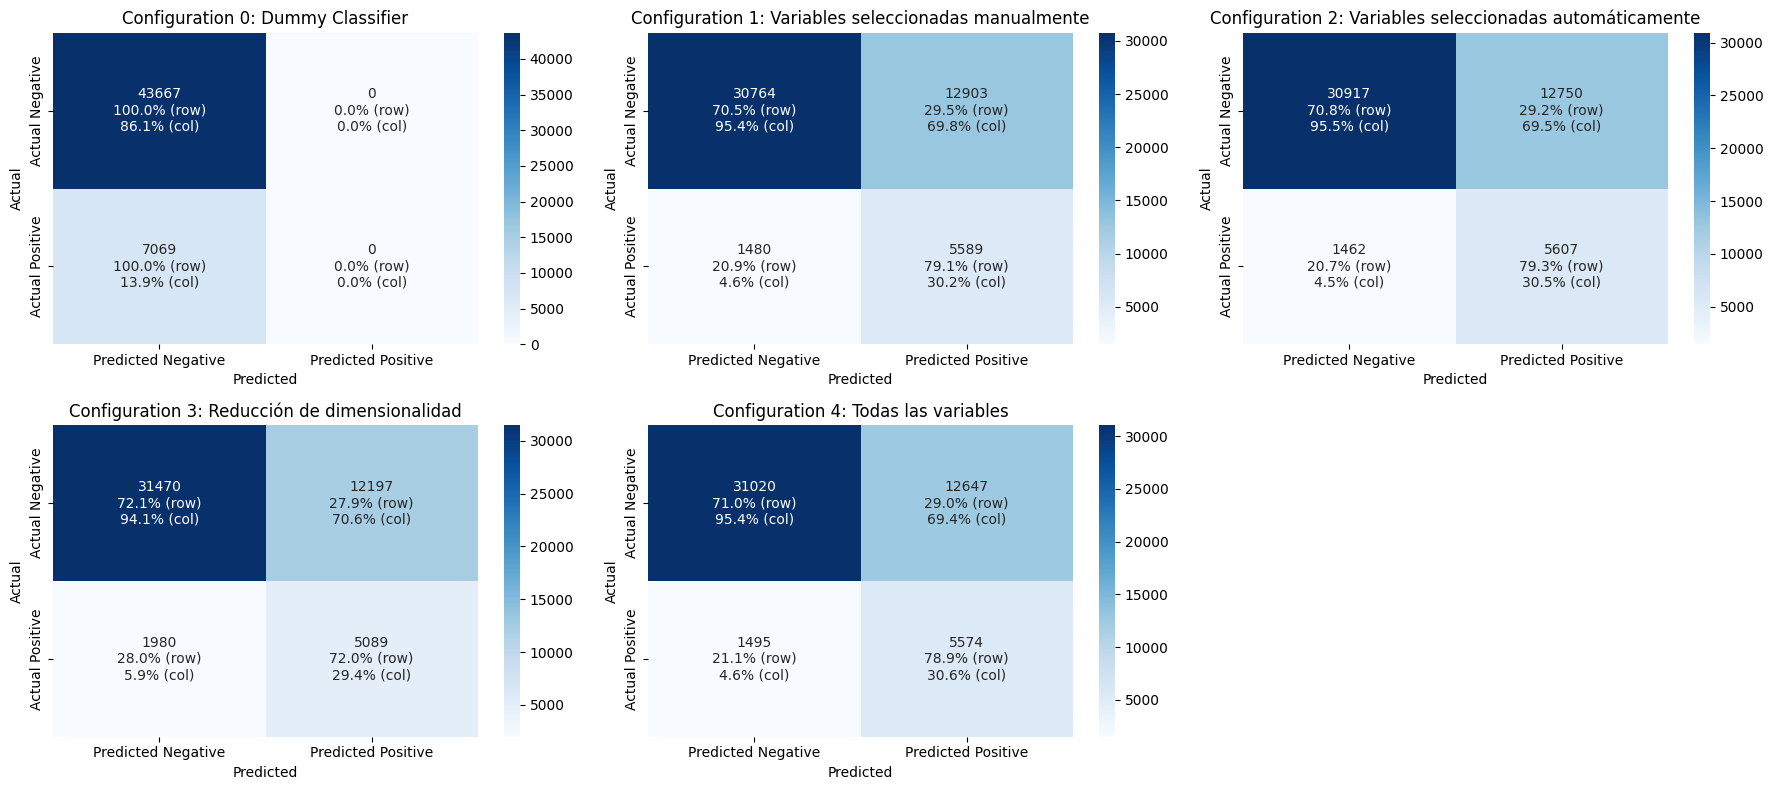

In [23]:
model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_lgb_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_lgb_aut_sel
    },
    {
        "model": "Configuration 3: Reducción de dimensionalidad",
        **metrics_lgb_red_dim
    },
    {
        "model": "Configuration 4: Todas las variables",
        **metrics_lgb_all
    }
]

plot_results(model_results)

del model_results

In [24]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_lgb_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_lgb_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_lgb_red_dim['cv_scores'],
    'Configuration 4: all': metrics_lgb_all['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

Resultados del Test de Friedman:
 Estadístico Friedman      p-value
                39.28 6.097700e-08

Resultados del Test de Wilcoxon:
                    Primer Modelo           Segundo Modelo  Wilcox V  p-value original  p-value ajustado
Configuration 0: Dummy Classifier Configuration 1: man_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 2: aut_sel       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier Configuration 3: red_dim       0.0          1.000000          1.000000
Configuration 0: Dummy Classifier     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 1: man_sel Configuration 2: aut_sel       0.0          1.000000          1.000000
         Configuration 1: man_sel Configuration 3: red_dim      55.0          0.000977          0.009766
         Configuration 1: man_sel     Configuration 4: all       0.0          1.000000          1.000000
         Configuration 

### Fase 2: tuning del modelo

Como class_weight no existe en LGBM, se probó a emplear el parámetro scale_pos_weight. Sin embargo, algunas combinaciones de valores causaban que el selector eliminara demasiadas (o incluso todas) variables. Como resultado, LightGBM recibía una matriz de datos incompleta o mal formada y generaba errores como “Unknown token diabetes_binary in data file”. Así, se ha optado por emplear el parámetro is_unbalance en su lugar.

#### Combinación 1: RandomizedSearchCV + Undersampling

In [42]:
metrics_lgb_randcv_un = metrics_lgb_aut_sel

#### Combination 3: RandomizedSearchCV + is_unbalance

In [75]:
pipeline = ImbPipeline([
    ('selector', SelectFromModel(LGBMClassifier(random_state=42))),
    ('clf_lgb', LGBMClassifier(random_state=42, is_unbalance=True))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_randcv_wght = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,018216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,004361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 166
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Execution time: 10.94 minutes
Best Parameters: {'clf_lgb__subsample': 0.7, 'clf_lgb__reg_lambda': 0.5, 'clf_lgb__reg_alpha': 0.5, 'clf_lgb__num_leaves': 20, 'clf_lgb__n_estimators': 500, 'clf_lgb__min_child_samples': 5, 'clf_lgb__max_depth': -1, 'clf_lgb__learning_rate': 0.01, 'clf_lgb__colsample_bytree': 0.9}
Threshold: 0.5
AUC: 0.8037
Accuracy: 0.6970
Recall: 0.7741
Precision: 0.2843
Confusion Matrix:
[[29893 13774]
 [ 1597  5472]]
Cross-Validation AUC: Mean = 0.8085, Std = 0.0034


#### Combination 4: Optuna + Undersampling

In [76]:
def objective(trial):
    selector_n_estimators = trial.suggest_categorical('selector__estimator__n_estimators', [50, 100, 150])
    selector_threshold = trial.suggest_categorical('selector__threshold', ['mean', 'median', 0.01, 0.05])
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 10, 20, 30, 40])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.2, 0.5])
    num_leaves = trial.suggest_categorical('num_leaves', [20, 31, 40, 50])
    min_child_samples = trial.suggest_categorical('min_child_samples', [5, 10, 20])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0])
    reg_alpha = trial.suggest_categorical('reg_alpha', [0.0, 0.5, 1.0])
    reg_lambda = trial.suggest_categorical('reg_lambda', [0.0, 0.5, 1.0])
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('selector', SelectFromModel(
            LGBMClassifier(n_estimators=selector_n_estimators, random_state=42), 
            threshold=selector_threshold
        )),
        ('clf_lgb', LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42
)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(
        LGBMClassifier(n_estimators=best_params['selector__estimator__n_estimators'], random_state=42),
        threshold=best_params['selector__threshold']
    )),
    ('clf_lgb', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_opt_un = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-14 17:45:13,990] A new study created in memory with name: no-name-b12c1b49-8c0d-4b31-af53-2c4c98ff1c43
[I 2025-04-14 17:45:20,610] Trial 0 finished with value: 0.8075184086484521 and parameters: {'selector__estimator__n_estimators': 150, 'selector__threshold': 'mean', 'n_estimators': 300, 'max_depth': -1, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.7, 'reg_alpha': 0.5, 'reg_lambda': 0.0}. Best is trial 0 with value: 0.8075184086484521.
[I 2025-04-14 17:45:25,198] Trial 1 finished with value: 0.8055917812888242 and parameters: {'selector__estimator__n_estimators': 100, 'selector__threshold': 'mean', 'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'num_leaves': 20, 'min_child_samples': 10, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.5, 'reg_lambda': 1.0}. Best is trial 0 with value: 0.8075184086484521.
[I 2025-04-14 17:45:31,346] Trial 2 finished with value: 0.8182111195391826 and parameter

[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Execution time: 6.67 minutes
Best Parameters: {'selector__estimator__n_estimators': 100, 'selector__threshold': 0.05, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.01, 'num_leaves': 40, 'min_child_samples': 20, 'subsample': 0.9, 'colsample_bytree': 0.6, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
Threshold: 0.5
AUC: 0.8267
Accuracy: 0.7201
Recall: 0.7920
Precision: 0.3054
Confusion Matrix:
[[30935 12732]
 [ 1470  5599]]
Cross-Validation AUC: Mean = 0.8306, Std = 0.0032


#### Combinación 6: Optuna + is_unbalance

In [78]:
def objective(trial):
    selector_n_estimators = trial.suggest_categorical('selector__estimator__n_estimators', [50, 100, 150])
    selector_threshold = trial.suggest_categorical('selector__threshold', ['mean', 'median', 0.01, 0.05])
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 10, 20, 30, 40])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.2, 0.5])
    num_leaves = trial.suggest_categorical('num_leaves', [20, 31, 40, 50])
    min_child_samples = trial.suggest_categorical('min_child_samples', [5, 10, 20])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0])
    reg_alpha = trial.suggest_categorical('reg_alpha', [0.0, 0.5, 1.0])
    reg_lambda = trial.suggest_categorical('reg_lambda', [0.0, 0.5, 1.0])
    
    pipeline = ImbPipeline([
        ('selector', SelectFromModel(
            LGBMClassifier(n_estimators=selector_n_estimators, random_state=42),
            threshold=selector_threshold
        )),
        ('clf_lgb', LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            is_unbalanced=True,
            random_state=42
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
pipeline = ImbPipeline([
    ('selector', SelectFromModel(
        LGBMClassifier(n_estimators=best_params['selector__estimator__n_estimators'], random_state=42),
        threshold=best_params['selector__threshold']
    )),
    ('clf_lgb', LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    is_unbalanced=True,
    random_state=42
    ))
])

pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_opt_wght = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-14 18:09:12,447] A new study created in memory with name: no-name-8d66d40c-328e-4f3d-b151-063ffd464ec8
[I 2025-04-14 18:09:27,675] Trial 0 finished with value: 0.8214710437735355 and parameters: {'selector__estimator__n_estimators': 50, 'selector__threshold': 0.01, 'n_estimators': 500, 'max_depth': 40, 'learning_rate': 0.2, 'num_leaves': 40, 'min_child_samples': 20, 'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.0, 'reg_lambda': 0.0}. Best is trial 0 with value: 0.8214710437735355.
[I 2025-04-14 18:09:39,682] Trial 1 finished with value: 0.8233906860721436 and parameters: {'selector__estimator__n_estimators': 100, 'selector__threshold': 'median', 'n_estimators': 300, 'max_depth': 30, 'learning_rate': 0.1, 'num_leaves': 40, 'min_child_samples': 20, 'subsample': 0.6, 'colsample_bytree': 0.9, 'reg_alpha': 0.0, 'reg_lambda': 0.5}. Best is trial 1 with value: 0.8233906860721436.
[I 2025-04-14 18:09:53,174] Trial 2 finished with value: 0.822099798670132 and parameters: 

[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,007873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,009493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Execution time: 8.81 minutes
Best Parameters: {'selector__estimator__n_estimators': 100, 'selector__threshold': 0.05, 'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 1.

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


#### Combinación 9: RandomizedSearchCV + Undersampling + is_unbalance

In [79]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(LGBMClassifier(random_state=42))),
    ('clf_lgb', LGBMClassifier(random_state=42, is_unbalanced=True))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_lgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_randcv_un_wght = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\s

[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 170
[LightGBM] [Info] Number of data points in the train set: 56

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: is_unbalanced
Execution time: 3.74 minutes
Best Parameters: {'clf_lgb__subsample': 0.9, 'clf_lgb__reg_lambda': 0.5, 'clf_lgb__reg_alpha': 0.5, 'clf_lgb__num_leaves': 20, 'clf_lgb__n_estimators': 500, 'clf_lgb__min_child_samples': 10, 'clf_lgb__max_depth': -1, 'clf_lgb__learning_rate': 0.01, 'clf_lgb__colsample_bytree': 0.9}
Threshold: 0.5
AUC: 0.8040
Accuracy: 0.6958
Recall: 0.7812
Precision: 0.2845
Confusion Matrix:
[[29782 13885]
 [ 1547  5522]]
Cross-Validation AUC: Mean = 0.8079, Std = 0.0034


#### Combinación 12: Optuna + Undersampling + is_unbalance

In [80]:
def objective(trial):
    selector_n_estimators = trial.suggest_categorical('selector__estimator__n_estimators', [50, 100, 150])
    selector_threshold = trial.suggest_categorical('selector__threshold', ['mean', 'median', 0.01, 0.05])
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [-1, 10, 20, 30, 40])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.2, 0.5])
    num_leaves = trial.suggest_categorical('num_leaves', [20, 31, 40, 50])
    min_child_samples = trial.suggest_categorical('min_child_samples', [5, 10, 20])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0])
    reg_alpha = trial.suggest_categorical('reg_alpha', [0.0, 0.5, 1.0])
    reg_lambda = trial.suggest_categorical('reg_lambda', [0.0, 0.5, 1.0])
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('selector', SelectFromModel(
            LGBMClassifier(n_estimators=selector_n_estimators, random_state=42),
            threshold=selector_threshold
        )),
        ('clf_lgb', LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            is_unbalanced=True,
            random_state=42
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    num_leaves=best_params['num_leaves'],
    min_child_samples=best_params['min_child_samples'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    is_unbalanced=True,
    random_state=42
)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(
        LGBMClassifier(n_estimators=best_params['selector__estimator__n_estimators'], random_state=42),
        threshold=best_params['selector__threshold']
    )),
    ('clf_lgb', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_lgb_opt_un_wght = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

[I 2025-04-14 18:22:01,168] A new study created in memory with name: no-name-e45aae74-8b0d-4156-b084-592f377a578a
[I 2025-04-14 18:22:05,419] Trial 0 finished with value: 0.8017564261766653 and parameters: {'selector__estimator__n_estimators': 150, 'selector__threshold': 'mean', 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.2, 'num_leaves': 20, 'min_child_samples': 5, 'subsample': 0.9, 'colsample_bytree': 1.0, 'reg_alpha': 0.5, 'reg_lambda': 0.5}. Best is trial 0 with value: 0.8017564261766653.
[I 2025-04-14 18:22:08,231] Trial 1 finished with value: 0.8175588512493335 and parameters: {'selector__estimator__n_estimators': 100, 'selector__threshold': 0.05, 'n_estimators': 100, 'max_depth': 40, 'learning_rate': 0.5, 'num_leaves': 40, 'min_child_samples': 5, 'subsample': 0.6, 'colsample_bytree': 0.8, 'reg_alpha': 0.5, 'reg_lambda': 1.0}. Best is trial 1 with value: 0.8175588512493335.
[I 2025-04-14 18:22:10,664] Trial 2 finished with value: 0.8202882099110441 and parameters: {'

[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56554, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 28277, number of negative: 28277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,002108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 56

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: is_unbalanced
Execution time: 5.34 minutes
Best Parameters: {'selector__estimator__n_estimators': 100, 'selector__threshold': 0.01, 'n_estimators': 500, 'max_depth': 30, 'learning_rate': 0.01, 'num_leaves': 31, 'min_child_samples': 20, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 0.0, 'reg_lambda': 0.0}
Threshold: 0.5
AUC: 0.8266
Accuracy: 0.7206
Recall: 0.7920
Precision: 0.3059
Confusion Matrix:
[[30961 12706]
 [ 1470  5599]]
Cross-Validation AUC: Mean = 0.8305, Std = 0.0032


#### Resultados y conclusiones

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Combination 0: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000177
1,Combination 1: RandomizedSearchCV + Undersampling,0.826769,0.719883,0.793181,0.305442,0.830626,0.003139,5.180643
2,Combination 3: RandomizedSearchCV + is_unbalance,0.803727,0.697040,0.774084,0.284319,0.808536,0.003395,10.936312
3,Combination 4: Optuna + Undersampling,0.826684,0.720080,0.792050,0.305439,0.830636,0.003195,6.673717
4,Combination 6: Optuna + is_unbalance,0.827087,0.865677,0.164238,0.561412,0.831250,0.003474,8.806757
5,Combination 9: RandomizedSearchCV + Undersampling + is_unbalance,0.803971,0.695837,0.781157,0.284537,0.807935,0.003368,3.738660
6,Combination 12: Optuna + Undersampling + is_unbalance,0.826589,0.720593,0.792050,0.305873,0.830498,0.003197,5.344152


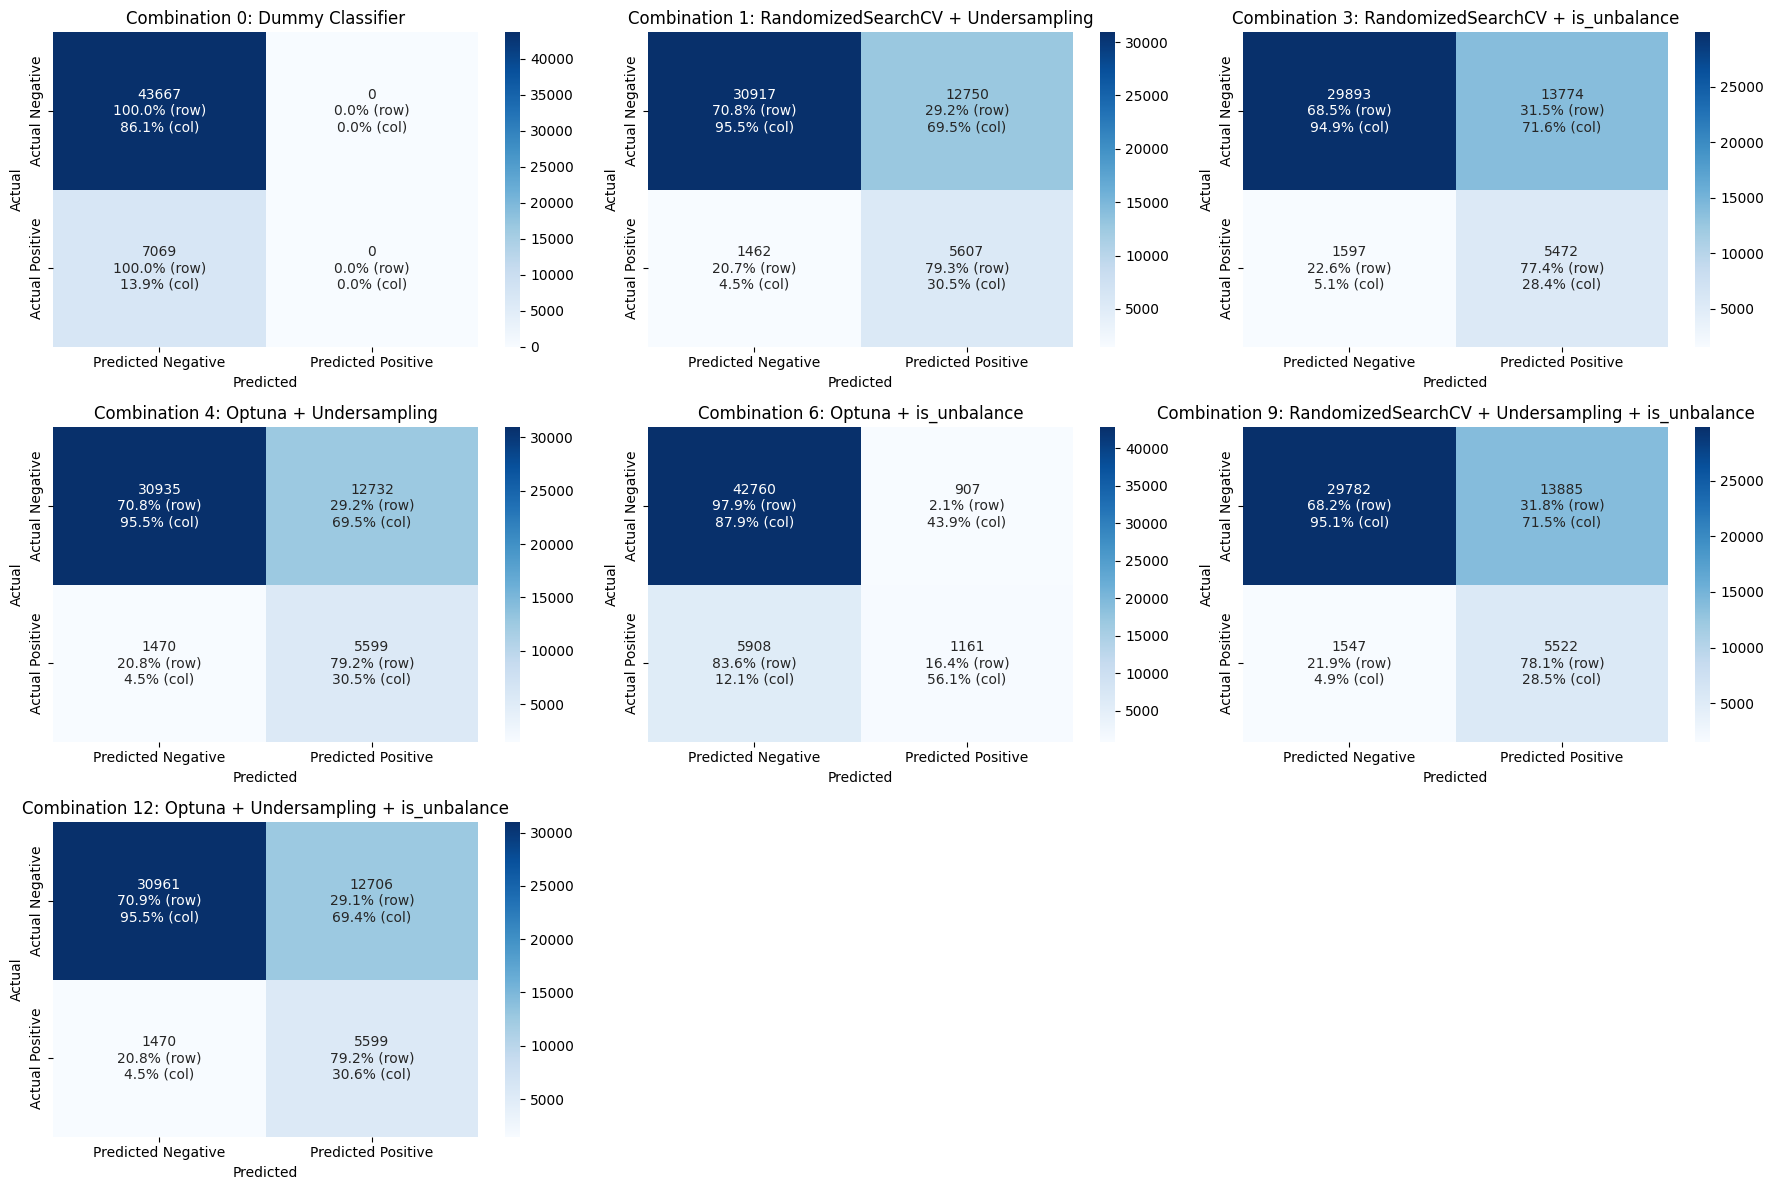

In [22]:
model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_lgb_randcv_un
    },
    {
        "model": "Combination 3: RandomizedSearchCV + is_unbalance",
        **metrics_lgb_randcv_wght
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_lgb_opt_un
    },
    {
        "model": "Combination 6: Optuna + is_unbalance",
        **metrics_lgb_opt_wght
    },
    {
        "model": "Combination 9: RandomizedSearchCV + Undersampling + is_unbalance",
        **metrics_lgb_randcv_un_wght
    },
    {
        "model": "Combination 12: Optuna + Undersampling + is_unbalance",
        **metrics_lgb_opt_un_wght
    }
]

plot_results(model_results)

del model_results

In [82]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_lgb_randcv_un['cv_scores'],
    'Combination 3: RandCV + wght': metrics_lgb_randcv_wght['cv_scores'],
    'Combination 4: Opt + Un': metrics_lgb_opt_un['cv_scores'],
    'Combination 6: Opt + wght': metrics_lgb_opt_wght['cv_scores'],
    'Combination 9: RandCV + Un + wght': metrics_lgb_randcv_un_wght['cv_scores'],
    'Combination 12: Opt + Un + wght': metrics_lgb_opt_un_wght['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

Resultados del Test de Friedman:
 Estadístico Friedman      p-value
            52.157143 1.733939e-09

Resultados del Test de Wilcoxon:
                    Primer Modelo                    Segundo Modelo  Wilcox V  p-value original  p-value ajustado
  Combination 0: Dummy Classifier        Combination 1: RandCV + Un       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier      Combination 3: RandCV + wght       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier           Combination 4: Opt + Un       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier         Combination 6: Opt + wght       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier Combination 9: RandCV + Un + wght       0.0          1.000000          1.000000
  Combination 0: Dummy Classifier   Combination 12: Opt + Un + wght       0.0          1.000000          1.000000
       Combination 1: RandCV + Un      Combination 3: RandCV + wg

### Final model

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,008225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,008700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] Unknown parameter: is_unbalanced
El umbral óptimo es: 0.24


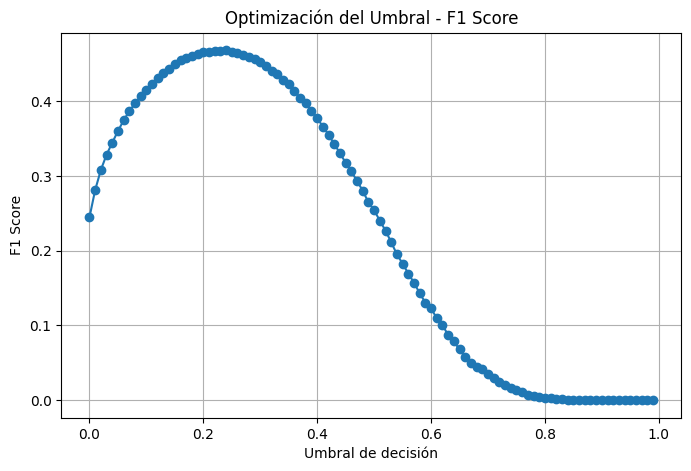

In [36]:
final_pipeline_lgb = ImbPipeline([
    ('selector', SelectFromModel(
        LGBMClassifier(n_estimators=100, random_state=42),
        threshold=0.05
    )),
    ('clf_lgb', LGBMClassifier(
    n_estimators=100,
    max_depth=30,
    learning_rate=0.1,
    num_leaves=50,
    min_child_samples=10,
    subsample=0.6,
    colsample_bytree=0.6,
    reg_alpha=1.0,
    reg_lambda=1.0,
    is_unbalanced=True,
    random_state=42
    ))
])

optimal_threshold = maximize_f1_score(final_pipeline_lgb, X_train, y_train)

In [37]:
start_time = time.time()
final_pipeline_lgb.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(final_pipeline_lgb, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

# Se pasa el valor del umbral óptimo a la función de evaluación para realizar la predicción
# utilizando el umbral ajustado en lugar del valor por defecto (0.5).
metrics_lgb_final = evaluate_and_return_metrics(final_pipeline_lgb, X_test, y_test, execution_time, {
    'n_estimators': 100,
    'max_depth': 30,
    'learning_rate': 0.1,
    'num_leaves': 50,
    'min_child_samples': 10,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'reg_alpha': 1.0,
    'reg_lambda': 1.0,
    'is_unbalanced': True,
}, cv_scores, threshold=optimal_threshold)

del start_time, end_time, execution_time, cv_scores, optimal_threshold

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,008398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 28277, number of negative: 174667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,008959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,139334 -> initscore=-1,820833
[LightGBM] [Info] Start training from score -1,820833
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Execution time: 0.02 minutes
Best Parameters: {'n_estimators': 100, 'max_depth': 30, 'learning_rate': 0.1, 'num_leaves': 50, 'min_child_samples': 10, 'subsample': 0.6, 'colsample_bytree': 0.6, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'is_unbalanced': True}
Threshold: 0.24
AUC: 0.827

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Final Model: LightGBM,0.827087,0.811278,0.595982,0.385382,0.83125,0.003474,0.019105


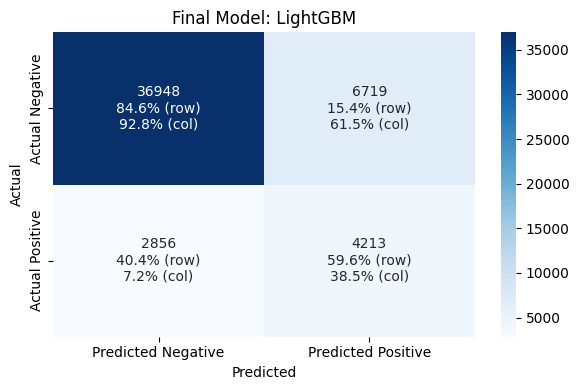

In [38]:
model_results = [
    {
        "model": "Final Model: LightGBM",
        **metrics_lgb_final
    }
]
plot_results(model_results)

del model_results

In [ ]:
final_model_lgb = final_pipeline_lgb.named_steps['clf_lgb']

plot_shap_tree(final_model_lgb, X_train, X_test)

del final_model_lgb, final_pipeline_lgb

## XGBoost
Optimizado para boosting, excelente en datasets tabulares.

La elección del espacio de hiperparámetros para XGBoost se justifica de la siguiente manera:

• **n_estimators ([100, 300, 500]):** Se selecciona un rango que permite probar desde un número moderado hasta uno mayor de árboles. Esto ayuda a balancear entre un modelo con suficiente capacidad para capturar la complejidad de los datos y mantener tiempos de entrenamiento razonables.

• **max_depth ([3, 5, 7, 10, 15]):** La profundidad máxima de los árboles controla la complejidad del modelo. Valores más bajos reducen el riesgo de sobreajuste, mientras que valores más altos permiten modelar relaciones más complejas. El rango abarca desde árboles relativamente simples hasta estructuras más profundas, permitiendo encontrar un equilibrio óptimo.

• **learning_rate (0.001 a 0.5, log=True):** La tasa de aprendizaje es crucial para el proceso de boosting, ya que afecta la rapidez con la que se corrigen los errores. Se utiliza una escala logarítmica para explorar tanto valores muy pequeños, que pueden conducir a un entrenamiento más estable pero lento, como valores más altos, que aceleran el entrenamiento pero podrían generar inestabilidad.

• **subsample (0.6 a 1.0):** Este parámetro define la fracción de muestras utilizadas para entrenar cada árbol. Al variar este valor, se introduce un mecanismo de regularización que puede ayudar a reducir el sobreajuste, ya que cada árbol se entrena con una submuestra diferente de datos.

• **colsample_bytree (0.6 a 1.0):** Similar al subsample, este parámetro determina la fracción de características utilizadas al construir cada árbol. Limitar la cantidad de características ayuda a disminuir la varianza y mejorar la robustez del modelo.

• **gamma (0 a 5):** Este parámetro controla la complejidad del árbol al requerir una reducción mínima en la función de pérdida para que se realice una división. Un valor mayor impone una mayor regularización, lo que ayuda a evitar la creación de árboles excesivamente complejos.

• **reg_alpha (0.0 a 1.0) y reg_lambda (0.0 a 1.0):** Estos parámetros representan la regularización L1 y L2, respectivamente. Incluir estos rangos permite explorar desde una ausencia de regularización hasta niveles moderados, contribuyendo a controlar el sobreajuste y mejorar la generalización del modelo.

• **min_child_weight (1 a 10):** Este parámetro define el peso mínimo acumulado de las instancias en un nodo para que se realice una división. Valores más altos imponen restricciones adicionales, lo que puede prevenir la formación de nodos que modelen patrones demasiado específicos y, por lo tanto, mejorar la robustez del modelo.

además:
* El parámetro **use_label_encoder=False** le indica a XGBoost que no utilice su codificador interno de etiquetas. Por defecto, XGBoost aplica una transformación automática de las etiquetas de la variable objetivo, pero esta funcionalidad puede provocar advertencias en algunos casos. Al establecerlo en False, se evita esa codificación interna y se asume que las etiquetas ya están en el formato adecuado para el entrenamiento.

* El parámetro **eval_metric='logloss'** define la métrica de evaluación que se usará durante el entrenamiento para medir la calidad del modelo. En este caso, se utiliza la "logloss" (pérdida logarítmica), que es muy común en problemas de clasificación binaria. Esta métrica penaliza las predicciones que están lejos de la probabilidad real, ayudando a optimizar el modelo para obtener probabilidades ajustadas y minimizar los errores en las predicciones.

### Fase 1: tuning de datos

#### Configuración 1: variables seleccionadas manualmente

In [30]:
# Definición del espacio de hiperparámetros para XGBoost (configuración manual)
param_distributions_xgb = {
    'clf_xgb__n_estimators': [100, 300, 500],
    'clf_xgb__max_depth': [3, 5, 7, 10, 15],
    'clf_xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'clf_xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_xgb__gamma': [0.0, 1.0, 2.5, 5.0],
    'clf_xgb__reg_alpha': [0.0, 0.5, 1.0],
    'clf_xgb__reg_lambda': [0.0, 0.5, 1.0],
    'clf_xgb__min_child_weight': [1, 5, 10]
}

# Se calcula el scale_pos_weight (por ejemplo, número de negativos / número de positivos)
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [31]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_xgb', XGBClassifier(random_state=42, scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_xgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train_filtered, y_train_filtered)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train_filtered, y_train_filtered, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_man_sel = evaluate_and_return_metrics(best_model, X_test_filtered, y_test_filtered, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

ValueError: 
All the 500 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\imblearn\pipeline.py", line 526, in fit
    self._final_estimator.fit(Xt, yt, **last_step_params["fit"])
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py", line 1682, in fit
    self._Booster = train(
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py", line 183, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 2246, in update
    _check_call(
  File "c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py", line 310, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: Invalid Parameter format for scale_pos_weight expect float but value='Diabetes_binary    6.176999
dtype: float64'


#### Configuración 2: variables seleccionadas automáticamente

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss'))),
    ('clf_xgb', XGBClassifier(random_state=42, scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss'))
])

param_distributions_sfm_xgb = {
    'selector__estimator__n_estimators': [50, 100, 150],
    'selector__threshold': ['mean', 'median', 0.01, 0.05],
    'clf_xgb__n_estimators': [100, 300, 500],
    'clf_xgb__max_depth': [3, 5, 7, 10, 15],
    'clf_xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'clf_xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_xgb__gamma': [0.0, 1.0, 2.5, 5.0],
    'clf_xgb__reg_alpha': [0.0, 0.5, 1.0],
    'clf_xgb__reg_lambda': [0.0, 0.5, 1.0],
    'clf_xgb__min_child_weight': [1, 5, 10]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_sfm_xgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_aut_sel = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

selected_features = X_train.columns[best_model.named_steps['selector'].get_support()].tolist()
print("Variables seleccionadas:", selected_features)

del pipeline, param_distributions_sfm_xgb, start_time, search, end_time, execution_time, best_model, cv_scores, selected_features

#### Configuración 3: reducción de dimensionalidad

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('umap', umap.UMAP(random_state=42)),
    ('clf_xgb', XGBClassifier(random_state=42, scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss'))
])

param_distributions_umap_xgb = {
    'umap__n_components': [3, 5, 7, 10],
    'umap__n_neighbors': [5, 10, 15, 30],
    'umap__min_dist': [0.0, 0.1, 0.2, 0.3],
    'clf_xgb__n_estimators': [100, 300, 500],
    'clf_xgb__max_depth': [3, 5, 7, 10, 15],
    'clf_xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5],
    'clf_xgb__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_xgb__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf_xgb__gamma': [0.0, 1.0, 2.5, 5.0],
    'clf_xgb__reg_alpha': [0.0, 0.5, 1.0],
    'clf_xgb__reg_lambda': [0.0, 0.5, 1.0],
    'clf_xgb__min_child_weight': [1, 5, 10]
}

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions_umap_xgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_red_dim = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, param_distributions_umap_xgb, start_time, search, end_time, execution_time, best_model, cv_scores

#### Configuración 4: todas las variables

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('clf_xgb', XGBClassifier(random_state=42, scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_xgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_all = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

#### Resumen y conclusiones

In [ ]:
model_results = [
    {
        "model": "Configuration 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Configuration 1: Variables seleccionadas manualmente",
        **metrics_xgb_man_sel
    },
    {
        "model": "Configuration 2: Variables seleccionadas automáticamente",
        **metrics_xgb_aut_sel
    },
    {
        "model": "Configuration 3: Reducción de dimensionalidad",
        **metrics_xgb_red_dim
    },
    {
        "model": "Configuration 4: Todas las variables",
        **metrics_xgb_all
    }
]

plot_results(model_results)

del model_results

In [ ]:
cv_scores = {
    'Configuration 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Configuration 1: man_sel': metrics_xgb_man_sel['cv_scores'],
    'Configuration 2: aut_sel': metrics_xgb_aut_sel['cv_scores'],
    'Configuration 3: red_dim': metrics_xgb_red_dim['cv_scores'],
    'Configuration 4: all': metrics_xgb_all['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

### Fase 2: tuning del modelo

#### Combianción 1: RandomizedSearchCV + Undersampling

In [ ]:
metrics_xgb_randcv_un = 

#### Combinación 4: Optuna + Undersampling

In [ ]:
def objective(trial):
    selector_n_estimators = trial.suggest_categorical('selector__estimator__n_estimators', [50, 100, 150])
    selector_threshold = trial.suggest_categorical('selector__threshold', ['mean', 'median', 0.01, 0.05])
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.2, 0.5])
    min_child_weight = trial.suggest_categorical('min_child_weight', [1, 5, 10])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0])
    gamma = trial.suggest_categorical('gamma', [0.0, 1.0, 2.5, 5.0])
    reg_alpha = trial.suggest_categorical('reg_alpha', [0.0, 0.5, 1.0])
    reg_lambda = trial.suggest_categorical('reg_lambda', [0.0, 0.5, 1.0])
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('selector', SelectFromModel(
            XGBClassifier(n_estimators=selector_n_estimators, random_state=42, use_label_encoder=False, eval_metric='logloss'), 
            threshold=selector_threshold
        )),
        ('clf_xgb', XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            scale_pos_weight=pos_weight,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(
        XGBClassifier(n_estimators=best_params['selector__estimator__n_estimators'], random_state=42, use_label_encoder=False, eval_metric='logloss'),
        threshold=best_params['selector__threshold']
    )),
    ('clf_xgb', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_opt_un = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

#### Combinación 6: Optuna + scale_pos_weight

In [ ]:
def objective(trial):
    selector_n_estimators = trial.suggest_categorical('selector__estimator__n_estimators', [50, 100, 150])
    selector_threshold = trial.suggest_categorical('selector__threshold', ['mean', 'median', 0.01, 0.05])
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.2, 0.5])
    min_child_weight = trial.suggest_categorical('min_child_weight', [1, 5, 10])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0])
    gamma = trial.suggest_categorical('gamma', [0.0, 1.0, 2.5, 5.0])
    reg_alpha = trial.suggest_categorical('reg_alpha', [0.0, 0.5, 1.0])
    reg_lambda = trial.suggest_categorical('reg_lambda', [0.0, 0.5, 1.0])
    
    pipeline = ImbPipeline([
        ('selector', SelectFromModel(
            XGBClassifier(n_estimators=selector_n_estimators, random_state=42, use_label_encoder=False, eval_metric='logloss'),
            threshold=selector_threshold
        )),
        ('clf_xgb', XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            scale_pos_weight=pos_weight,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = ImbPipeline([
    ('selector', SelectFromModel(
        XGBClassifier(n_estimators=best_params['selector__estimator__n_estimators'], random_state=42, use_label_encoder=False, eval_metric='logloss'),
        threshold=best_params['selector__threshold']
    )),
    ('clf_xgb', XGBClassifier(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        min_child_weight=best_params['min_child_weight'],
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        gamma=best_params['gamma'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        random_state=42,
        scale_pos_weight=pos_weight,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

best_model.fit(X_train, y_train)

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_opt_wght = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, cv_scores

#### Combinación 9: RandomizedSearchCV + Undersampling + scale_pos_weight

In [ ]:
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))),
    ('clf_xgb', XGBClassifier(random_state=42, scale_pos_weight=pos_weight, use_label_encoder=False, eval_metric='logloss'))
])

start_time = time.time()
search = RandomizedSearchCV(pipeline, param_distributions_xgb, scoring='roc_auc', cv=cv, n_iter=50, n_jobs=n_jobs, random_state=42)
search.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60
best_model = search.best_estimator_

cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_randcv_un_wght = evaluate_and_return_metrics(best_model, X_test, y_test, execution_time, search.best_params_, cv_scores)

del pipeline, start_time, search, end_time, execution_time, best_model, cv_scores

#### Combinación 12: Optuna + Undersampling + scale_pos_weight

In [ ]:
def objective(trial):
    selector_n_estimators = trial.suggest_categorical('selector__estimator__n_estimators', [50, 100, 150])
    selector_threshold = trial.suggest_categorical('selector__threshold', ['mean', 'median', 0.01, 0.05])
    n_estimators = trial.suggest_categorical('n_estimators', [100, 300, 500])
    max_depth = trial.suggest_categorical('max_depth', [3, 5, 7, 10, 15])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1, 0.2, 0.5])
    min_child_weight = trial.suggest_categorical('min_child_weight', [1, 5, 10])
    subsample = trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 0.9, 1.0])
    colsample_bytree = trial.suggest_categorical('colsample_bytree', [0.6, 0.7, 0.8, 0.9, 1.0])
    gamma = trial.suggest_categorical('gamma', [0.0, 1.0, 2.5, 5.0])
    reg_alpha = trial.suggest_categorical('reg_alpha', [0.0, 0.5, 1.0])
    reg_lambda = trial.suggest_categorical('reg_lambda', [0.0, 0.5, 1.0])
    
    pipeline = ImbPipeline([
        ('undersample', RandomUnderSampler(random_state=42)),
        ('selector', SelectFromModel(
            XGBClassifier(n_estimators=selector_n_estimators, random_state=42, use_label_encoder=False, eval_metric='logloss'),
            threshold=selector_threshold
        )),
        ('clf_xgb', XGBClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=42,
            scale_pos_weight=pos_weight,
            use_label_encoder=False,
            eval_metric='logloss'
        ))
    ])
    score = cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=n_jobs).mean()
    return score

start_time = time.time()
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
end_time = time.time()
execution_time = (end_time - start_time) / 60

best_params = study.best_trial.params
best_model = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    random_state=42,
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric='logloss'
)
pipeline = ImbPipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('selector', SelectFromModel(
        XGBClassifier(n_estimators=best_params['selector__estimator__n_estimators'], random_state=42, use_label_encoder=False, eval_metric='logloss'),
        threshold=best_params['selector__threshold']
    )),
    ('clf_xgb', best_model)
])
pipeline.fit(X_train, y_train)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

metrics_xgb_opt_un_wght = evaluate_and_return_metrics(pipeline, X_test, y_test, execution_time, best_params, cv_scores)

del objective, start_time, study, end_time, execution_time, best_params, best_model, pipeline, cv_scores

#### Resultados y conlcusiones

In [ ]:
model_results = [
    {
        "model": "Combination 0: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Combination 1: RandomizedSearchCV + Undersampling",
        **metrics_xgb_randcv_un
    },
    {
        "model": "Combination 3: RandomizedSearchCV + scale_pos_weight",
        **metrics_xgb_randcv_un_wght
    },
    {
        "model": "Combination 4: Optuna + Undersampling",
        **metrics_xgb_opt_un
    },
    {
        "model": "Combination 6: Optuna + scale_pos_weight",
        **metrics_xgb_opt_wght
    },
    {
        "model": "Combination 9: RandomizedSearchCV + Undersampling + scale_pos_weight",
        **metrics_xgb_randcv_un_wght
    },
    {
        "model": "Combination 12: Optuna + Undersampling + scale_pos_weight",
        **metrics_xgb_opt_un_wght
    }
]

plot_results(model_results)

del model_results

In [ ]:
cv_scores = {
    'Combination 0: Dummy Classifier': metrics_dummy['cv_scores'],
    'Combination 1: RandCV + Un': metrics_xgb_randcv_un['cv_scores'],
    'Combination 3: RandCV + wght': metrics_xgb_randcv_un_wght['cv_scores'],
    'Combination 4: Optuna + Un': metrics_xgb_opt_un['cv_scores'],
    'Combination 6: Optuna + wght': metrics_xgb_opt_wght['cv_scores'],
    'Combination 9: RandCV + Un + wght': metrics_xgb_randcv_un_wght['cv_scores'],
    'Combination 12: Optuna + Un + wght': metrics_xgb_opt_un_wght['cv_scores']
}

perform_stat_tests(cv_scores)

del cv_scores

### Final model

In [ ]:
# Cálculo del valor de scale_pos_weight
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

final_pipeline_xgb = ImbPipeline([
    ('clf_xgb', XGBClassifier(
        random_state=42, 
        n_estimators=500,
        max_depth=10,         # Ejemplo: se ha fijado a 10 (dentro del rango [3, 5, 7, 10, 15])
        learning_rate=0.1,
        min_child_weight=1,   # Ejemplo: valor seleccionado
        subsample=1.0,
        colsample_bytree=1.0,
        gamma=0.0,
        reg_alpha=0.0,
        reg_lambda=0.0,
        scale_pos_weight=pos_weight,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

optimal_threshold = maximize_f1_score(final_pipeline_xgb, X_train, y_train)

In [ ]:
start_time = time.time()
final_pipeline_xgb.fit(X_train, y_train)
end_time = time.time()
execution_time = (end_time - start_time) / 60

cv_scores = cross_val_score(final_pipeline_xgb, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=n_jobs)

# Se pasa el valor del umbral óptimo a la función de evaluación para realizar la predicción
metrics_xgb_final = evaluate_and_return_metrics(final_pipeline_xgb, X_test, y_test, execution_time, {
    'n_estimators': 500,
    'max_depth': 10,
    'learning_rate': 0.1,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'gamma': 0.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}, cv_scores, threshold=optimal_threshold)

del start_time, end_time, execution_time, cv_scores, optimal_threshold

In [ ]:
model_results = [
    {
        "model": "Final Model: XGBoost",
        **metrics_xgb_final
    }
]
plot_results(model_results)

del model_results

In [ ]:
final_model_xgb = final_pipeline_xgb.named_steps['clf_xgb']

plot_shap_tree(final_model_xgb, X_train, X_test)

del final_model_xgb, final_pipeline_xgb

# Resultados finales

Summary Table:


,Model,AUC,Accuracy,Recall,Precision,Score Mean,Score Std,Execution Time (minutes)
0,Final Model: Dummy Classifier,0.500000,0.860671,0.000000,0.000000,0.500000,0.000000,0.000117
1,Final Model: Logistic Regression,0.819485,0.781615,0.661197,0.349876,0.823256,0.002846,0.155900
2,Final Model: Random Forest Classifier,0.822821,0.805602,0.605178,0.376916,0.827523,0.003363,0.812605
3,Final Model: Balanced Random Forest Classifier,0.820975,0.776194,0.675202,0.345069,0.825031,0.003549,0.307116
4,Final Model: LightGBM,0.827087,0.811278,0.595982,0.385382,0.831250,0.003474,0.019105


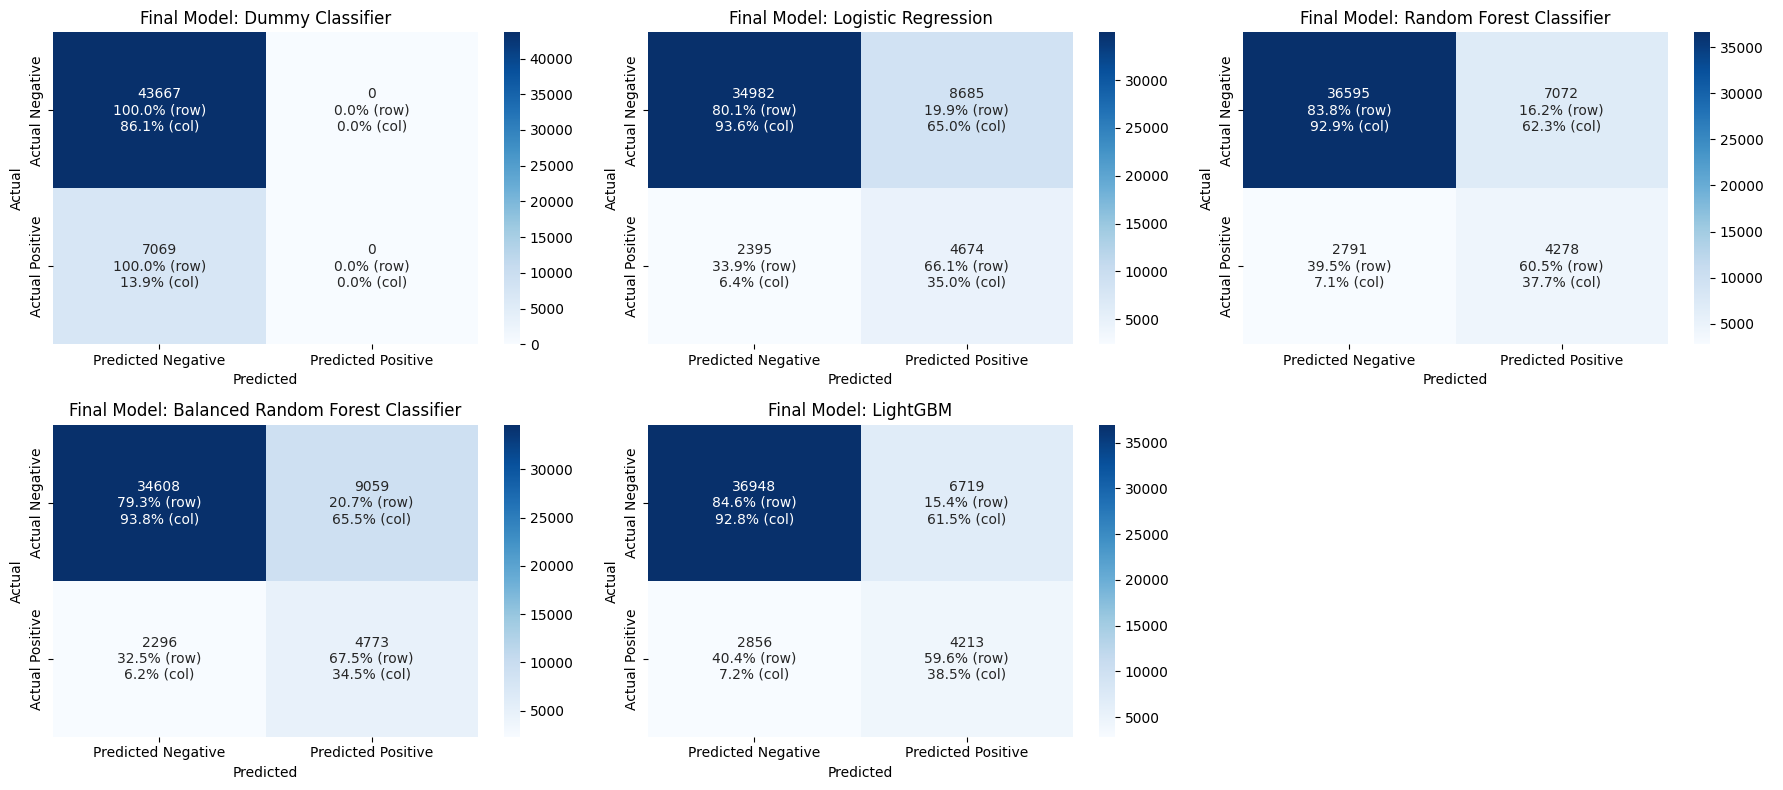

In [56]:
model_results = [
    {
        "model": "Final Model: Dummy Classifier",
        **metrics_dummy
    },
    {
        "model": "Final Model: Logistic Regression",
        **metrics_lr_final
    },
    {
        "model": "Final Model: Random Forest Classifier",
        **metrics_rf_final
    },
    {
        "model": "Final Model: Balanced Random Forest Classifier",
        **metrics_brf_final
    },
    {
        "model": "Final Model: LightGBM",
        **metrics_lgb_final
    }
]
plot_results(model_results)

del model_results